# Masterthesis: Descriptive analysis Team data

In [1]:
# Filename preprocessed data
#loaded_filename = 'teamdata2017_preprocessed'
#saved_filename = 'teamdata2017_standardized'
loaded_filename = 'teamdata2018_preprocessed'
saved_filename = 'teamdata2018_standardized'

## 0. Load libraries and define functions

In [2]:
# Functions
import numpy as np
import os
import pickle
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from datetime import datetime
from collections import Counter
from numpy.random import choice
from scipy import stats
import operator
import itertools
import statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [3]:
cm.get_cmap(name='tab20b')

In [4]:
### Function used to return a summary for categorical variables
def SummaryCategoricalVar(list_of_values, title, threshold = 20, top = 10):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    param: threshold (int): The maximal number of categories that should be visualized
    param: top (int): The top k values that should be returned in the written summary when the number of categories is above the threshold
    """
    # Count the number of occurrances in the list
    cnt = Counter(list_of_values)
    sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1))[::-1]
    
    # Show the percentage dictionary if to many categories to represent
    print("-"* 100, "\nOverview of variable: ", title, "\n", "-"*100)
    print("Total categories:", len(cnt), "\n")
    if len(cnt) > threshold:
        if len(cnt) < top*2:
            for key, value in sorted_cnt:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
        else:
            print("The 10 with the highest percentage data available:\n")
            for key, value in sorted_cnt[:top]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
            print("\nThe 10 with the lowest percentage data available:\n")
            for key, value in sorted_cnt[len(cnt) - top:]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
                
    # Visualization of labelled data distribution
    else:
        plt.barh(range(1, len(sorted_cnt)+1), 
                 list(map(lambda x: (x/len(list_of_values)*100), [score for label, score in sorted_cnt])), 
                 tick_label = list([label for label, score in sorted_cnt]),
                 color = 'cornflowerblue', 
                 edgecolor = 'steelblue')
        plt.ylabel('Label')
        plt.xlabel('Percentage observations in dataset')
        plt.title(title)
        plt.show()    
        plt.savefig('Barplot_' + title + '.png')

In [5]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(top=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()
    plt.savefig('Frequency_' + title + '.png')

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()
    plt.savefig('Boxplot_' + title + '.png')

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()
    plt.savefig('Probabilityplot_' + title + '.png')

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

In [6]:
### Function used to draw a random sample from the discrete distribution of probabilities representing the input list
def RandomSampleProbDist(list_of_values, draws = 1):
    """
    :param: list_of_values (list): A list of categorical values representing the observations in the dataset
    :param: draws (int): The number of samples desired to be returned
    :return: (array) An array capturing the sampled categories
    """
    # Only the non-missing values are considered in the sampling procedure
    non_missing_list = list_of_values.dropna()
    # Sample from the discrete probability distribution representing the categorical variable
    return choice(list(Counter(non_missing_list)), 
                  draws, 
                  p = list(map(lambda x: x/len(non_missing_list), 
                               Counter(non_missing_list).values())))

In [7]:
### Function used for a boxcox transformation of input features
def feature_transformer(feature, featurename):
    """
    Visualizes the input feature before and after being boxcox transformed. Furthermore the transformed data,
    based on the optimal lambda estimated with the boxcox method is returned in a standardized fashion (zero mean
    and a variance of one)
    """
    # Boxcox transformation
    transformed_feature, optimizer = stats.boxcox(feature)
    standardized_feature, standardized_transformed_feature = preprocessing.scale(feature), preprocessing.scale(transformed_feature)
    # Visualization
    print("Feature: ", featurename)
    plt.figure()
    sns.kdeplot(standardized_feature, shade=True, label=featurename )
    sns.kdeplot(standardized_transformed_feature, shade=True, label= "Transformed " + featurename)
    plt.savefig('Transformed_' + featurename + '.png')
    print("The optimal value for lambda: ", optimizer)
    # Return transformed and standardized data
    return standardized_transformed_feature, optimizer

## 1. Load data

In [8]:
# Load pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + loaded_filename + '.pickle', 'rb') as f:
    data_preparation = pickle.load(f)

##### Global summary data

In [9]:
# Visualization of the dataframe
data_preparation

gameid league  split game  patchno  side          ban1        ban2  \
22         240067    LCK    2.0    1      8.0  Blue         Xayah         Zac   
23         240067    LCK    2.0    1      8.0   Red         Galio      Syndra   
34         240080    LCK    2.0    2      8.0  Blue        Syndra       Galio   
35         240080    LCK    2.0    2      8.0   Red           Zac       Elise   
46         240081    LCK    2.0    3      8.0  Blue           Zac       Jayce   
47         240081    LCK    2.0    3      8.0   Red        Syndra      Kennen   
58         240086    LCK    2.0    1      8.0  Blue        Kennen     LeBlanc   
59         240086    LCK    2.0    1      8.0   Red         Karma         Zac   
70         240103    LCK    2.0    2      8.0  Blue         Elise       Karma   
71         240103    LCK    2.0    2      8.0   Red        Kennen         Zac   
82         240140    LCK    2.0    1      8.0  Blue        Kennen       Elise   
83         240140    LCK    2.0    1      8.0   Red        Gragas       Jayce   
94         240141    LCK    2.0    2      8.0  Blue        Syndra  Tahm Kench   
95         240141    LCK    2.0    2      8.0   Red        Kennen       Elise   
130        240162    LCK    2.0    2      8.0  Blue       Taliyah       Elise   
131        240162    LCK    2.0    2      8.0   Red       Lee Sin      Twitch   
166    1002100030  EULCS    2.0    1      8.0  Blue  Aurelion Sol      Kennen   
167    1002100030  EULCS    2.0    1      8.0   Red           Zac       Xayah   
178    1002100035  EULCS    2.0    2      8.0  Blue        Syndra        Zyra   
179    1002100035  EULCS    2.0    2      8.0   Red           Zac      Kennen   
214        250221    LCK    2.0    2      8.0  Blue       Orianna        Ashe   
215        250221    LCK    2.0    2      8.0   Red         Elise         Zac   
226        250224    LCK    2.0    3      8.0  Blue        Kennen      Syndra   
227        250224    LCK    2.0    3      8.0   Red          Ashe       Varus   
238        250228    LCK    2.0    1      8.0  Blue       LeBlanc       Varus   
239        250228    LCK    2.0    1      8.0   Red        Syndra        Ashe   
250        250245    LCK    2.0    2      8.0  Blue        Syndra      Thresh   
251        250245    LCK    2.0    2      8.0   Red       LeBlanc         Zac   
262    1002100037  EULCS    2.0    1      8.0  Blue         Jayce      Rumble   
263    1002100037  EULCS    2.0    1      8.0   Red           Zac      Twitch   
...           ...    ...    ...  ...      ...   ...           ...         ...   
16018     1790149    LMS    6.0    2     36.0  Blue         Akali  Tahm Kench   
16019     1790149    LMS    6.0    2     36.0   Red         Rakan     Alistar   
16030     1790157    LMS    6.0    3     36.0  Blue         Rakan      Gragas   
16031     1790157    LMS    6.0    3     36.0   Red         Akali     Taliyah   
16042     1790158    LMS    6.0    4     36.0  Blue         Akali  Tahm Kench   
16043     1790158    LMS    6.0    4     36.0   Red         Rakan     Alistar   
16054     1780196    LMS    6.0    1     36.0  Blue          Olaf      Gragas   
16055     1780196    LMS    6.0    1     36.0   Red         Akali      Aatrox   
16066     1780199    LMS    6.0    2     36.0  Blue          Olaf      Gragas   
16067     1780199    LMS    6.0    2     36.0   Red         Akali      Aatrox   
16078     1780204    LMS    6.0    3     36.0  Blue          Olaf      Gragas   
16079     1780204    LMS    6.0    3     36.0   Red         Akali  Tahm Kench   
16090     1780208    LMS    6.0    4     36.0  Blue         Akali      Aatrox   
16091     1780208    LMS    6.0    4     36.0   Red          Olaf     Evelynn   
16102     1780218    LMS    6.0    5     36.0  Blue          Olaf      Gragas   
16103     1780218    LMS    6.0    5     36.0   Red         Akali  Tahm Kench   
16114     1790283    LMS    6.0    1     36.0  Blue         Akali  Tahm Kench   
16115     1790283    LMS    6.0    1     3

In [10]:
# Short intermediate summary
print("The final dataset captures information from", len(data_preparation.columns), "features.")
print("In total, there are", len(data_preparation), "observations present in the dataframe, capturing the information from",
      len(set(data_preparation.gameid)), "games.")

The final dataset captures information from 76 features.
In total, there are 11396 observations present in the dataframe, capturing the information from 5698 games.


##### Extract categorical/ numerical feature list

In [11]:
# Initialization
categorical_variables, numerical_variables = [], []

# Extract categorical and numeric variables
for col, col_type in zip(data_preparation.columns, data_preparation.dtypes):
    if str(col_type) == 'object':
        categorical_variables.append(col)
    else:
        numerical_variables.append(col)

## 2. Univariate analysis of the data
In a first phase all the variables are investigated in a univariate analysis. A distinction is made here between categorical and numerical variables. 

In [12]:
# Create new dataset to capture final preprocssed dataframe (used for analysis)
preprocessed_data = data_preparation.copy()
os.chdir('./Univariate_analysis/')

In [13]:
# Check
os.getcwd()

'/home/je32910/MasterThesis_ComputationalStatistics/Univariate_analysis'

### 2.1 Analysis of categorical variables
The following aspect will be analysed here:
* Balanced classes

Furthermore one-hot encoding will be considered to transform these variables to an appropriate format ready for analysis.

##### Exploration characteristics categorical features

---------------------------------------------------------------------------------------------------- 
Overview of variable:  gameid 
 ----------------------------------------------------------------------------------------------------
Total categories: 5698 

The 10 with the highest percentage data available:

791070 : 0.0176 %
830268 : 0.0176 %
830267 : 0.0176 %
830255 : 0.0176 %
1790287 : 0.0176 %
1790285 : 0.0176 %
1790283 : 0.0176 %
1780218 : 0.0176 %
1780208 : 0.0176 %
1780204 : 0.0176 %

The 10 with the lowest percentage data available:

1002100035 : 0.0176 %
1002100030 : 0.0176 %
240162 : 0.0176 %
240141 : 0.0176 %
240140 : 0.0176 %
240103 : 0.0176 %
240086 : 0.0176 %
240081 : 0.0176 %
240080 : 0.0176 %
240067 : 0.0176 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  league 
 ----------------------------------------------------------------------------------------------------
Total categories: 16 



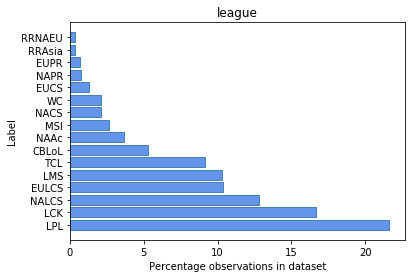

---------------------------------------------------------------------------------------------------- 
Overview of variable:  game 
 ----------------------------------------------------------------------------------------------------
Total categories: 25 

The 10 with the highest percentage data available:

1 : 38.9259 %
2 : 38.9084 %
3 : 15.8652 %
4 : 3.1766 %
5 : 1.6497 %
6 : 0.5265 %
T : 0.4388 %
2.6 : 0.0351 %
2.5 : 0.0351 %
2.4 : 0.0351 %

The 10 with the lowest percentage data available:

1.3 : 0.0351 %
1.2 : 0.0351 %
1.1 : 0.0351 %
2.1 : 0.0176 %
3.6 : 0.0176 %
3.5 : 0.0176 %
3.4 : 0.0176 %
3.3 : 0.0176 %
3.2 : 0.0176 %
3.1 : 0.0176 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  side 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



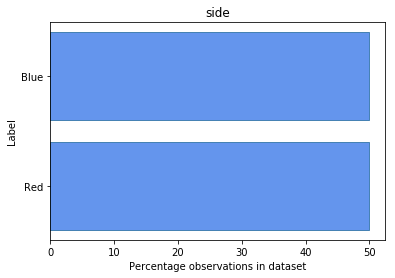

---------------------------------------------------------------------------------------------------- 
Overview of variable:  ban1 
 ----------------------------------------------------------------------------------------------------
Total categories: 118 

The 10 with the highest percentage data available:

Camille : 5.5897 %
Zac : 4.993 %
Aatrox : 4.9052 %
LeBlanc : 4.9052 %
Zoe : 3.4223 %
Kalista : 3.3959 %
Taliyah : 3.2994 %
Ryze : 3.0098 %
Galio : 2.9133 %
Shen : 2.6764 %

The 10 with the lowest percentage data available:

Bard : 0.0263 %
Illaoi : 0.0263 %
Lissandra : 0.0176 %
Veigar : 0.0176 %
Vayne : 0.0176 %
Sivir : 0.0176 %
Xin Zhao : 0.0088 %
Xerath : 0.0088 %
Nami : 0.0088 %
Vi : 0.0088 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  ban2 
 ----------------------------------------------------------------------------------------------------
Total categories: 120 

The 10 with the highest percentage 

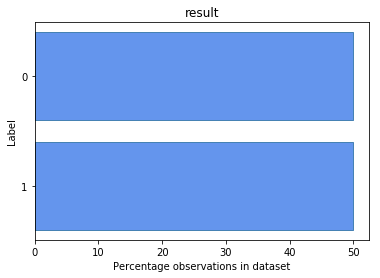

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fb 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



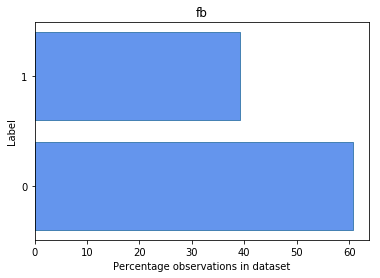

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbassist 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



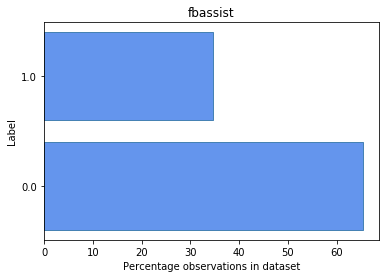

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbvictim 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



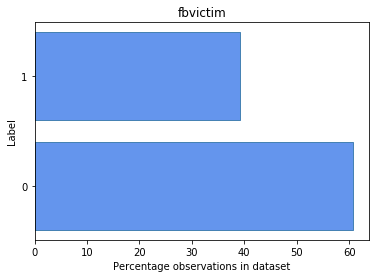

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fd 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



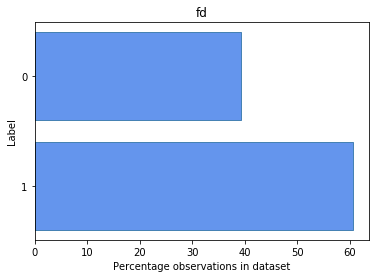

---------------------------------------------------------------------------------------------------- 
Overview of variable:  herald 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



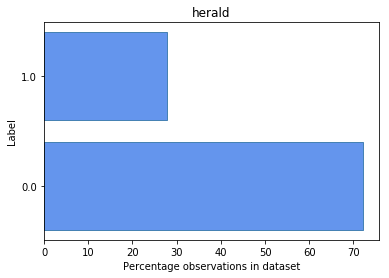

---------------------------------------------------------------------------------------------------- 
Overview of variable:  ft 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



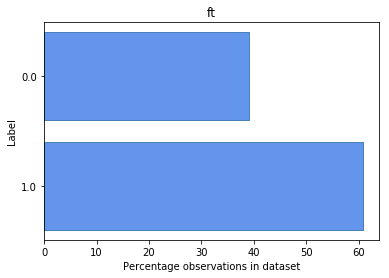

---------------------------------------------------------------------------------------------------- 
Overview of variable:  firstmidouter 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



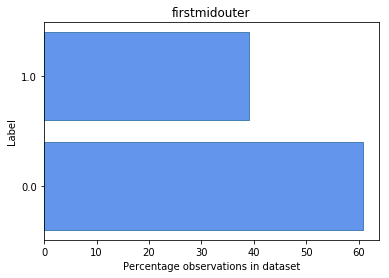

---------------------------------------------------------------------------------------------------- 
Overview of variable:  firsttothreetowers 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



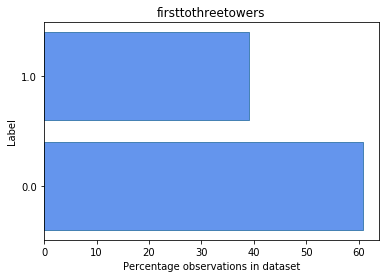

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbaron 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



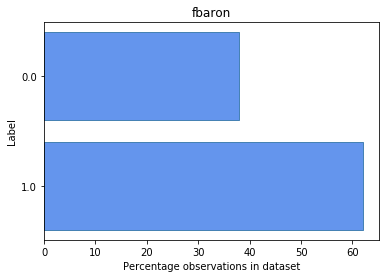

---------------------------------------------------------------------------------------------------- 
Overview of variable:  Year 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



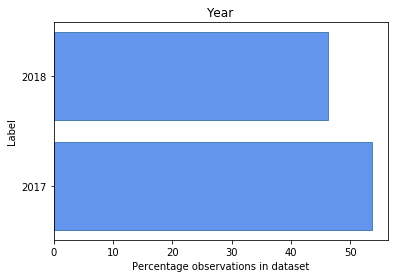

---------------------------------------------------------------------------------------------------- 
Overview of variable:  team 
 ----------------------------------------------------------------------------------------------------
Total categories: 131 

The 10 with the highest percentage data available:

royal never give up : 2.1411 %
team we : 2.0885 %
sk telecom t1 : 2.0797 %
edward gaming : 1.9305 %
cloud9 : 1.913 %
team liquid : 1.8954 %
invictus gaming : 1.8515 %
counter logic gaming : 1.834 %
afreeca freecs : 1.8252 %
kt rolster : 1.8252 %

The 10 with the lowest percentage data available:

cj entus : 0.079 %
17 academy : 0.079 %
young generation : 0.0614 %
pentagram : 0.0527 %
ascension gaming : 0.0527 %
rainbow7 : 0.0527 %
isurus gaming : 0.0527 %
virtus.pro : 0.0527 %
oyunhizmetleri : 0.0351 %
besiktas : 0.0263 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  culture 
 ----------------------------

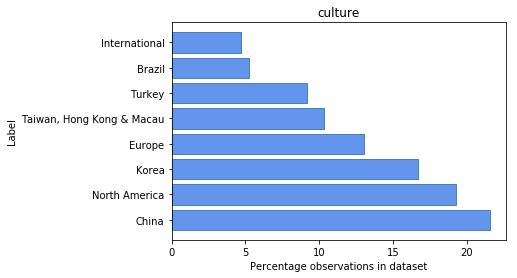

<Figure size 432x288 with 0 Axes>

In [14]:
# Loop through all categorical variables and visualize data
for cat_variable in categorical_variables:
    SummaryCategoricalVar(preprocessed_data[cat_variable], cat_variable)

In [15]:
# Most banned champion
most_banned = list(itertools.chain(preprocessed_data['ban1'], preprocessed_data['ban2'], preprocessed_data['ban3'],
                                   preprocessed_data['ban4'], preprocessed_data['ban5']))
SummaryCategoricalVar(most_banned, "Total times banned as champion")

---------------------------------------------------------------------------------------------------- 
Overview of variable:  Total times banned as champion 
 ----------------------------------------------------------------------------------------------------
Total categories: 133 

The 10 with the highest percentage data available:

Camille : 4.2155 %
LeBlanc : 3.4731 %
Taliyah : 3.0309 %
Galio : 2.5851 %
Shen : 2.4746 %
Zac : 2.4307 %
Ryze : 2.3991 %
Varus : 2.3061 %
Syndra : 2.2341 %
Caitlyn : 2.1569 %

The 10 with the lowest percentage data available:

Xerath : 0.0176 %
Shyvana : 0.0158 %
Nasus : 0.0105 %
Vi : 0.0105 %
Cho'Gath : 0.0088 %
Hecarim : 0.007 %
Sona : 0.0053 %
Amumu : 0.0035 %
Lux : 0.0018 %
Garen : 0.0018 %


##### Encoding

In [16]:
# Encode categorical features in numeric ones
for col in categorical_variables:
    try:
        preprocessed_data['Encoded_' + col] = [int(x) for x in list(preprocessed_data[col])]
    except:
        try: 
            preprocessed_data['Encoded_' + col] = [float(x) for x in list(preprocessed_data[col])]
        except:
            mapping_dict = dict(zip(list(set(preprocessed_data[col])), list(range(len(set(preprocessed_data[col]))))))
            preprocessed_data['Encoded_' + col] = [mapping_dict[x] for x in preprocessed_data[col]]

##### Remove irrelevant features for further analysis

In [17]:
# Drop irrelevant features
catvar_before_encoding = [col[len('Encoded_'):] for col in preprocessed_data.columns if 'Encoded_' in col]
catvar_before_encoding.remove('team')
preprocessed_data = preprocessed_data.drop(labels=catvar_before_encoding, axis=1)
preprocessed_data = preprocessed_data.drop(labels = ['Encoded_gameid', 'Encoded_team'], axis=1)

In [18]:
# Add one-hot-encoded features to numerical feature list
for cat in catvar_before_encoding:
    numerical_variables.append('Encoded_' + cat)
numerical_variables.remove('Encoded_gameid')

### 2.2 Analysis of numerical variables
The following aspects will be analysed here:
* Visualisation data (boxplot, histogram)
* Minimal and maximal values 
* Outliers
* Transformation/ normalization of the data
* Near zero variance indicator (before and after removal outliers)
* Skewness: A measure of lack of symmetry. The skewness for a normal distribution is zero and any symmertric data should have a skewness near zero. Negative values for skewness indicate the data to be skewed left while, positive values imply the data to be skewed right. In case the data is multi-modal, the sign of the skewness metric might be affected.
* Kurtosis: A measure indicating whether the data are heavy-tailed or light-tailed relative to a normal distribution. In case the kurtosis is high the data is distributed with heavy tails (many outliers), while data with low kurtosis tends to have light tails. The kurtosis for a standard normal distribution is three. The scipy package used to calculate the kurtosis here uses the formula for "excess kurtosis" in which the deviation from the normal condition is considered (kurtosis - 3).

##### Exploration characteristics numerical features

Overview of variable:  split 


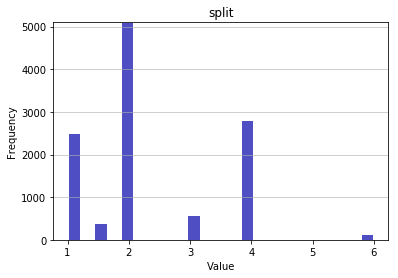

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.0
Mean: 2.3402
Standard deviation: 1.1323
Median: 2.0
Maximal value: 6.0


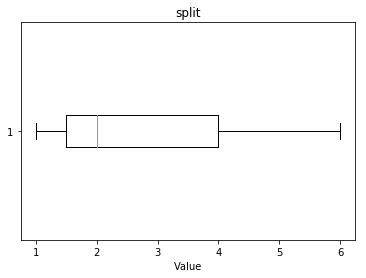

-------------------- 
Outlier detection:
 --------------------
List of outliers: {6.0}


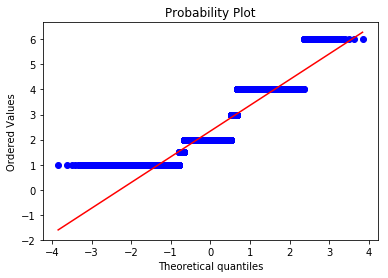

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7005
Kurtosis: -0.4303
Overview of variable:  patchno 


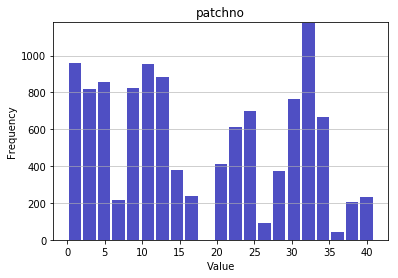

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 17.6025
Standard deviation: 12.1634
Median: 14.0
Maximal value: 41.0


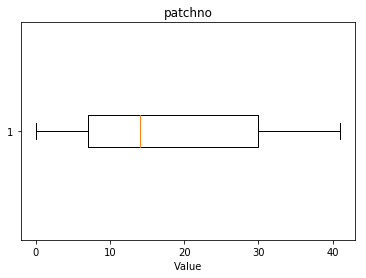

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


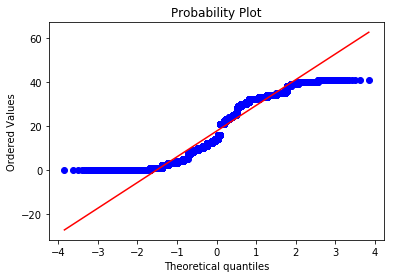

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1651
Kurtosis: -1.3668
Overview of variable:  gamelength 


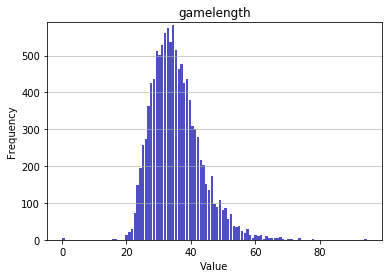

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 35.4633
Standard deviation: 7.6644
Median: 34.45
Maximal value: 94.66666666666667


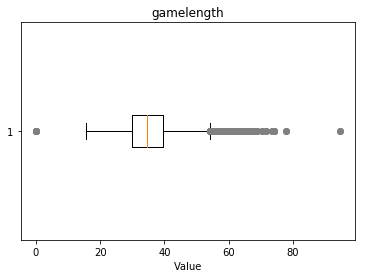

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.0, 62.15, 58.98, 59.9, 59.82, 59.97, 59.85, 59.58, 60.63, 60.13, 60.95, 64.55, 63.25, 61.57, 61.12, 61.82, 61.15, 60.32, 62.07, 62.65, 58.87, 58.83, 60.65, 58.72, 62.23, 63.35, 63.52, 65.7, 65.9, 67.65, 67.58, 65.82, 65.38, 63.2, 63.13, 70.25, 64.72, 66.83, 68.15, 77.95, 66.98, 71.63, 64.43, 74.03, 73.5, 67.9, 68.92, 62.22, 94.67, 65.15, 64.95, 74.08}


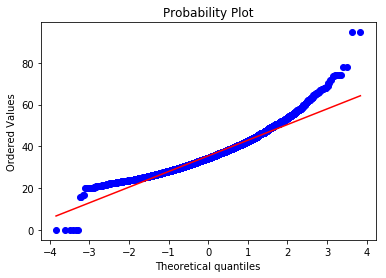

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9188
Kurtosis: 2.1158
Overview of variable:  k 


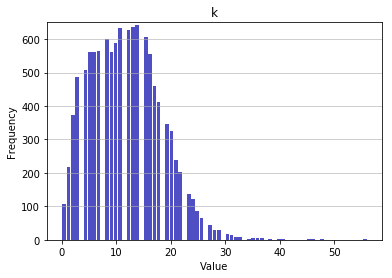

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 11.673
Standard deviation: 6.4459
Median: 11.0
Maximal value: 56.0


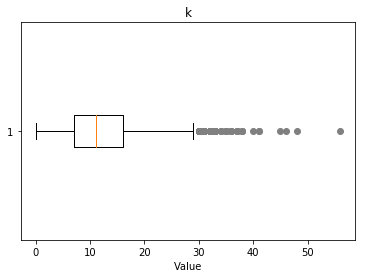

-------------------- 
Outlier detection:
 --------------------
List of outliers: {32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 45.0, 46.0, 48.0, 56.0}


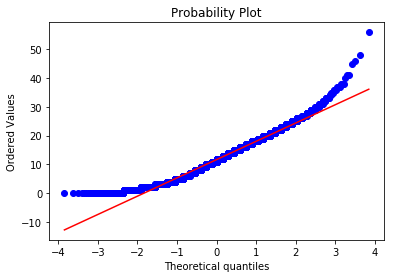

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4794
Kurtosis: 0.2589
Overview of variable:  d 


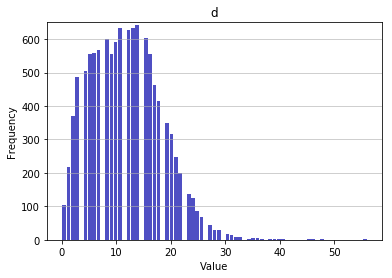

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 11.6911
Standard deviation: 6.452
Median: 11.0
Maximal value: 56.0


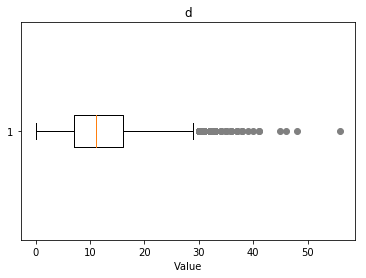

-------------------- 
Outlier detection:
 --------------------
List of outliers: {32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 45.0, 46.0, 48.0, 56.0}


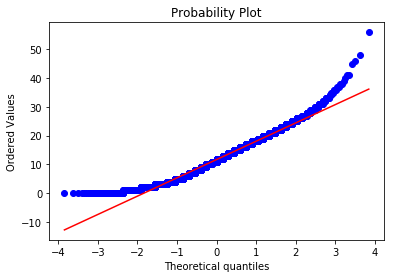

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4801
Kurtosis: 0.2607
Overview of variable:  a 


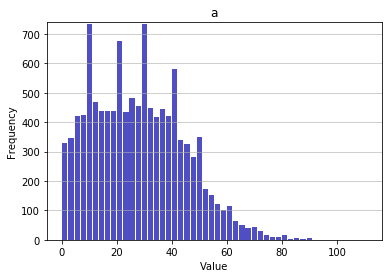

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 27.8306
Standard deviation: 16.663
Median: 27.0
Maximal value: 111.0


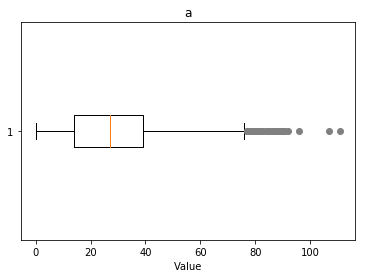

-------------------- 
Outlier detection:
 --------------------
List of outliers: {96.0, 83.0, 107.0, 78.0, 79.0, 80.0, 81.0, 82.0, 111.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0}


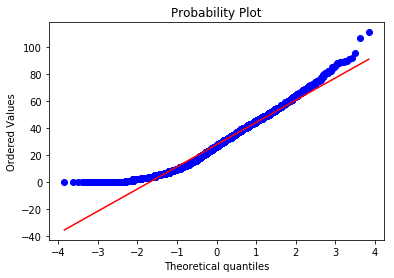

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4683
Kurtosis: -0.1765
Overview of variable:  teamkills 


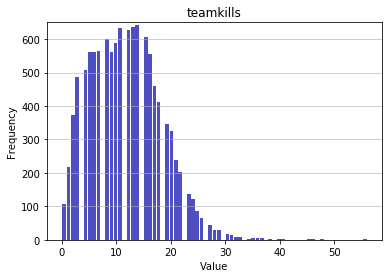

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 11.673
Standard deviation: 6.4459
Median: 11.0
Maximal value: 56.0


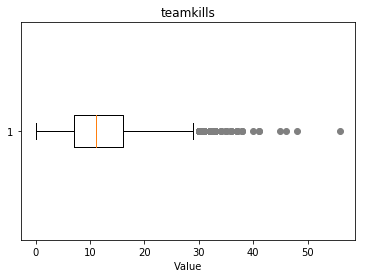

-------------------- 
Outlier detection:
 --------------------
List of outliers: {32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 45.0, 46.0, 48.0, 56.0}


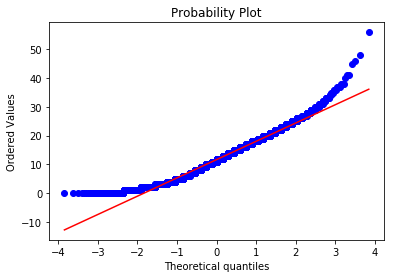

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4794
Kurtosis: 0.2589
Overview of variable:  fbtime 


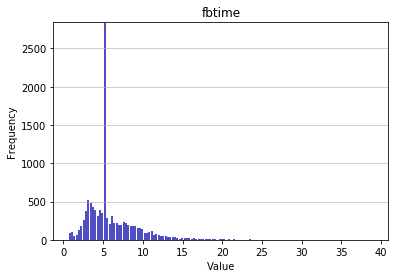

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.6477833333333333
Mean: 6.0734
Standard deviation: 3.2476
Median: 5.3364
Maximal value: 38.99143333333333


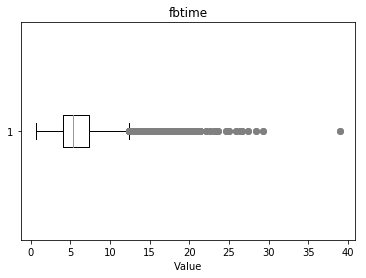

-------------------- 
Outlier detection:
 --------------------
List of outliers: {15.87, 16.31, 16.01, 16.33, 18.63, 19.58, 19.18, 20.64, 18.47, 16.2, 16.3, 17.89, 19.02, 27.42, 29.3, 21.35, 26.35, 28.37, 25.04, 25.86, 26.67, 38.99, 15.86, 15.89, 15.93, 16.71, 16.43, 16.39, 16.6, 16.75, 17.0, 17.21, 17.82, 17.03, 17.57, 18.11, 18.0, 17.6, 18.72, 18.1, 19.75, 18.07, 19.9, 20.32, 20.93, 21.33, 16.73, 16.23, 22.65, 23.64, 23.15, 16.36, 24.65, 16.05, 15.95, 15.84, 16.09, 16.76, 16.87, 16.84, 16.56, 16.13, 17.8, 17.81, 17.69, 16.98, 16.34, 18.51, 18.37, 18.88, 17.23, 18.45, 18.13, 18.69, 18.62, 18.81, 18.01, 20.99, 20.38, 19.84, 21.3, 21.23, 22.06, 23.44, 23.49}


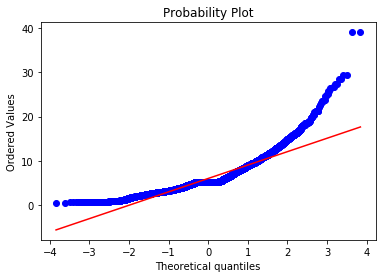

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.8511
Kurtosis: 6.4995
Overview of variable:  kpm 


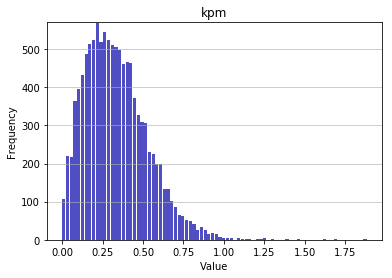

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3347
Standard deviation: 0.1937
Median: 0.3114
Maximal value: 1.882845188284519


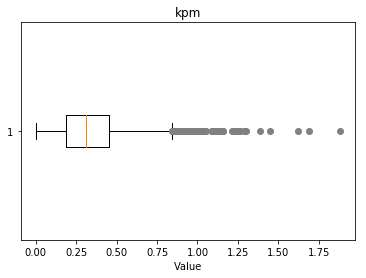

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.99, 1.12, 0.94, 1.25, 1.04, 0.95, 1.01, 0.96, 1.03, 0.93, 1.09, 1.0, 0.92, 1.26, 1.69, 1.02, 1.45, 1.11, 1.13, 1.38, 1.29, 1.62, 1.88, 1.21, 0.97, 1.05, 1.3, 0.98, 1.23, 1.15, 1.24, 1.16}


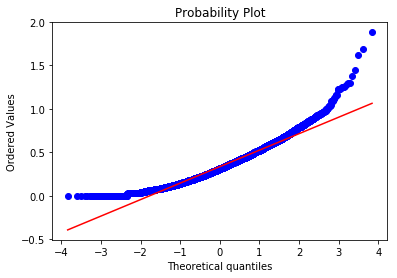

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8611
Kurtosis: 1.4861
Overview of variable:  ckpm 


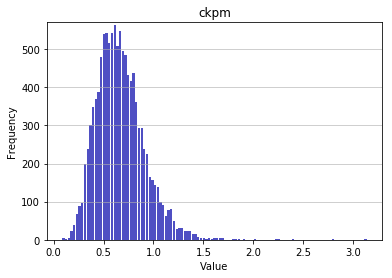

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.08412197686645637
Mean: 0.6694
Standard deviation: 0.2422
Median: 0.6423
Maximal value: 3.1380753138075317


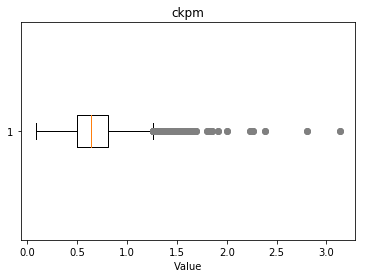

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1.41, 1.57, 1.47, 1.55, 1.66, 1.68, 1.43, 1.45, 1.49, 1.6, 2.23, 2.0, 1.67, 2.26, 1.44, 1.52, 1.85, 1.7, 1.61, 1.63, 2.8, 1.64, 1.48, 1.81, 1.4, 2.39, 3.14, 1.82, 1.91}


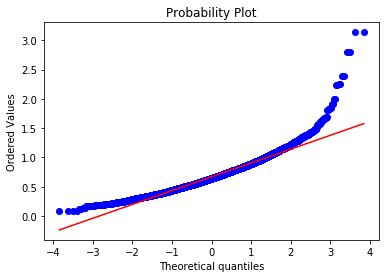

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1335
Kurtosis: 4.6481
Overview of variable:  fdtime 


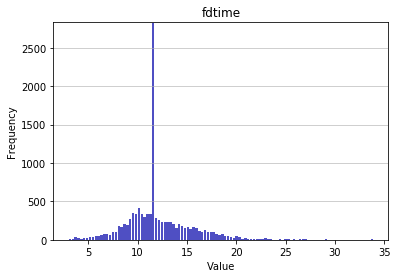

-------------------- 
Summary statistics:
 --------------------
Minimum value: 2.9805333333333333
Mean: 12.151
Standard deviation: 3.4278
Median: 11.6379
Maximal value: 33.89945


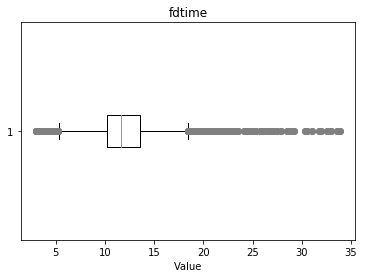

-------------------- 
Outlier detection:
 --------------------
List of outliers: {26.95, 26.51, 26.98, 26.01, 26.77, 27.5, 27.9, 27.12, 27.04, 30.51, 28.91, 25.2, 29.24, 29.06, 22.8, 22.99, 22.67, 23.03, 23.09, 25.86, 26.48, 26.76, 25.24, 28.46, 24.46, 23.22, 32.99, 24.44, 25.15, 28.96, 29.08, 25.27, 31.71, 30.34, 33.55, 32.57, 33.78, 33.9, 24.85, 25.84, 31.9, 24.42, 24.51, 22.51, 25.25, 24.12, 31.04, 25.8, 22.68, 24.53, 22.49, 22.92, 22.65, 22.86, 22.87, 23.44, 23.02, 23.42, 23.04, 23.53, 23.24, 23.16, 23.28, 23.11, 23.45, 25.07, 25.94}


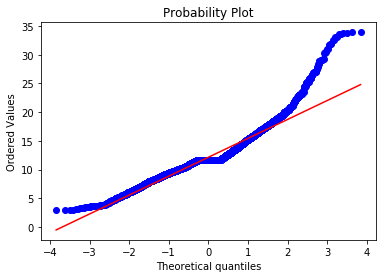

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1865
Kurtosis: 3.8103
Overview of variable:  teamdragkills 


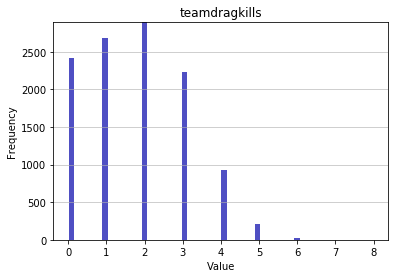

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 1.7642
Standard deviation: 1.3276
Median: 2.0
Maximal value: 8.0


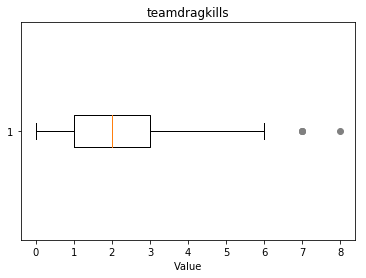

-------------------- 
Outlier detection:
 --------------------
List of outliers: {8.0, 6.0, 7.0}


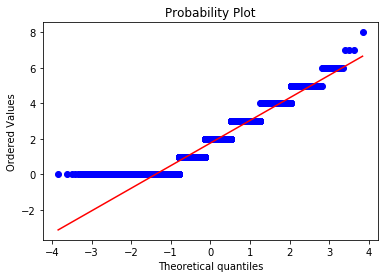

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3672
Kurtosis: -0.5323
Overview of variable:  elementals 


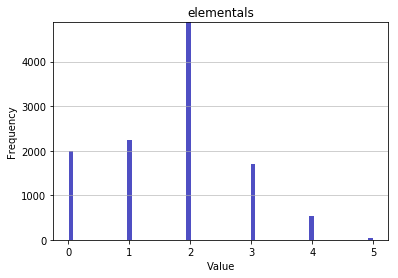

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 1.7081
Standard deviation: 1.0887
Median: 2.0
Maximal value: 5.0


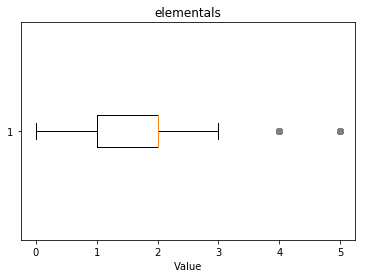

-------------------- 
Outlier detection:
 --------------------
List of outliers: {5.0}


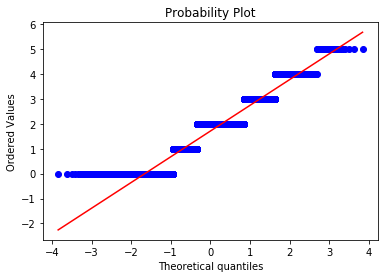

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0711
Kurtosis: -0.3642
Overview of variable:  firedrakes 


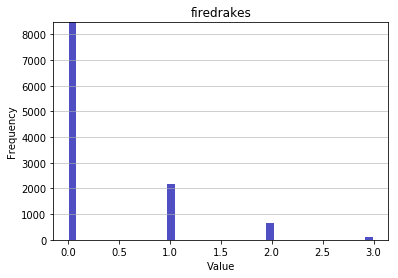

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3349
Standard deviation: 0.6311
Median: 0.0
Maximal value: 3.0


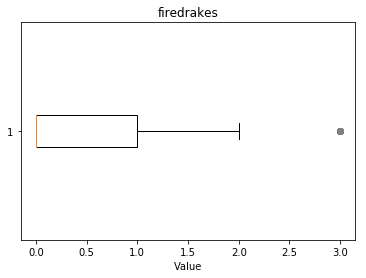

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


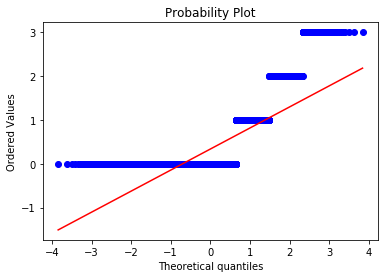

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9225
Kurtosis: 3.2569
Overview of variable:  waterdrakes 


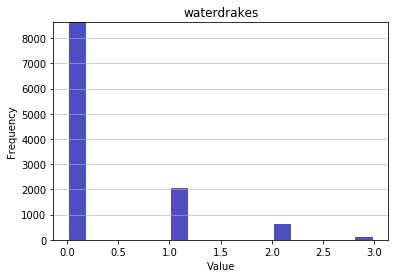

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3166
Standard deviation: 0.6177
Median: 0.0
Maximal value: 3.0


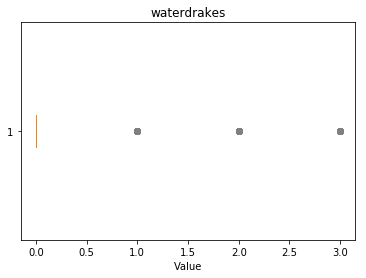

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


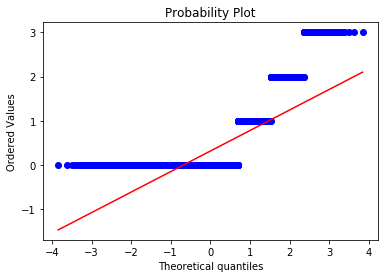

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 2.006
Kurtosis: 3.6165
Overview of variable:  earthdrakes 


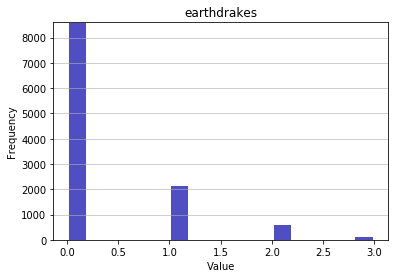

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3145
Standard deviation: 0.6073
Median: 0.0
Maximal value: 3.0


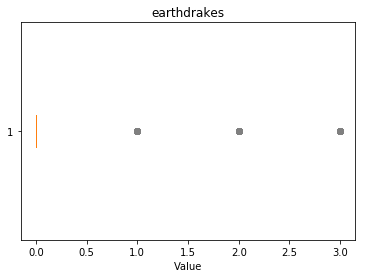

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


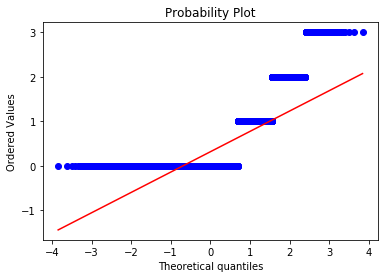

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9826
Kurtosis: 3.5695
Overview of variable:  airdrakes 


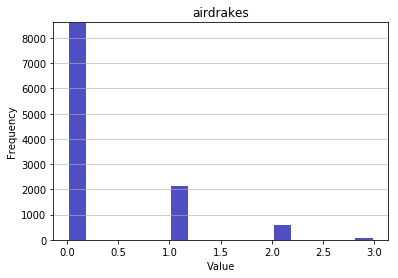

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3092
Standard deviation: 0.598
Median: 0.0
Maximal value: 3.0


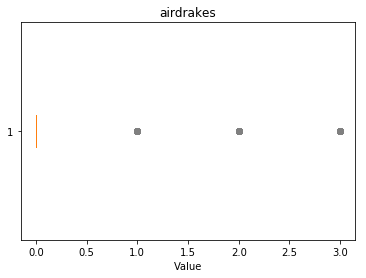

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


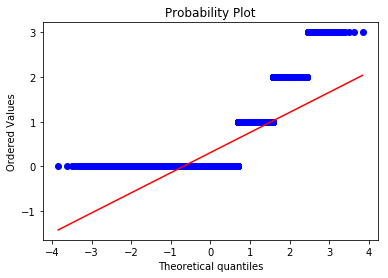

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9758
Kurtosis: 3.5387
Overview of variable:  elders 


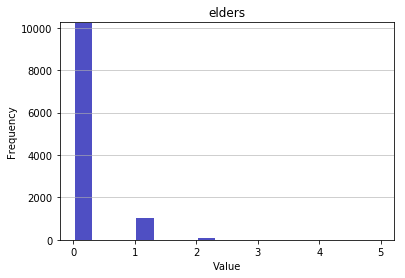

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.1124
Standard deviation: 0.3549
Median: 0.0
Maximal value: 5.0


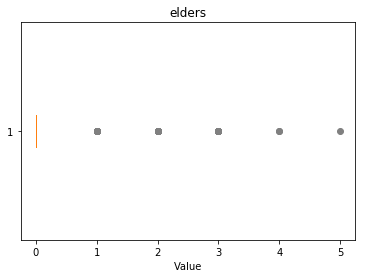

-------------------- 
Outlier detection:
 --------------------
List of outliers: {2.0, 3.0, 4.0, 5.0}


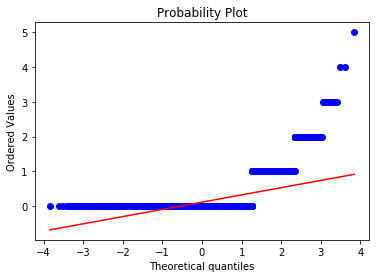

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 3.6191
Kurtosis: 16.9435
Overview of variable:  heraldtime 


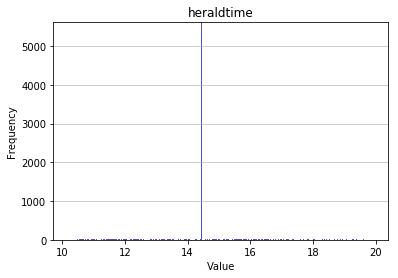

-------------------- 
Summary statistics:
 --------------------
Minimum value: 10.202416666666666
Mean: 14.5428
Standard deviation: 1.9045
Median: 14.4537
Maximal value: 19.91675


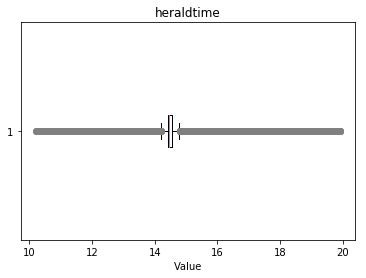

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


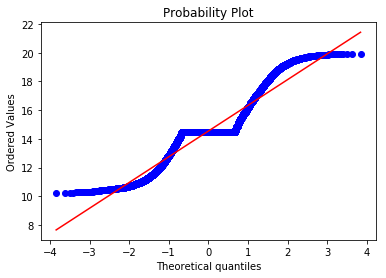

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3876
Kurtosis: 0.791
Overview of variable:  fttime 


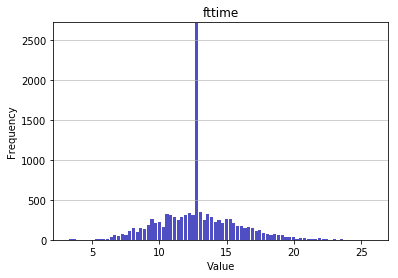

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3.2423333333333333
Mean: 12.8355
Standard deviation: 2.8078
Median: 12.6843
Maximal value: 25.8949


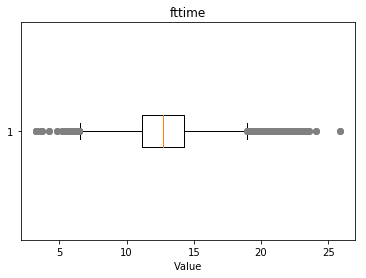

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.24, 4.21, 3.27, 3.73, 3.65, 3.3, 21.58, 21.44, 23.46, 23.55, 23.07, 21.32, 21.99, 21.61, 21.6, 22.5, 22.07, 24.09, 25.89, 21.88, 21.82, 21.95, 21.97, 21.47, 21.87, 21.96, 21.74, 21.56, 21.35, 22.1, 22.77, 22.86, 22.88, 21.31, 21.73, 23.27, 22.41, 23.53, 21.8}


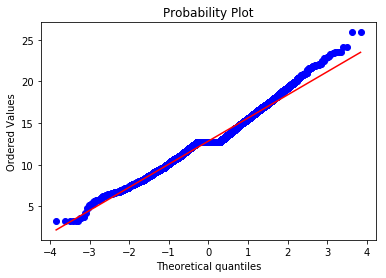

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3712
Kurtosis: 0.7643
Overview of variable:  teamtowerkills 


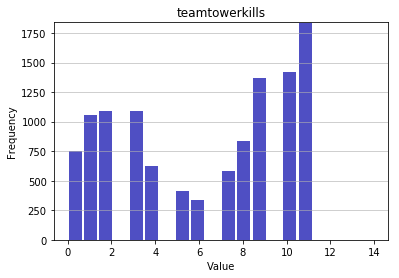

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 6.1899
Standard deviation: 3.8388
Median: 7.0
Maximal value: 14.0


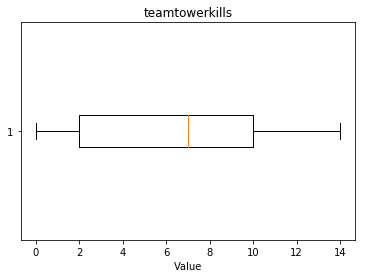

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


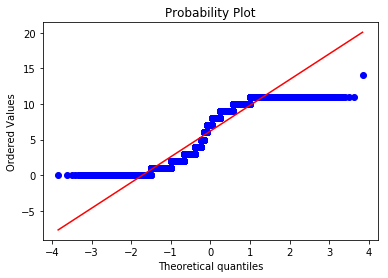

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2001
Kurtosis: -1.5017
Overview of variable:  fbarontime 


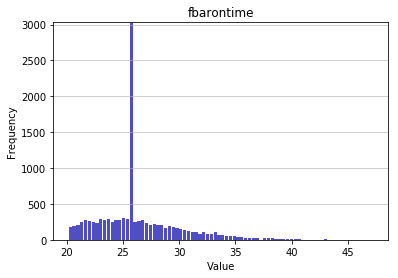

-------------------- 
Summary statistics:
 --------------------
Minimum value: 20.161783333333332
Mean: 26.371
Standard deviation: 3.6885
Median: 25.8742
Maximal value: 47.2605


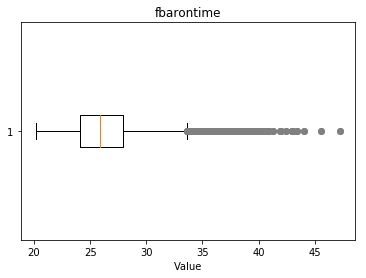

-------------------- 
Outlier detection:
 --------------------
List of outliers: {38.34, 39.36, 38.78, 38.49, 38.35, 38.1, 37.68, 39.97, 38.3, 40.52, 37.52, 38.83, 38.36, 38.44, 37.95, 39.69, 40.18, 40.37, 40.77, 37.45, 39.86, 39.49, 40.32, 42.95, 42.93, 45.55, 38.18, 38.74, 47.26, 37.82, 38.87, 39.42, 37.91, 37.55, 37.92, 37.79, 37.93, 37.63, 37.88, 38.26, 38.47, 38.28, 39.43, 39.61, 39.4, 39.51, 39.95, 40.09, 40.27, 40.67, 40.41, 37.58, 41.25, 41.91, 38.38, 38.13, 40.71, 42.01, 42.45, 39.05, 37.65, 43.08, 39.0, 43.42, 37.9, 44.07, 38.08, 40.93, 37.53, 37.75, 38.65, 40.56, 37.54, 39.33}


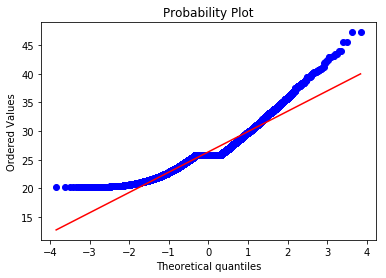

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.076
Kurtosis: 1.8393
Overview of variable:  teambaronkills 


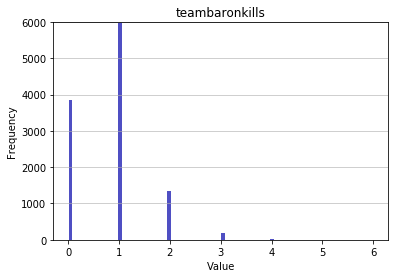

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.8193
Standard deviation: 0.7196
Median: 1.0
Maximal value: 6.0


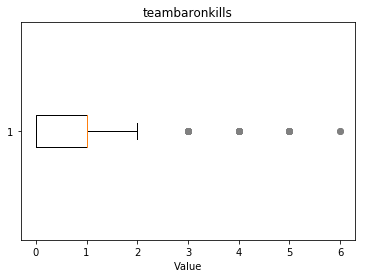

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0, 4.0, 5.0, 6.0}


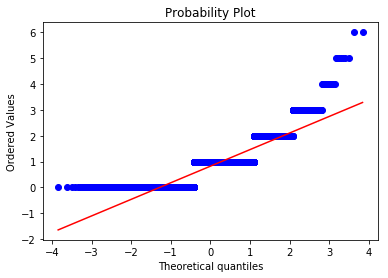

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8056
Kurtosis: 1.5809
Overview of variable:  dmgtochamps 


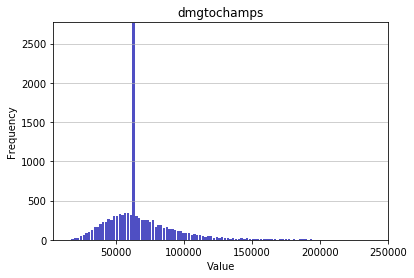

-------------------- 
Summary statistics:
 --------------------
Minimum value: 14879.0
Mean: 67284.7747
Standard deviation: 24793.9348
Median: 63319.0
Maximal value: 239076.0


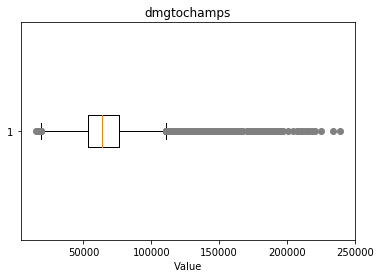

-------------------- 
Outlier detection:
 --------------------
List of outliers: {152069.0, 143880.0, 186381.0, 148498.0, 186899.0, 215570.0, 146450.0, 173088.0, 148515.0, 165924.0, 225320.0, 154153.0, 146474.0, 190000.0, 209973.0, 155189.0, 171575.0, 144953.0, 180306.0, 152660.0, 189528.0, 181337.0, 143961.0, 153694.0, 147554.0, 164962.0, 157284.0, 207464.0, 149100.0, 172656.0, 173685.0, 147063.0, 142456.0, 173687.0, 145530.0, 146553.0, 158337.0, 177282.0, 174216.0, 191113.0, 188040.0, 163465.0, 160910.0, 145041.0, 148632.0, 173209.0, 170649.0, 196761.0, 155293.0, 144542.0, 179872.0, 192673.0, 143008.0, 143013.0, 147622.0, 208039.0, 190119.0, 151210.0, 159916.0, 174257.0, 176306.0, 185525.0, 156341.0, 220344.0, 142013.0, 153279.0, 165057.0, 154308.0, 143048.0, 164552.0, 157905.0, 180441.0, 155866.0, 195801.0, 145629.0, 158942.0, 170208.0, 160993.0, 146144.0, 142054.0, 154856.0, 166642.0, 183541.0, 218360.0, 145150.0, 144640.0, 166657.0, 148229.0, 186634.0, 187150.0, 185103.0, 192270.0

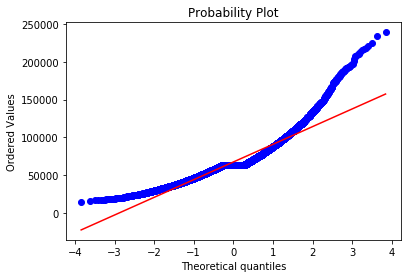

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.5354
Kurtosis: 4.4254
Overview of variable:  dmgtochampsperminute 


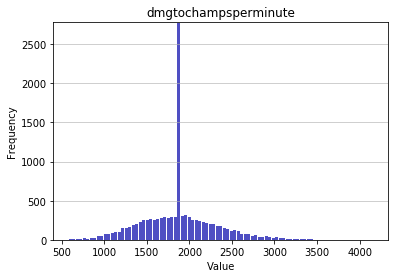

-------------------- 
Summary statistics:
 --------------------
Minimum value: 578.397534668721
Mean: 1872.9941
Standard deviation: 435.0609
Median: 1856.1604
Maximal value: 4161.346733668342


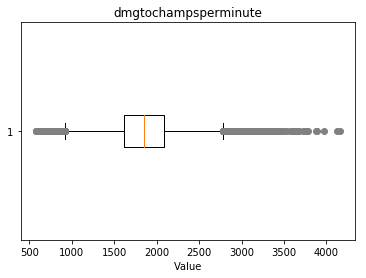

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3200.13, 3202.46, 3587.16, 3971.87, 3589.58, 3459.12, 3718.88, 3334.33, 3336.77, 3338.36, 3467.36, 3212.15, 3338.76, 3214.29, 3213.78, 3601.34, 3474.22, 3345.81, 3220.51, 3223.75, 3225.26, 3225.35, 3353.06, 4122.03, 3229.3, 3359.71, 3232.61, 3232.9, 3231.74, 3363.57, 3876.62, 3487.21, 3231.05, 3235.61, 3753.4, 3242.43, 3882.92, 3372.45, 3242.98, 3373.83, 3375.87, 3631.59, 3505.39, 3250.37, 3760.67, 3636.02, 3252.61, 3374.58, 3383.64, 3390.11, 3263.13, 3392.57, 4161.35, 3266.84, 3267.0, 3780.57, 3269.03, 3400.26, 3530.3, 3662.97, 3279.15, 3323.09, 3197.3, 3414.21, 3413.27, 3674.42, 3292.61, 3293.82, 3453.76, 3295.62, 3425.08, 3434.71, 3178.18, 3308.04, 3437.18, 3186.58, 3186.19, 3320.65, 3577.89, 3323.51, 3325.61, 3205.42}


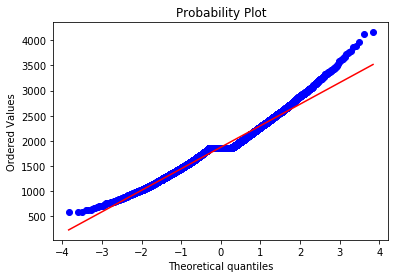

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4483
Kurtosis: 1.0916
Overview of variable:  wards 


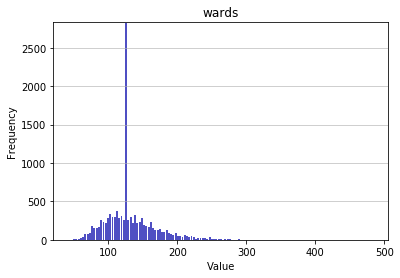

-------------------- 
Summary statistics:
 --------------------
Minimum value: 42.0
Mean: 131.913
Standard deviation: 37.4365
Median: 127.0
Maximal value: 484.0


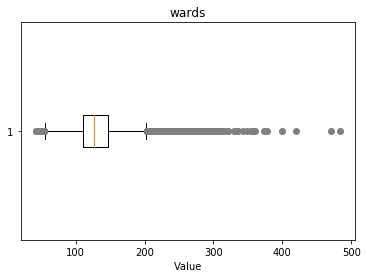

-------------------- 
Outlier detection:
 --------------------
List of outliers: {256.0, 258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 266.0, 268.0, 269.0, 270.0, 271.0, 400.0, 273.0, 274.0, 275.0, 272.0, 279.0, 282.0, 284.0, 285.0, 287.0, 288.0, 289.0, 290.0, 291.0, 420.0, 295.0, 298.0, 300.0, 301.0, 302.0, 303.0, 304.0, 308.0, 309.0, 310.0, 312.0, 314.0, 315.0, 321.0, 330.0, 334.0, 335.0, 343.0, 471.0, 374.0, 349.0, 354.0, 484.0, 358.0, 361.0, 378.0, 245.0, 246.0, 247.0, 248.0, 249.0, 250.0, 251.0, 252.0, 253.0, 254.0, 255.0}


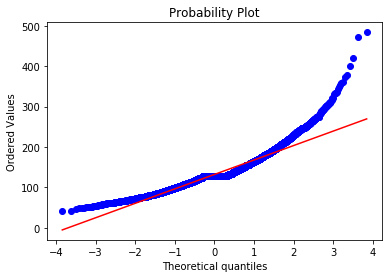

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.3708
Kurtosis: 4.5517
Overview of variable:  wpm 


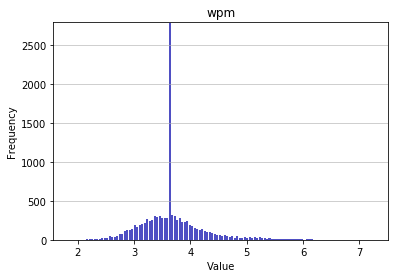

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.8391959798994977
Mean: 3.6775
Standard deviation: 0.5698
Median: 3.619
Maximal value: 7.245101959216314


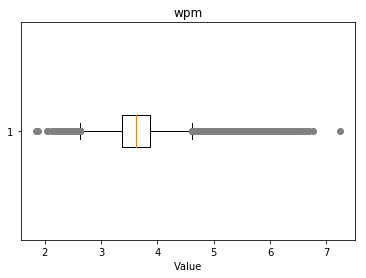

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1.88, 1.84, 5.53, 5.75, 5.5, 5.78, 6.64, 5.93, 6.59, 6.57, 5.66, 5.43, 6.1, 7.25, 5.57, 5.82, 6.43, 6.07, 6.0, 6.25, 6.32, 5.59, 5.61, 5.54, 5.86, 5.72, 5.97, 6.04, 6.54, 6.36, 5.47, 5.79, 5.76, 5.4, 5.65, 5.9, 5.83, 6.4, 6.76, 5.58, 5.51, 5.8, 5.62, 5.87, 5.44, 5.94, 6.3, 6.44, 6.12, 5.55, 6.19, 5.52, 5.98, 5.77, 5.41, 5.48, 6.09, 6.16, 6.02, 6.48, 5.84, 5.81, 5.56, 5.88, 5.45, 5.63, 6.06, 6.2, 5.95, 5.7, 6.63, 6.7, 5.99, 5.6, 5.49, 5.85, 5.92, 6.24, 6.17, 5.67, 5.42, 5.74, 5.71, 5.64, 5.96, 5.89, 5.39, 6.03, 6.46, 6.53, 5.46, 6.14}


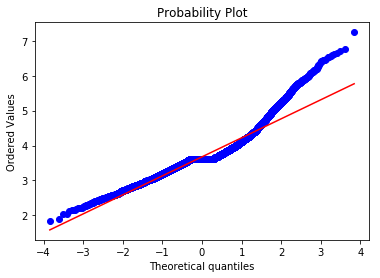

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1918
Kurtosis: 3.1592
Overview of variable:  wardshare 


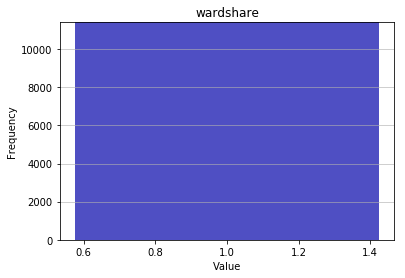

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.0
Mean: 1.0
Standard deviation: 0.0
Median: 1.0
Maximal value: 1.0


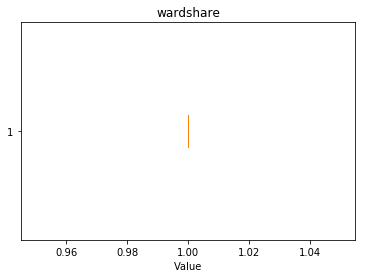

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


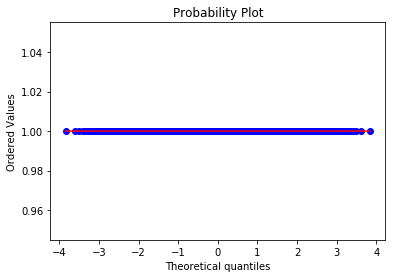

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -3.0
Overview of variable:  wardkills 


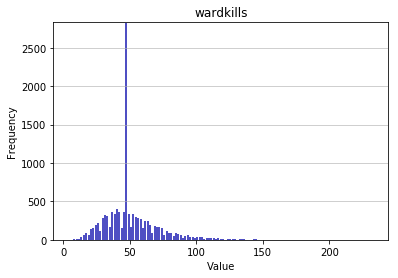

-------------------- 
Summary statistics:
 --------------------
Minimum value: 4.0
Mean: 50.9089
Standard deviation: 19.8234
Median: 48.0
Maximal value: 233.0


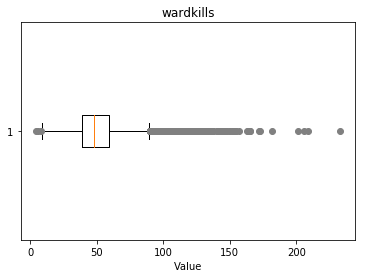

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 140.0, 142.0, 144.0, 145.0, 146.0, 147.0, 149.0, 150.0, 152.0, 153.0, 154.0, 155.0, 157.0, 163.0, 164.0, 165.0, 172.0, 173.0, 182.0, 201.0, 206.0, 209.0, 233.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0}


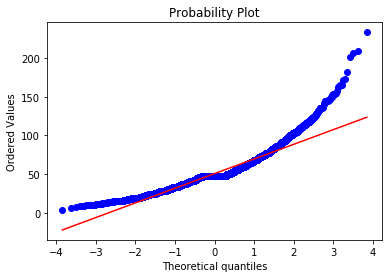

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.4174
Kurtosis: 4.5256
Overview of variable:  wcpm 


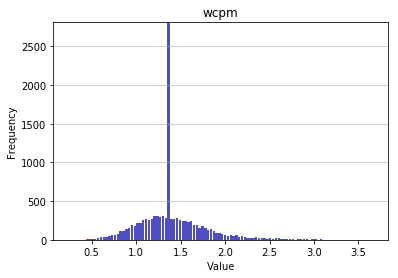

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.23715415019762845
Mean: 1.4025
Standard deviation: 0.3712
Median: 1.3667
Maximal value: 3.6673773987206824


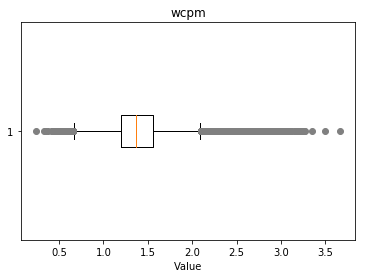

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.24, 2.91, 2.57, 2.55, 3.67, 2.69, 3.17, 2.81, 2.85, 2.53, 2.93, 3.21, 2.84, 2.75, 2.59, 2.58, 3.16, 3.0, 2.74, 3.25, 2.66, 3.08, 3.01, 3.24, 3.5, 2.67, 2.99, 2.71, 2.82, 2.61, 2.68, 2.77, 2.52, 2.86, 3.02, 3.1, 3.11, 3.03, 2.6, 3.27, 3.35, 2.89, 2.62, 2.7, 2.88, 2.54, 2.79, 3.05, 2.96, 2.8, 2.87, 2.76, 3.12, 2.72, 2.83, 3.26, 2.73, 2.65, 2.97, 2.9, 2.56, 3.15, 3.07, 3.06, 2.98, 2.64}


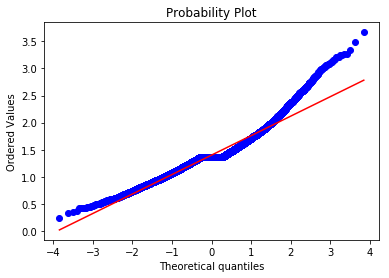

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9758
Kurtosis: 2.5639
Overview of variable:  visionwards 


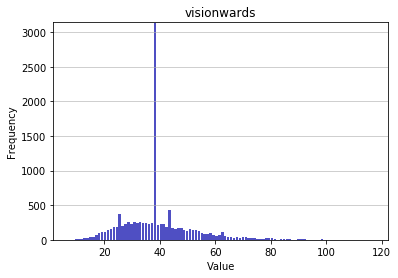

-------------------- 
Summary statistics:
 --------------------
Minimum value: 7.0
Mean: 39.2735
Standard deviation: 12.8967
Median: 38.0
Maximal value: 117.0


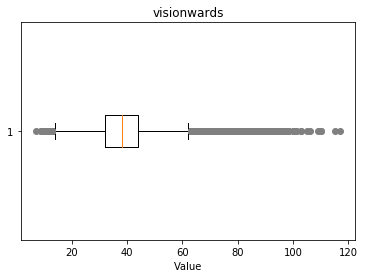

-------------------- 
Outlier detection:
 --------------------
List of outliers: {78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 100.0, 101.0, 103.0, 105.0, 106.0, 109.0, 110.0, 115.0, 117.0}


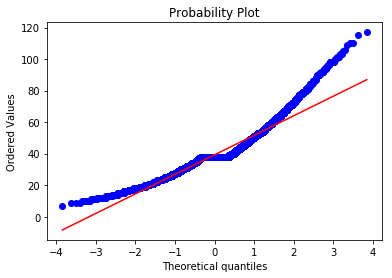

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0913
Kurtosis: 2.5406
Overview of variable:  visionwardbuys 


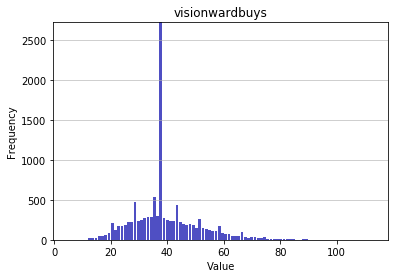

-------------------- 
Summary statistics:
 --------------------
Minimum value: 5.0
Mean: 39.5504
Standard deviation: 11.9742
Median: 38.0
Maximal value: 113.0


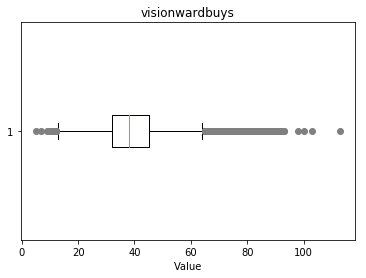

-------------------- 
Outlier detection:
 --------------------
List of outliers: {76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 98.0, 100.0, 103.0, 113.0}


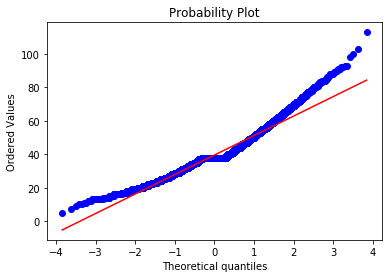

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.851
Kurtosis: 1.4777
Overview of variable:  visiblewardclearrate 


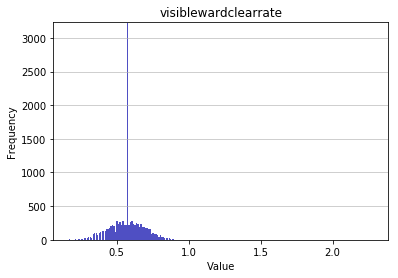

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.16666666666666666
Mean: 0.5705
Standard deviation: 0.1165
Median: 0.5714
Maximal value: 2.282051282051282


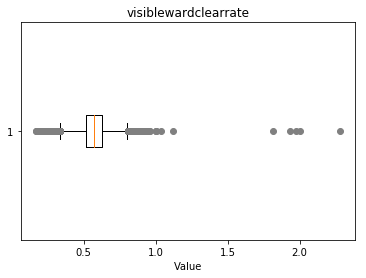

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.93, 1.0, 0.94, 0.2, 0.19, 1.04, 1.81, 1.12, 0.96, 1.98, 2.28, 2.0, 0.17, 0.92, 0.95, 0.22, 1.93, 0.21}


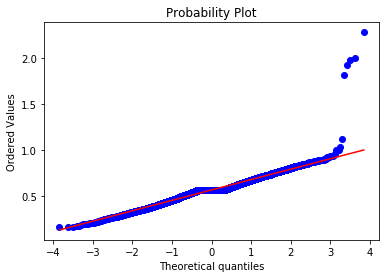

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7863
Kurtosis: 10.8741
Overview of variable:  invisiblewardclearrate 


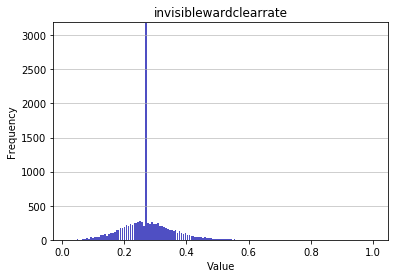

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.02127659574468085
Mean: 0.2734
Standard deviation: 0.0747
Median: 0.2701
Maximal value: 1.0


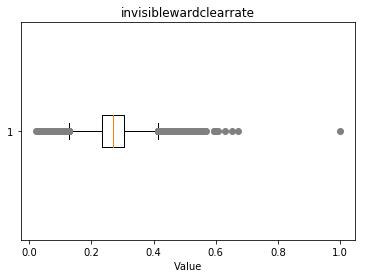

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.5, 0.55, 0.51, 0.05, 0.6, 0.54, 0.67, 0.52, 0.59, 0.53, 0.56, 0.63, 0.61, 0.65, 0.57, 0.03, 0.04, 0.02, 1.0}


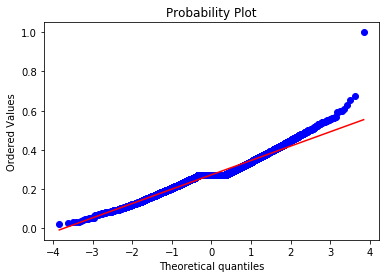

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4776
Kurtosis: 2.0239
Overview of variable:  totalgold 


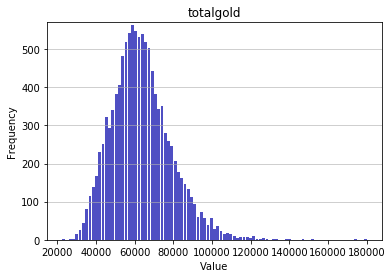

-------------------- 
Summary statistics:
 --------------------
Minimum value: 22524.0
Mean: 63527.6338
Standard deviation: 15308.2547
Median: 62170.0
Maximal value: 180057.0


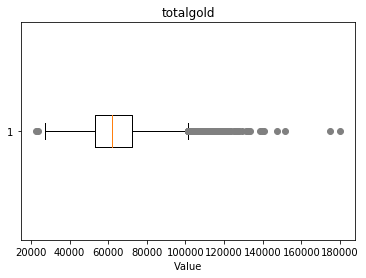

-------------------- 
Outlier detection:
 --------------------
List of outliers: {115202.0, 122500.0, 131205.0, 115719.0, 109705.0, 109962.0, 120203.0, 120590.0, 121487.0, 118800.0, 113680.0, 115216.0, 120851.0, 113300.0, 115091.0, 112276.0, 112660.0, 127385.0, 115616.0, 109600.0, 112162.0, 110114.0, 139556.0, 122273.0, 117800.0, 140842.0, 116908.0, 110382.0, 109743.0, 117808.0, 119601.0, 109750.0, 126135.0, 125625.0, 121146.0, 110266.0, 151354.0, 147262.0, 121538.0, 115908.0, 118984.0, 123595.0, 111821.0, 114382.0, 109903.0, 116176.0, 120145.0, 116558.0, 121300.0, 132564.0, 120533.0, 127447.0, 138324.0, 180057.0, 115418.0, 114651.0, 116700.0, 110430.0, 120800.0, 129121.0, 111200.0, 110435.0, 124900.0, 113120.0, 111206.0, 121443.0, 118761.0, 132329.0, 174571.0, 110700.0, 120813.0, 110701.0, 126447.0, 117614.0, 117613.0, 116336.0, 133237.0, 111606.0, 113271.0, 117238.0, 112246.0, 112509.0}


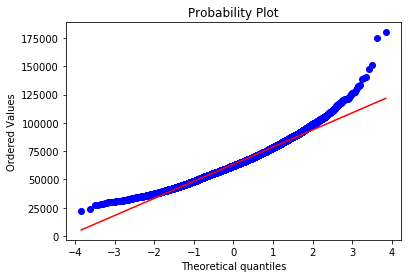

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7011
Kurtosis: 1.3287
Overview of variable:  earnedgpm 


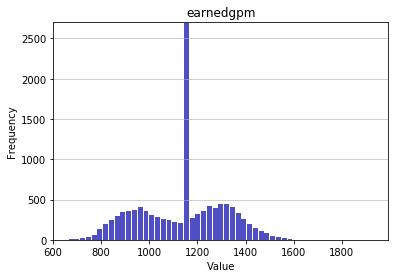

-------------------- 
Summary statistics:
 --------------------
Minimum value: 663.4919748778785
Mean: 1138.3167
Standard deviation: 176.1525
Median: 1151.7802
Maximal value: 1931.5423983943804


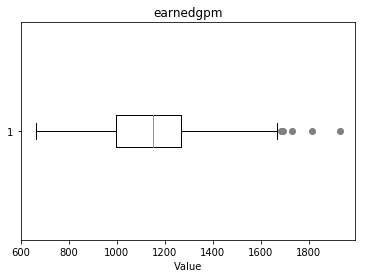

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1729.82, 1931.54, 1684.0, 1816.2, 1691.99}


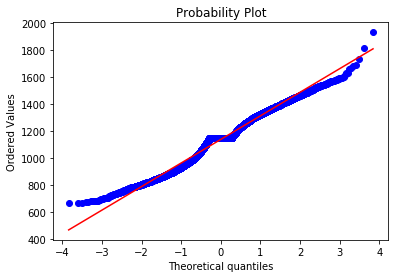

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0967
Kurtosis: -0.5136
Overview of variable:  goldspent 


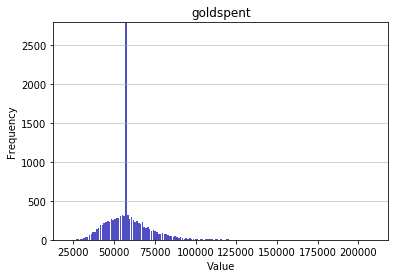

-------------------- 
Summary statistics:
 --------------------
Minimum value: 22035.0
Mean: 58470.2079
Standard deviation: 13140.9576
Median: 57180.5
Maximal value: 209091.0


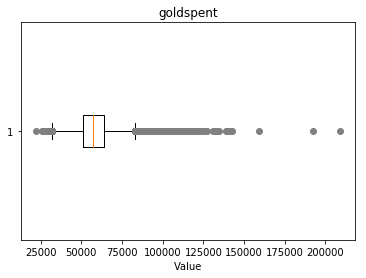

-------------------- 
Outlier detection:
 --------------------
List of outliers: {105985.0, 109575.0, 98835.0, 119320.0, 101913.0, 117275.0, 98845.0, 139805.0, 108580.0, 127023.0, 107060.0, 101440.0, 99393.0, 106053.0, 115270.0, 132680.0, 105545.0, 98890.0, 99403.0, 100435.0, 98900.0, 115285.0, 131667.0, 119383.0, 109660.0, 192101.0, 97893.0, 102395.0, 122985.0, 113770.0, 103020.0, 109678.0, 104558.0, 110198.0, 112759.0, 98425.0, 98943.0, 118915.0, 103050.0, 134796.0, 97933.0, 115858.0, 111260.0, 101538.0, 98475.0, 99500.0, 99499.0, 118450.0, 101043.0, 104626.0, 117435.0, 107709.0, 209091.0, 108760.0, 99550.0, 112863.0, 112358.0, 115430.0, 106217.0, 158958.0, 138993.0, 139513.0, 125690.0, 123131.0, 99068.0, 111876.0, 119566.0, 103695.0, 99600.0, 103185.0, 112401.0, 121625.0, 120603.0, 110878.0, 106283.0, 107830.0, 101183.0, 121158.0, 100168.0, 115020.0, 115533.0, 132430.0, 112975.0, 116048.0, 104270.0, 107860.0, 103258.0, 104283.0, 99163.0, 101213.0, 101215.0, 107872.0, 110435.0, 11299

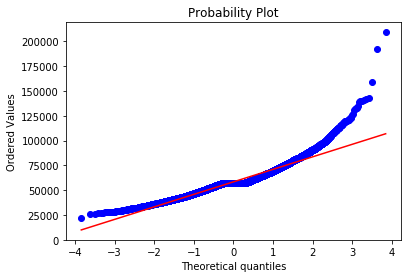

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.3216
Kurtosis: 5.6475
Overview of variable:  gspd 


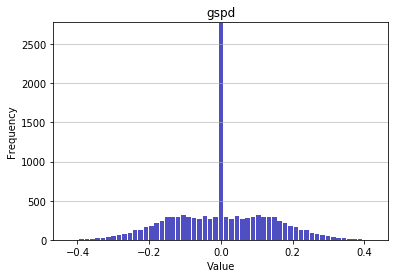

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.42565770026603605
Mean: 0.0
Standard deviation: 0.1319
Median: 0.0
Maximal value: 0.42565770026603605


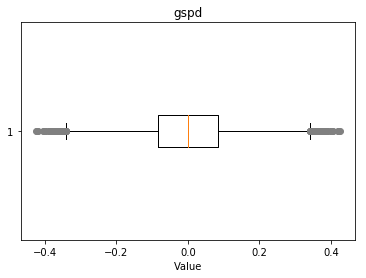

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-0.41, -0.4, 0.41, 0.42, -0.42, 0.4, -0.43, 0.43}


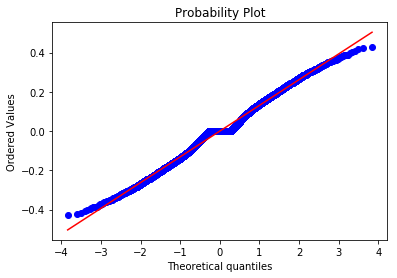

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -0.0087
Overview of variable:  minionkills 


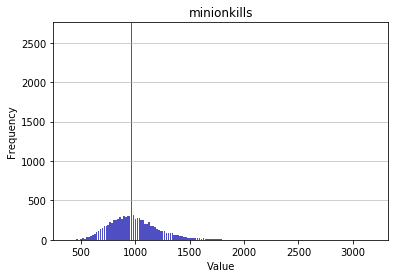

-------------------- 
Summary statistics:
 --------------------
Minimum value: 385.0
Mean: 983.6972
Standard deviation: 203.3424
Median: 967.0
Maximal value: 3188.0


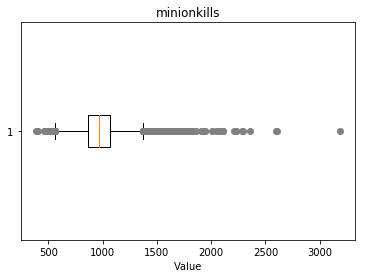

-------------------- 
Outlier detection:
 --------------------
List of outliers: {2069.0, 2082.0, 2596.0, 2602.0, 1594.0, 1597.0, 2110.0, 1599.0, 2112.0, 1601.0, 1598.0, 1603.0, 1607.0, 1608.0, 1611.0, 1612.0, 1613.0, 1615.0, 1617.0, 1618.0, 1619.0, 1620.0, 1621.0, 1623.0, 1625.0, 1627.0, 1628.0, 1631.0, 1632.0, 1633.0, 1638.0, 1643.0, 1644.0, 1648.0, 1649.0, 1650.0, 3188.0, 1652.0, 1655.0, 1657.0, 1666.0, 1672.0, 1678.0, 1682.0, 1688.0, 1689.0, 1692.0, 2206.0, 1695.0, 1705.0, 1708.0, 1709.0, 1710.0, 1711.0, 1713.0, 2228.0, 2230.0, 1719.0, 1718.0, 1726.0, 1731.0, 1735.0, 1747.0, 1750.0, 1753.0, 1754.0, 1755.0, 1758.0, 1760.0, 1763.0, 1767.0, 2280.0, 1773.0, 1775.0, 2290.0, 1779.0, 1785.0, 1793.0, 1794.0, 1804.0, 1806.0, 1813.0, 1834.0, 2355.0, 1860.0, 1910.0, 1938.0, 1940.0, 1941.0, 2007.0, 2042.0}


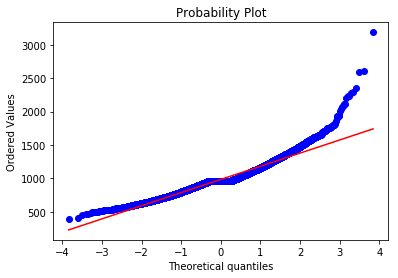

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.055
Kurtosis: 4.0779
Overview of variable:  monsterkills 


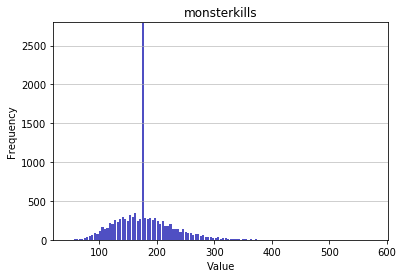

-------------------- 
Summary statistics:
 --------------------
Minimum value: 47.0
Mean: 178.5405
Standard deviation: 47.2608
Median: 175.0
Maximal value: 576.0


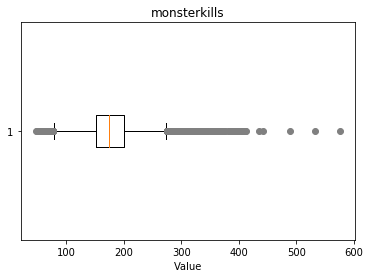

-------------------- 
Outlier detection:
 --------------------
List of outliers: {386.0, 387.0, 389.0, 393.0, 394.0, 398.0, 400.0, 405.0, 533.0, 406.0, 409.0, 411.0, 412.0, 435.0, 442.0, 576.0, 321.0, 322.0, 323.0, 324.0, 325.0, 326.0, 327.0, 328.0, 329.0, 330.0, 331.0, 332.0, 333.0, 335.0, 336.0, 339.0, 340.0, 341.0, 342.0, 344.0, 345.0, 349.0, 352.0, 353.0, 354.0, 356.0, 357.0, 488.0, 362.0, 363.0, 366.0, 368.0, 370.0, 373.0, 374.0, 375.0, 381.0, 383.0}


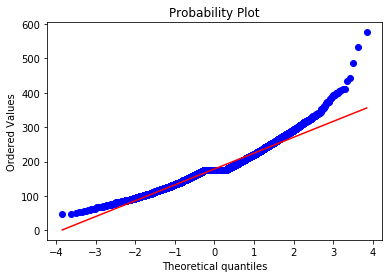

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8255
Kurtosis: 2.2787
Overview of variable:  monsterkillsownjungle 


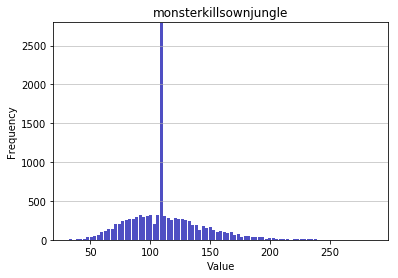

-------------------- 
Summary statistics:
 --------------------
Minimum value: 32.0
Mean: 113.0321
Standard deviation: 30.6294
Median: 110.0
Maximal value: 286.0


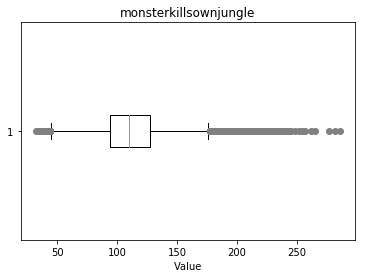

-------------------- 
Outlier detection:
 --------------------
List of outliers: {257.0, 262.0, 265.0, 277.0, 282.0, 286.0, 205.0, 206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 218.0, 219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 232.0, 233.0, 234.0, 236.0, 237.0, 238.0, 239.0, 241.0, 243.0, 245.0, 248.0, 252.0, 254.0}


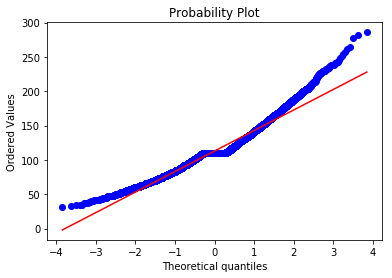

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7917
Kurtosis: 1.4841
Overview of variable:  monsterkillsenemyjungle 


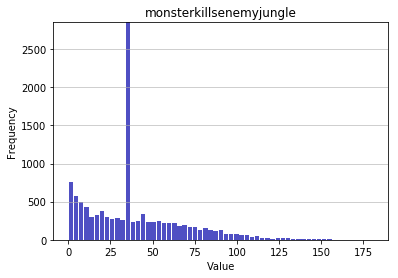

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 38.7016
Standard deviation: 28.4095
Median: 34.0
Maximal value: 181.0


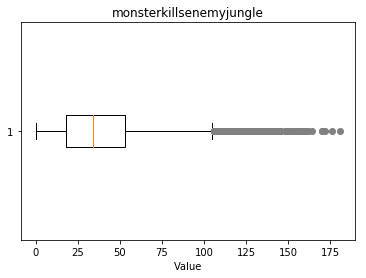

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 148.0, 149.0, 150.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 162.0, 164.0, 170.0, 172.0, 176.0, 181.0, 124.0, 125.0, 126.0, 127.0}


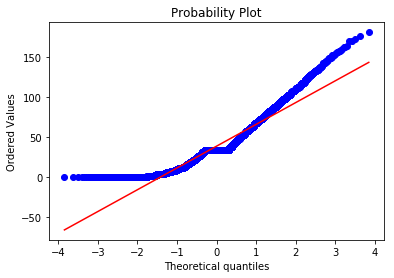

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0421
Kurtosis: 1.1718
Overview of variable:  cspm 


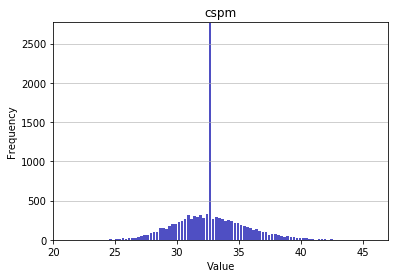

-------------------- 
Summary statistics:
 --------------------
Minimum value: 21.239288068556363
Mean: 32.6793
Standard deviation: 2.6761
Median: 32.543
Maximal value: 45.850476668339184


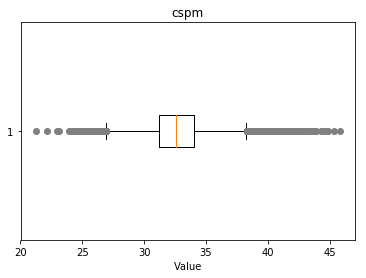

-------------------- 
Outlier detection:
 --------------------
List of outliers: {41.39, 21.24, 22.98, 23.9, 24.64, 24.14, 24.37, 24.56, 24.06, 22.15, 24.31, 24.22, 41.76, 41.01, 41.38, 42.56, 40.91, 41.7, 42.78, 43.56, 41.69, 45.85, 41.51, 40.84, 41.87, 42.82, 45.38, 42.32, 44.64, 44.41, 40.97, 42.93, 40.8, 41.9, 41.02, 40.95, 40.79, 41.03, 41.97, 40.93, 41.16, 41.77, 41.71, 41.75, 41.88, 42.06, 42.43, 42.7, 41.46, 42.51, 43.24, 43.34, 43.14, 42.19, 43.76, 44.91, 44.33, 43.91, 41.54, 43.44, 41.55, 23.1, 40.86, 24.3}


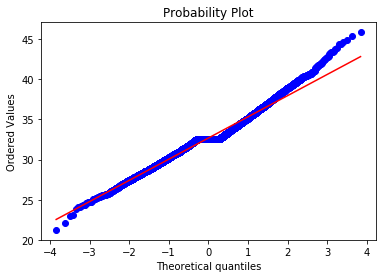

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3571
Kurtosis: 1.0656
Overview of variable:  goldat10 


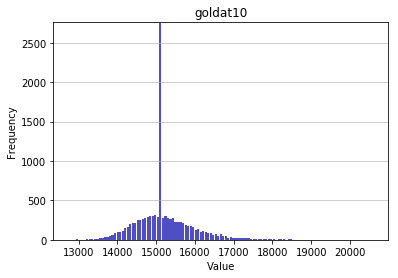

-------------------- 
Summary statistics:
 --------------------
Minimum value: 12737.0
Mean: 15207.6216
Standard deviation: 747.9199
Median: 15139.0
Maximal value: 20599.0


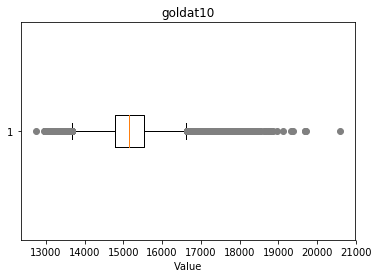

-------------------- 
Outlier detection:
 --------------------
List of outliers: {18453.0, 18965.0, 17947.0, 18470.0, 17455.0, 17460.0, 17465.0, 17978.0, 17977.0, 17471.0, 18497.0, 18498.0, 17991.0, 17480.0, 17481.0, 17489.0, 18515.0, 18003.0, 18006.0, 17496.0, 17497.0, 17499.0, 17504.0, 17505.0, 18018.0, 17511.0, 17517.0, 18033.0, 17523.0, 18038.0, 20599.0, 17528.0, 17540.0, 18564.0, 18058.0, 17554.0, 17555.0, 12957.0, 18077.0, 17568.0, 17570.0, 12962.0, 17573.0, 18086.0, 17579.0, 17581.0, 17582.0, 17585.0, 17587.0, 19129.0, 17598.0, 17599.0, 18111.0, 17607.0, 18644.0, 17620.0, 17621.0, 17623.0, 18136.0, 17627.0, 17628.0, 19678.0, 18656.0, 18144.0, 18148.0, 17640.0, 18155.0, 17645.0, 19701.0, 17654.0, 17660.0, 18175.0, 17666.0, 19716.0, 17669.0, 18182.0, 18696.0, 17679.0, 17697.0, 17704.0, 18219.0, 17707.0, 17709.0, 18222.0, 17711.0, 18736.0, 17721.0, 17728.0, 17735.0, 18251.0, 17740.0, 17741.0, 18255.0, 17747.0, 17753.0, 18784.0, 18277.0, 17767.0, 17778.0, 18298.0, 18299.0, 17786.0, 

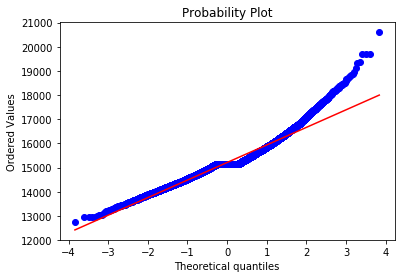

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9151
Kurtosis: 2.5571
Overview of variable:  gdat10 


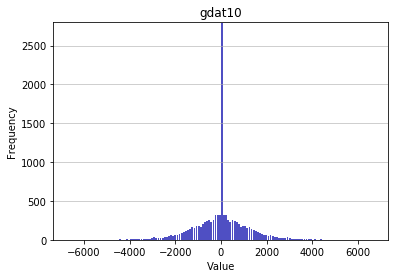

-------------------- 
Summary statistics:
 --------------------
Minimum value: -6674.0
Mean: 0.0
Standard deviation: 1136.9347
Median: 0.0
Maximal value: 6674.0


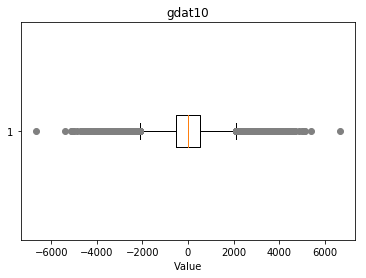

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4096.0, -4096.0, -4093.0, 5133.0, 3599.0, -3568.0, -4592.0, 6674.0, 4117.0, -3561.0, -3548.0, -5080.0, -3543.0, 3625.0, -4562.0, 3631.0, 3635.0, 4157.0, -4034.0, 4671.0, 3647.0, -4030.0, -3517.0, 3650.0, -4533.0, 3664.0, -5033.0, -3497.0, -3488.0, 4706.0, -3485.0, -3483.0, 3687.0, 4711.0, -4503.0, -5012.0, -3981.0, 3699.0, -3465.0, -3462.0, 3706.0, -3450.0, -3959.0, -3955.0, 4246.0, -3944.0, -3939.0, -3938.0, 3749.0, -4436.0, -4432.0, 3765.0, -3915.0, -3907.0, 3776.0, -3901.0, -4412.0, 3782.0, 3789.0, -3877.0, 3810.0, -3869.0, 4324.0, -3860.0, 3821.0, -4370.0, -5394.0, -3856.0, -3859.0, 3828.0, -3842.0, -4866.0, 3839.0, -3839.0, 4866.0, 3842.0, -3828.0, 3856.0, 4370.0, -3821.0, 3860.0, 5394.0, 3859.0, -4324.0, 3869.0, -3810.0, 3877.0, -3789.0, -3782.0, 4412.0, 3901.0, -3776.0, 3907.0, -3765.0, 3915.0, 4432.0, 4436.0, -3749.0, 3938.0, 3939.0, 3944.0, -4246.0, 3955.0, 3959.0, 3450.0, -3706.0, 3462.0, 3465.0

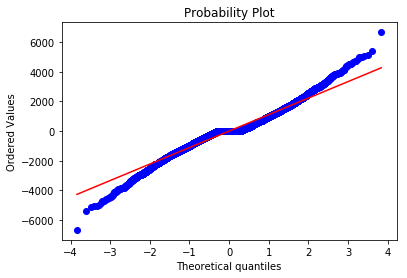

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 2.0958
Overview of variable:  goldat15 


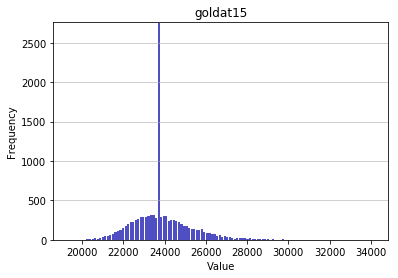

-------------------- 
Summary statistics:
 --------------------
Minimum value: 19336.0
Mean: 23843.3407
Standard deviation: 1351.6795
Median: 23728.0
Maximal value: 34121.0


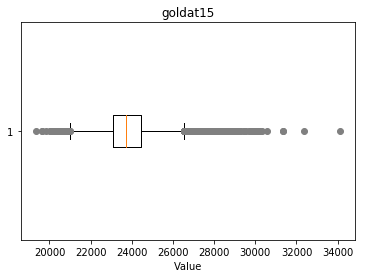

-------------------- 
Outlier detection:
 --------------------
List of outliers: {28160.0, 28161.0, 28163.0, 28679.0, 28680.0, 28173.0, 29198.0, 28174.0, 28178.0, 29716.0, 30228.0, 28181.0, 29209.0, 28698.0, 28699.0, 29215.0, 28193.0, 28197.0, 29749.0, 29772.0, 28756.0, 28255.0, 32356.0, 31333.0, 28776.0, 29801.0, 31338.0, 28275.0, 28285.0, 29312.0, 28291.0, 28806.0, 29831.0, 30344.0, 28298.0, 29838.0, 28817.0, 29844.0, 28316.0, 28834.0, 28325.0, 28332.0, 19633.0, 28340.0, 28342.0, 28873.0, 19657.0, 28365.0, 28884.0, 28390.0, 28395.0, 29426.0, 27905.0, 28930.0, 29442.0, 28417.0, 27933.0, 28453.0, 27942.0, 29991.0, 27944.0, 27943.0, 27948.0, 28461.0, 28466.0, 27959.0, 27961.0, 28986.0, 29001.0, 34121.0, 27979.0, 29010.0, 28498.0, 30039.0, 27993.0, 27996.0, 28004.0, 30566.0, 28008.0, 29545.0, 28013.0, 28014.0, 29037.0, 28016.0, 28525.0, 28018.0, 29052.0, 28034.0, 19336.0, 29065.0, 28553.0, 29067.0, 28560.0, 28049.0, 28563.0, 28573.0, 28574.0, 28061.0, 30114.0, 28073.0, 28078.0, 28596.0, 

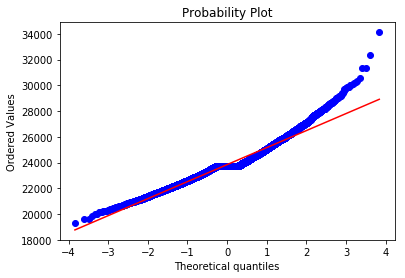

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7777
Kurtosis: 1.992
Overview of variable:  gdat15 


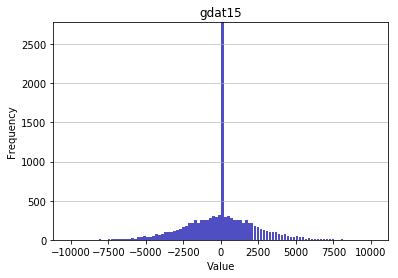

-------------------- 
Summary statistics:
 --------------------
Minimum value: -10163.0
Mean: 0.0
Standard deviation: 2232.1382
Median: 0.0
Maximal value: 10163.0


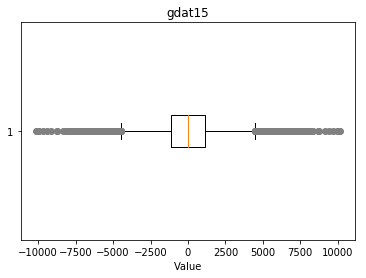

-------------------- 
Outlier detection:
 --------------------
List of outliers: {7169.0, 8716.0, -7154.0, -7662.0, -7150.0, -8168.0, 8741.0, 7217.0, -9678.0, 6707.0, -7116.0, -8141.0, 6723.0, 7754.0, -10163.0, 7249.0, 6741.0, 6745.0, 6749.0, 7261.0, -9120.0, -7064.0, -7058.0, 6769.0, 6776.0, -7046.0, 7292.0, 8326.0, 7305.0, -10097.0, 6801.0, -7015.0, 6810.0, -8035.0, 7327.0, 6825.0, -8021.0, 9388.0, -7507.0, 7343.0, 7344.0, 6831.0, -6984.0, 7868.0, 6846.0, 7875.0, 7380.0, 6878.0, 7390.0, -6940.0, -7449.0, -6936.0, 7415.0, 9976.0, 7417.0, -7417.0, -9976.0, -7415.0, 6936.0, 7449.0, 6940.0, -6878.0, -7390.0, -7380.0, -7875.0, -6846.0, -7868.0, 6984.0, -7344.0, -7343.0, -6831.0, 7507.0, -9388.0, 8021.0, -6825.0, -7327.0, 8035.0, -6810.0, 7015.0, -6801.0, 10097.0, -7305.0, -8326.0, -7292.0, 7046.0, -6776.0, -6769.0, 7058.0, 7064.0, 9120.0, -6749.0, -7261.0, -6745.0, -6741.0, -7249.0, 10163.0, -7754.0, -6723.0, 7116.0, -6707.0, 9678.0, -7217.0, 8141.0, -8741.0, 8168.0, 7662.0, 7150.0, 7154.

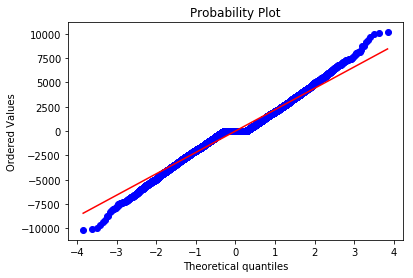

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.3293
Overview of variable:  xpat10 


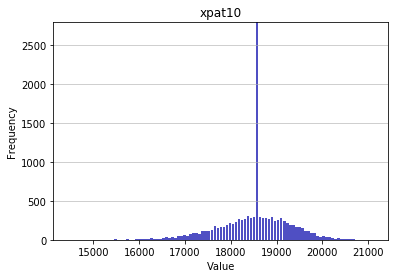

-------------------- 
Summary statistics:
 --------------------
Minimum value: 14456.0
Mean: 18510.0718
Standard deviation: 730.1925
Median: 18552.0
Maximal value: 21111.0


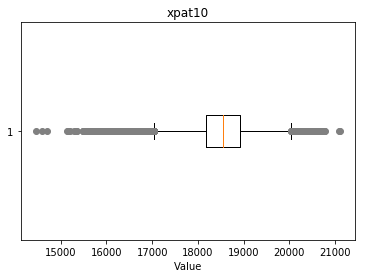

-------------------- 
Outlier detection:
 --------------------
List of outliers: {15873.0, 15367.0, 15880.0, 15890.0, 15915.0, 15918.0, 15924.0, 15939.0, 15957.0, 15960.0, 15962.0, 15973.0, 21094.0, 15976.0, 15982.0, 21111.0, 14456.0, 15483.0, 15999.0, 16004.0, 15495.0, 16008.0, 15496.0, 15501.0, 16016.0, 15508.0, 16029.0, 15519.0, 16031.0, 16050.0, 16051.0, 15559.0, 16078.0, 15568.0, 16100.0, 16101.0, 16106.0, 20715.0, 16116.0, 14590.0, 16135.0, 15626.0, 16144.0, 16145.0, 16148.0, 15128.0, 15641.0, 15644.0, 20767.0, 16162.0, 20784.0, 16191.0, 15169.0, 16201.0, 16206.0, 16216.0, 15715.0, 16227.0, 16231.0, 15208.0, 16235.0, 15724.0, 15727.0, 14704.0, 16241.0, 15730.0, 16240.0, 16248.0, 15737.0, 15741.0, 15743.0, 15745.0, 16258.0, 16259.0, 16261.0, 16263.0, 16264.0, 16266.0, 16267.0, 16268.0, 15758.0, 16272.0, 16277.0, 16279.0, 16281.0, 15774.0, 16292.0, 16293.0, 16307.0, 16308.0, 15286.0, 15804.0, 16319.0, 15824.0, 15339.0, 15343.0}


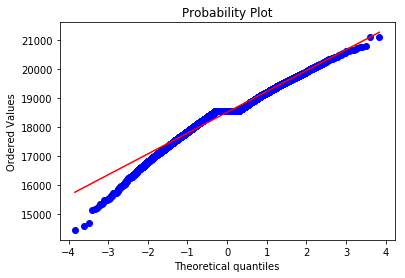

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.5319
Kurtosis: 1.4105
Overview of variable:  xpdat10 


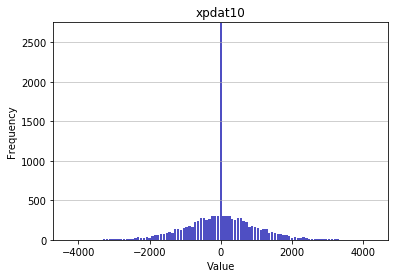

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4278.0
Mean: 0.0
Standard deviation: 913.943
Median: 0.0
Maximal value: 4278.0


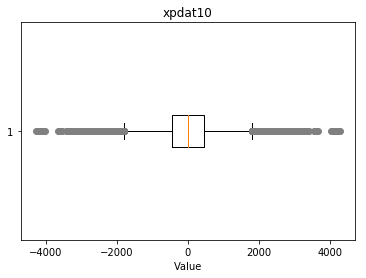

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-3584.0, 3584.0, 3586.0, 3078.0, -4088.0, -3572.0, -3058.0, -3044.0, -3040.0, -3039.0, -3552.0, -3030.0, 3115.0, -3026.0, 4145.0, 3131.0, 3651.0, 4168.0, 3146.0, -2995.0, -4019.0, 3150.0, 3153.0, 3155.0, -2988.0, 3165.0, 3176.0, -2963.0, -2960.0, 4211.0, 3189.0, -2955.0, -2935.0, 3213.0, -2927.0, -2926.0, 3218.0, -3415.0, 3244.0, 3247.0, 4278.0, -2887.0, 2746.0, 3259.0, 2747.0, 2749.0, 3275.0, 2763.0, -2865.0, 2770.0, -2861.0, 2774.0, 2776.0, 2777.0, -2854.0, 2780.0, -2850.0, 2787.0, -2840.0, -3351.0, -3344.0, 2802.0, -3341.0, 2808.0, 2809.0, 2810.0, -2810.0, -2809.0, -2808.0, 3341.0, -2802.0, 3344.0, 3351.0, 2840.0, -2787.0, 2850.0, -2780.0, 2854.0, -2777.0, -2776.0, -2774.0, 2861.0, -2770.0, 2865.0, -3275.0, -2763.0, -2749.0, -3259.0, -2746.0, 2887.0, -2747.0, -4278.0, -3247.0, -3244.0, 3415.0, 2926.0, 2927.0, -3218.0, -3213.0, 2935.0, -3189.0, 2955.0, -4211.0, 2960.0, 2963.0, -3176.0, -3165.0, 2988.0, 

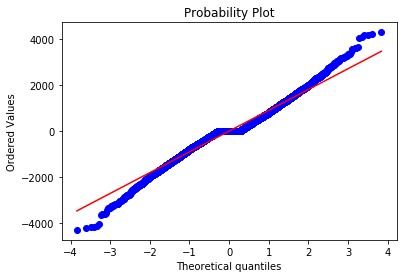

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.574
Overview of variable:  csat10 


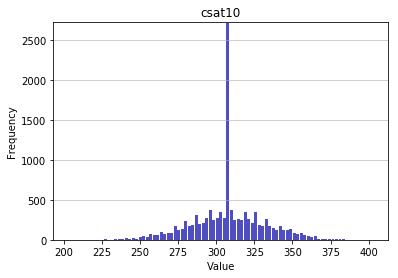

-------------------- 
Summary statistics:
 --------------------
Minimum value: 203.0
Mean: 308.1964
Standard deviation: 23.8404
Median: 308.0
Maximal value: 403.0


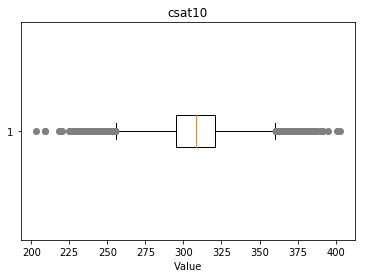

-------------------- 
Outlier detection:
 --------------------
List of outliers: {384.0, 385.0, 386.0, 387.0, 390.0, 391.0, 392.0, 395.0, 401.0, 403.0, 203.0, 209.0, 218.0, 219.0, 220.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 231.0, 233.0, 234.0, 235.0, 236.0, 380.0, 381.0, 382.0, 383.0}


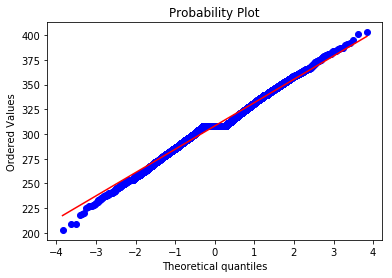

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0292
Kurtosis: 0.6728
Overview of variable:  csdat10 


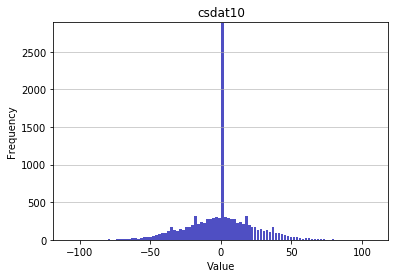

-------------------- 
Summary statistics:
 --------------------
Minimum value: -108.0
Mean: 0.0
Standard deviation: 23.1318
Median: 0.0
Maximal value: 108.0


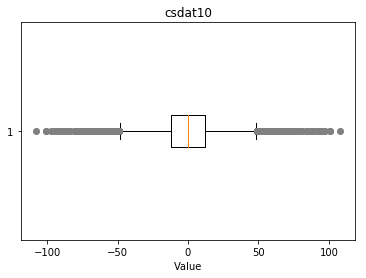

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-108.0, -101.0, -97.0, -95.0, -94.0, -93.0, -92.0, -90.0, -88.0, -87.0, -85.0, -84.0, -81.0, -80.0, -79.0, -77.0, -76.0, -75.0, -74.0, -73.0, -72.0, -71.0, -70.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 79.0, 80.0, 81.0, 84.0, 85.0, 87.0, 88.0, 90.0, 92.0, 93.0, 94.0, 95.0, 97.0, 101.0, 108.0}


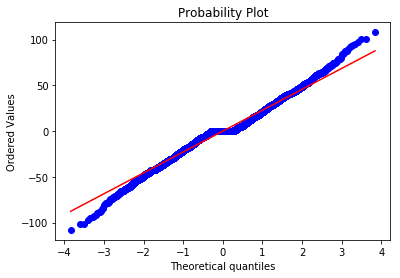

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.147
Overview of variable:  csat15 


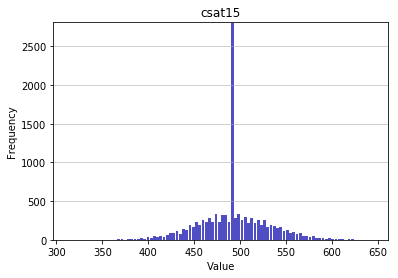

-------------------- 
Summary statistics:
 --------------------
Minimum value: 313.0
Mean: 492.7214
Standard deviation: 36.7738
Median: 492.0
Maximal value: 645.0


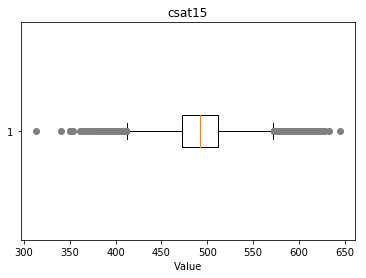

-------------------- 
Outlier detection:
 --------------------
List of outliers: {645.0, 615.0, 617.0, 313.0, 341.0, 373.0, 604.0, 606.0, 350.0, 608.0, 609.0, 354.0, 610.0, 612.0, 613.0, 611.0, 607.0, 616.0, 361.0, 618.0, 619.0, 620.0, 365.0, 366.0, 367.0, 368.0, 369.0, 370.0, 621.0, 372.0, 623.0, 622.0, 626.0, 376.0, 633.0, 378.0, 379.0, 380.0, 381.0, 629.0, 351.0}


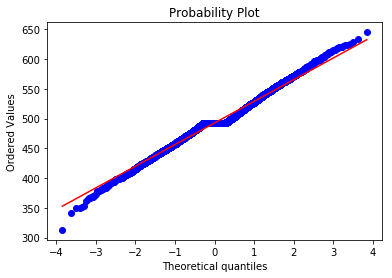

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0793
Kurtosis: 0.7325
Overview of variable:  csdat15 


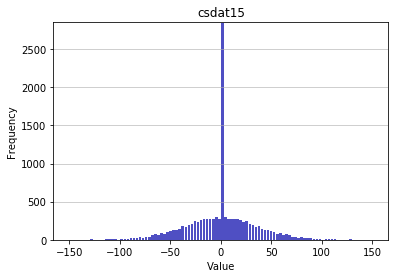

-------------------- 
Summary statistics:
 --------------------
Minimum value: -151.0
Mean: 0.0
Standard deviation: 33.5479
Median: 0.0
Maximal value: 151.0


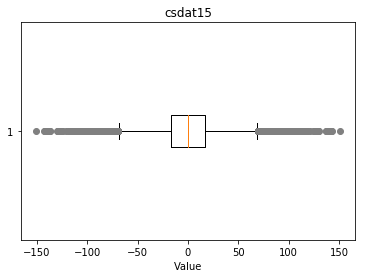

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, -128.0, 130.0, 129.0, -126.0, -124.0, -127.0, -121.0, 137.0, -118.0, 139.0, 140.0, -117.0, -114.0, -119.0, -112.0, -111.0, -110.0, 143.0, -108.0, -107.0, -106.0, -105.0, -104.0, -103.0, 151.0, -101.0, -109.0, -102.0, -151.0, -142.0, -116.0, 113.0, -113.0, 142.0, 119.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 127.0, 110.0, 111.0, 112.0, -143.0, 114.0, 109.0, -140.0, -139.0, 118.0, -137.0, 117.0, 121.0, 126.0, 116.0, 124.0, -130.0, -129.0}


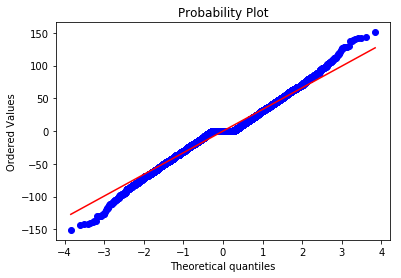

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.2454
Overview of variable:  datediff 


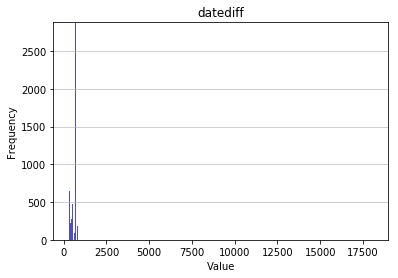

-------------------- 
Summary statistics:
 --------------------
Minimum value: 293.0
Mean: 645.8857
Standard deviation: 289.2192
Median: 697.0
Maximal value: 18089.0


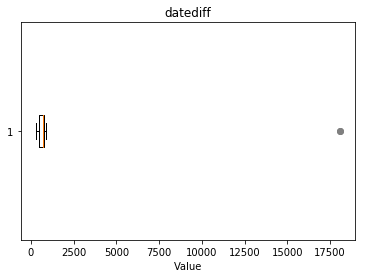

-------------------- 
Outlier detection:
 --------------------
List of outliers: {18089.0}


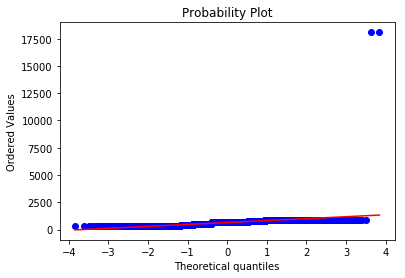

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 38.3899
Kurtosis: 2319.6972
Overview of variable:  Encoded_league 


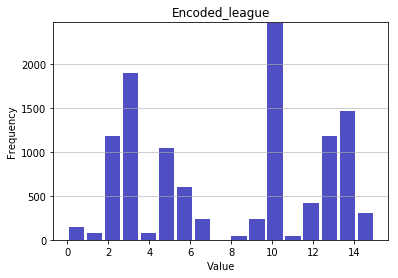

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 8.0432
Standard deviation: 4.4951
Median: 10.0
Maximal value: 15


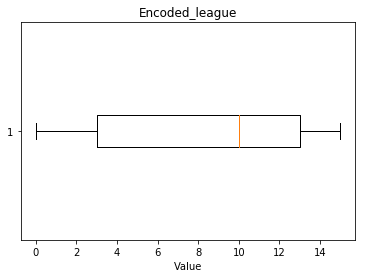

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


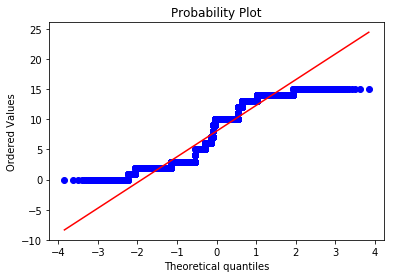

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0482
Kurtosis: -1.469
Overview of variable:  Encoded_game 


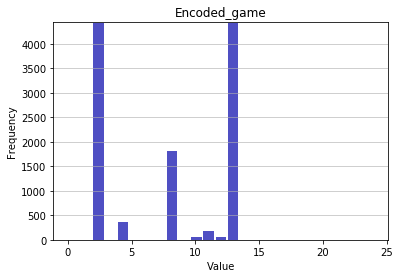

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 7.5909
Standard deviation: 4.9787
Median: 8.0
Maximal value: 24


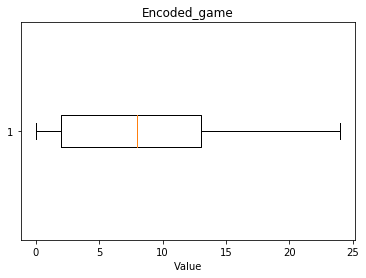

-------------------- 
Outlier detection:
 --------------------
List of outliers: {24, 23}


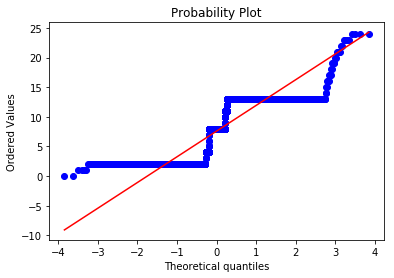

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0083
Kurtosis: -1.6878
Overview of variable:  Encoded_side 


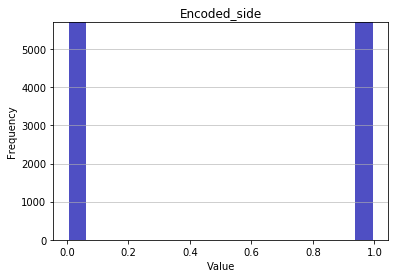

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.5
Standard deviation: 0.5
Median: 0.5
Maximal value: 1


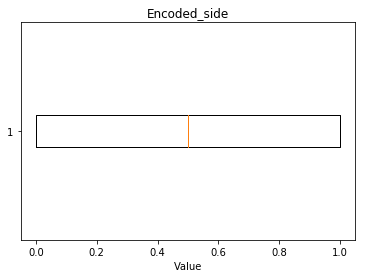

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


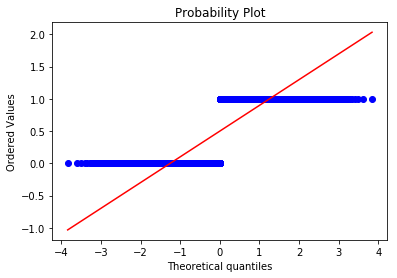

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_ban1 


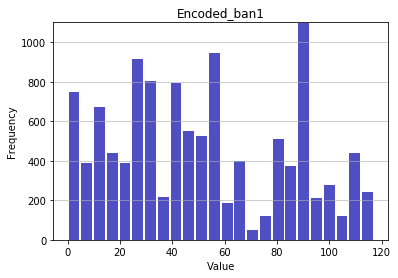

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 50.9126
Standard deviation: 32.4193
Median: 48.0
Maximal value: 117


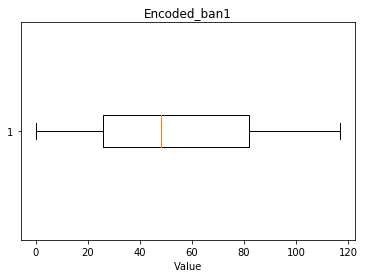

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


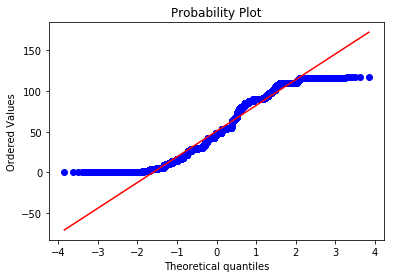

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2904
Kurtosis: -1.0247
Overview of variable:  Encoded_ban2 


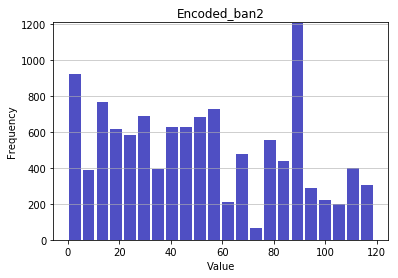

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 52.4151
Standard deviation: 33.7084
Median: 49.0
Maximal value: 119


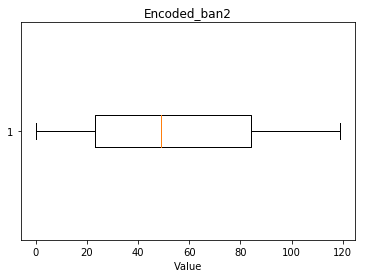

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


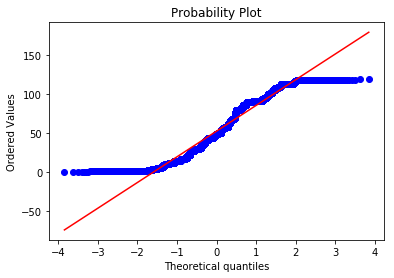

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2145
Kurtosis: -1.1231
Overview of variable:  Encoded_ban3 


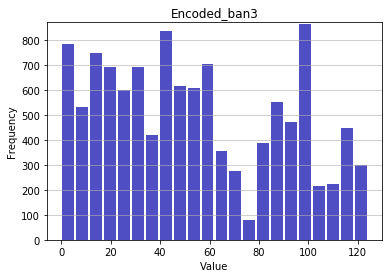

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 53.8068
Standard deviation: 35.0167
Median: 49.0
Maximal value: 124


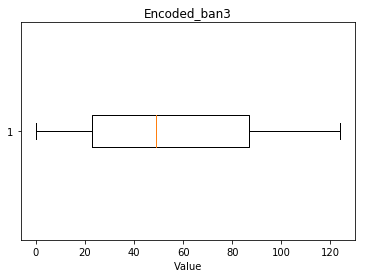

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


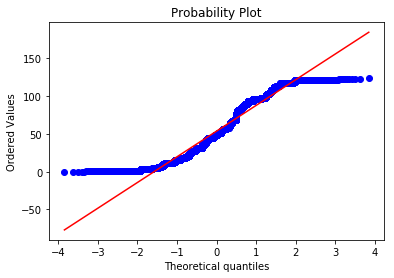

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2937
Kurtosis: -1.0833
Overview of variable:  Encoded_ban4 


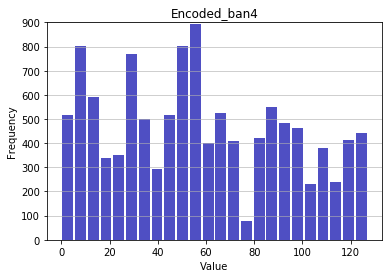

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 57.7344
Standard deviation: 36.0052
Median: 55.0
Maximal value: 127


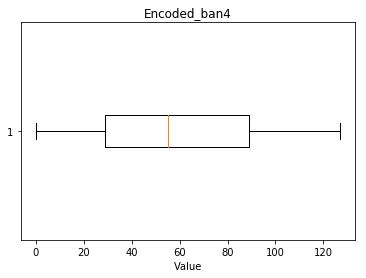

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


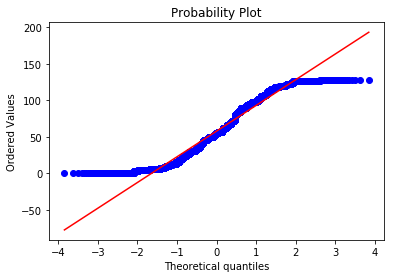

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2109
Kurtosis: -1.053
Overview of variable:  Encoded_ban5 


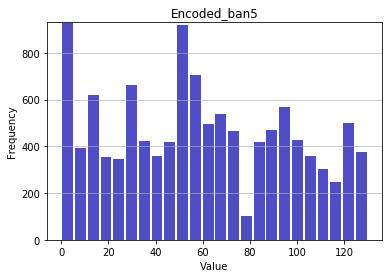

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 59.6393
Standard deviation: 37.133
Median: 58.0
Maximal value: 130


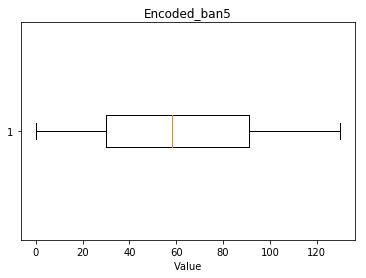

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


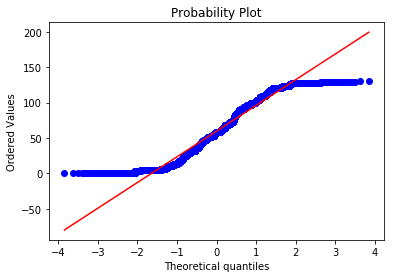

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1467
Kurtosis: -1.0724
Overview of variable:  Encoded_result 


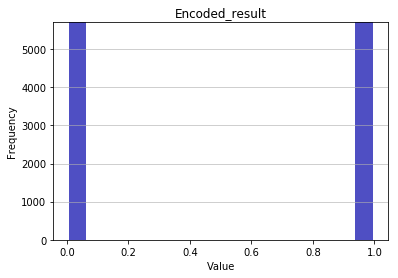

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.5
Standard deviation: 0.5
Median: 0.5
Maximal value: 1


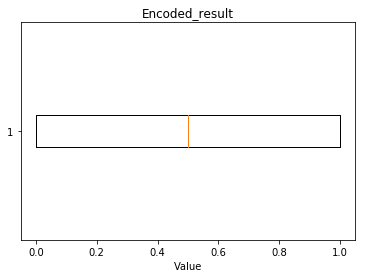

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


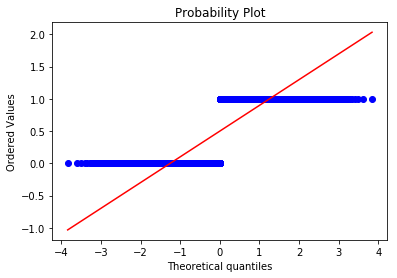

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_fb 


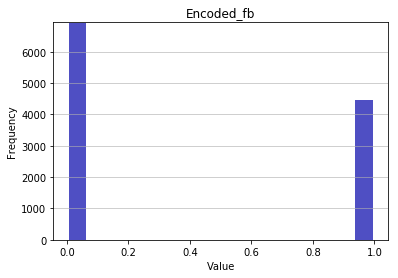

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.3918
Standard deviation: 0.4882
Median: 0.0
Maximal value: 1


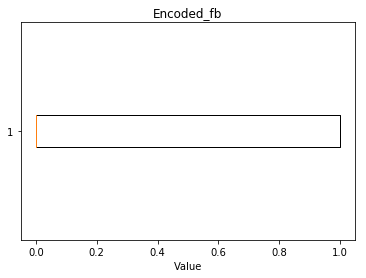

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


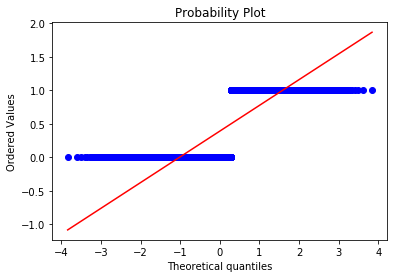

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4433
Kurtosis: -1.8035
Overview of variable:  Encoded_fbassist 


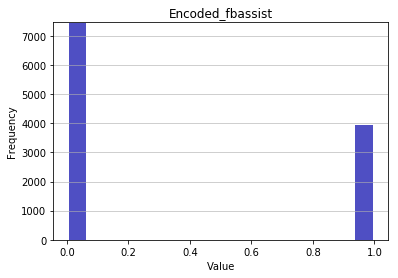

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3461
Standard deviation: 0.4757
Median: 0.0
Maximal value: 1.0


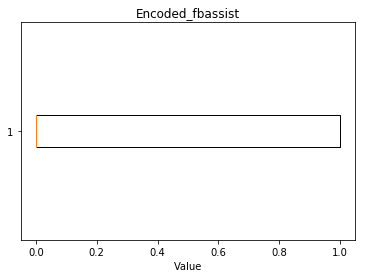

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


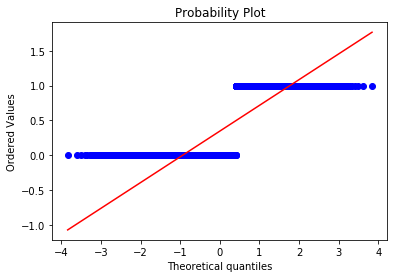

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6471
Kurtosis: -1.5813
Overview of variable:  Encoded_fbvictim 


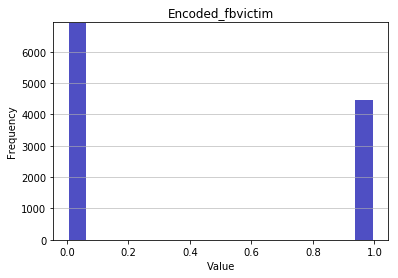

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.3918
Standard deviation: 0.4882
Median: 0.0
Maximal value: 1


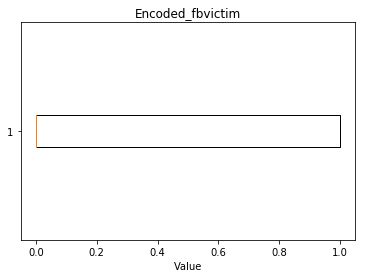

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


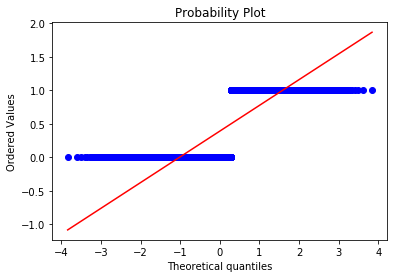

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4433
Kurtosis: -1.8035
Overview of variable:  Encoded_fd 


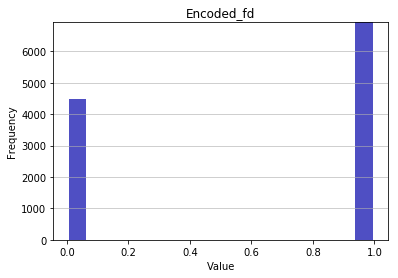

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.6069
Standard deviation: 0.4885
Median: 1.0
Maximal value: 1


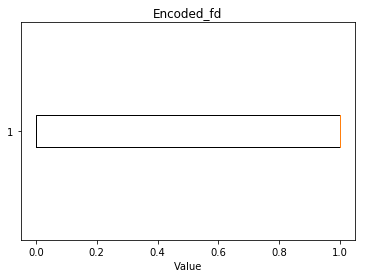

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


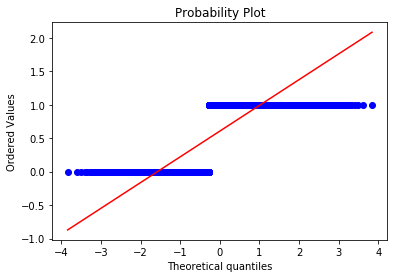

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4376
Kurtosis: -1.8085
Overview of variable:  Encoded_herald 


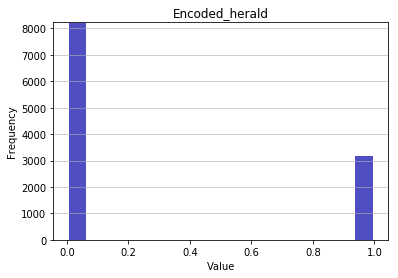

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.2786
Standard deviation: 0.4483
Median: 0.0
Maximal value: 1.0


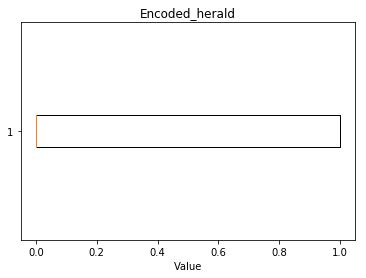

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


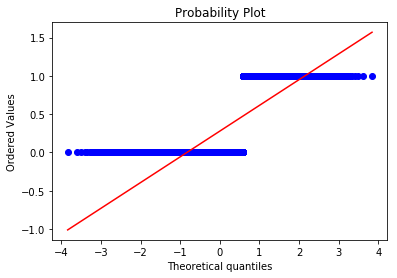

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9877
Kurtosis: -1.0245
Overview of variable:  Encoded_ft 


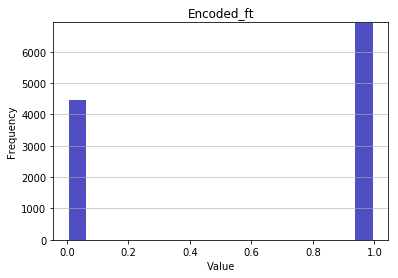

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.6082
Standard deviation: 0.4882
Median: 1.0
Maximal value: 1.0


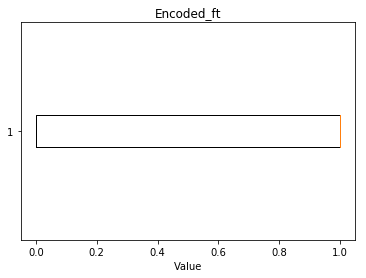

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


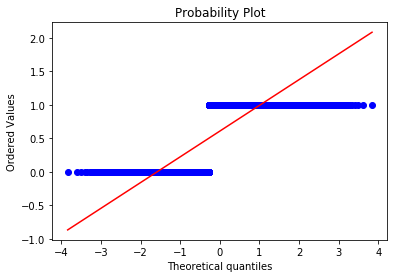

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4433
Kurtosis: -1.8035
Overview of variable:  Encoded_firstmidouter 


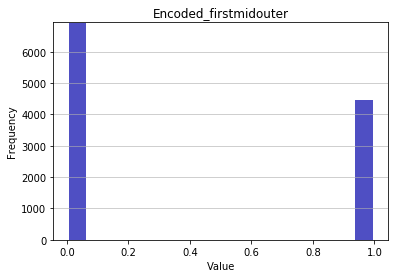

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3918
Standard deviation: 0.4882
Median: 0.0
Maximal value: 1.0


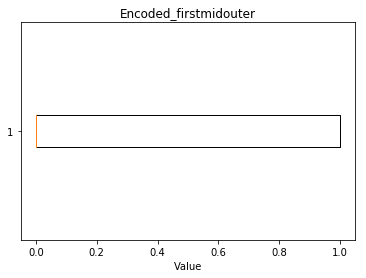

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


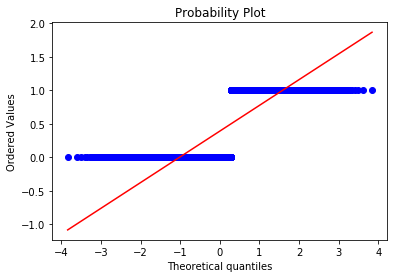

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4433
Kurtosis: -1.8035
Overview of variable:  Encoded_firsttothreetowers 


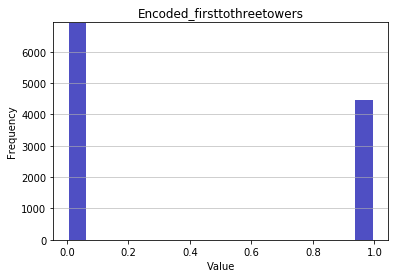

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3918
Standard deviation: 0.4882
Median: 0.0
Maximal value: 1.0


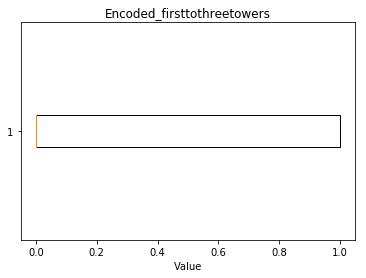

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


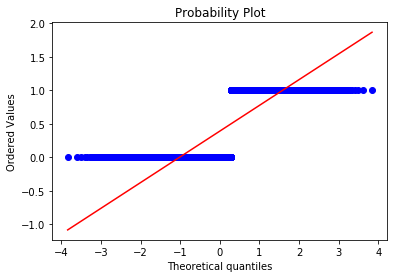

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4433
Kurtosis: -1.8035
Overview of variable:  Encoded_fbaron 


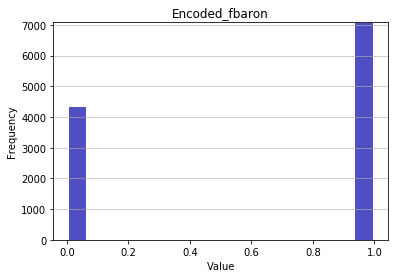

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.6204
Standard deviation: 0.4853
Median: 1.0
Maximal value: 1.0


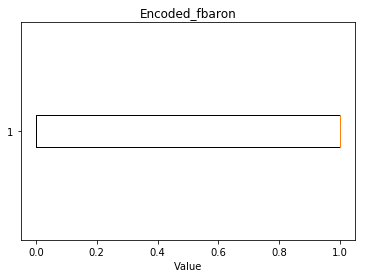

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


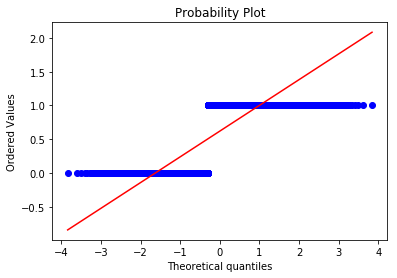

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4962
Kurtosis: -1.7538
Overview of variable:  Encoded_Year 


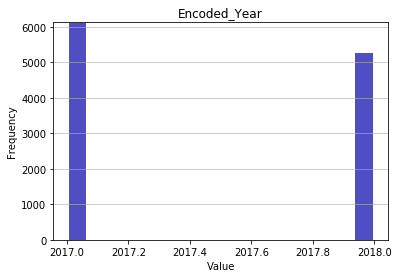

-------------------- 
Summary statistics:
 --------------------
Minimum value: 2017
Mean: 2017.4624
Standard deviation: 0.4986
Median: 2017.0
Maximal value: 2018


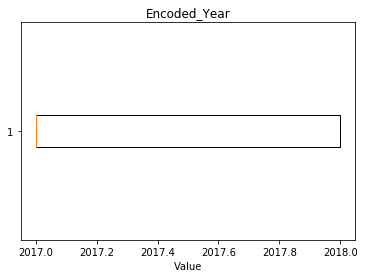

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


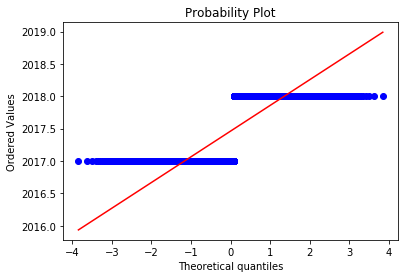

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1507
Kurtosis: -1.9773
Overview of variable:  Encoded_culture 


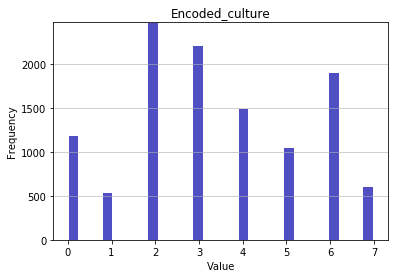

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 3.4051
Standard deviation: 2.0018
Median: 3.0
Maximal value: 7


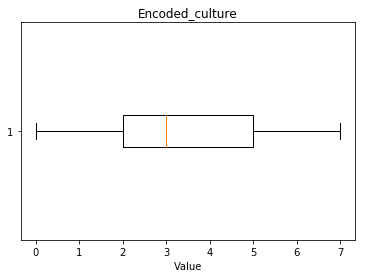

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


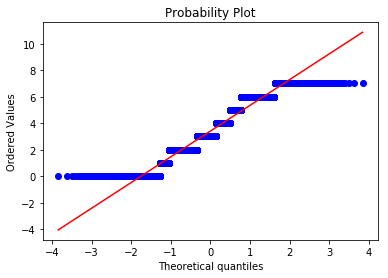

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.053
Kurtosis: -0.9301


<Figure size 432x288 with 0 Axes>

In [19]:
# Loop through all numerical variables and visualize data
for num_variable in numerical_variables:
    SummaryNumericVar(preprocessed_data[num_variable].dropna(), num_variable)

##### Remove irrelevant features for further analysis
* Impossible column values are removed (gamelength of zero).
* Features with zero variance were removed (because of their redundancy in further analysis).
* Extreme outliers

In [20]:
# Remove redundant features
preprocessed_data = preprocessed_data.drop(['wardshare'], axis = 1)
preprocessed_data = preprocessed_data[preprocessed_data.gamelength > 0]
preprocessed_data = preprocessed_data[preprocessed_data.datediff != 17973.0]

In [21]:
# Remove dropped features from numerical feature list
numerical_variables.remove('wardshare')

##### Reduce the influence of outliers by applying a box-cox transformation on the data
Because ridge and lasso regression are both sensitive to outlying observations, it was decided to reduce the influence of the latter by applying a box-cox transformation on the numerical features, hence transforming them in a normal shape. We refrained from removing outliers because these could capture relevant information and transformation is assumed to reduce their influence. Different lambda values underlying the exponential transformation of the data are explored [-5, 5] and the optimal value, resulting in the best approximation of the normal curve, is selected.

Feature:  split
The optimal value for lambda:  0.0448472537921744
Feature:  gamelength
The optimal value for lambda:  -0.44124833408859293
Feature:  fbtime
The optimal value for lambda:  0.18674060922842134
Feature:  ckpm
The optimal value for lambda:  0.28171928100957516
Feature:  fdtime
The optimal value for lambda:  0.26901142436409015
Feature:  heraldtime
The optimal value for lambda:  0.2657356250185692
Feature:  fttime
The optimal value for lambda:  0.6117522925325753
Feature:  fbarontime
The optimal value for lambda:  -1.4052217208741884
Feature:  dmgtochamps
The optimal value for lambda:  0.053256149031810036
Feature:  dmgtochampsperminute
The optimal value for lambda:  0.575147898286029
Feature:  wards
The optimal value for lambda:  -0.0780738525208789
Feature:  wpm
The optimal value for lambda:  -0.6085813504053623
Feature:  wardkills
The optimal value for lambda:  0.22011059534709856
Feature:  wcpm
The optimal value for lambda:  0.27090704880990313
Feature:  visionwards
The 

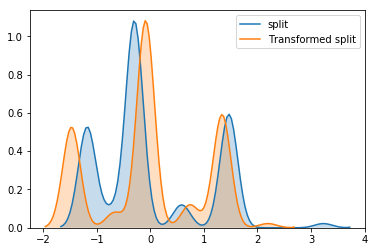

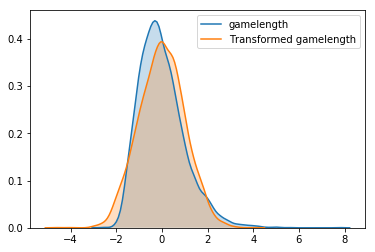

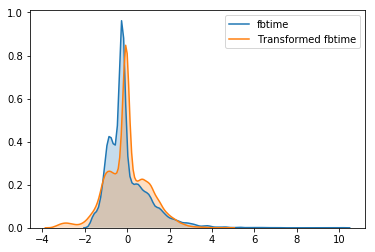

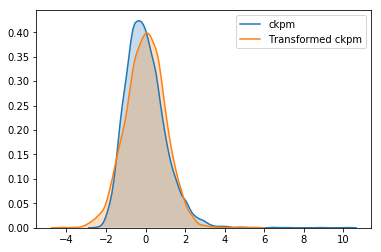

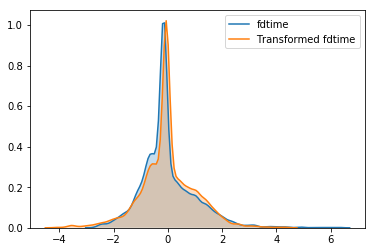

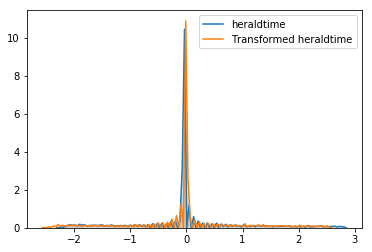

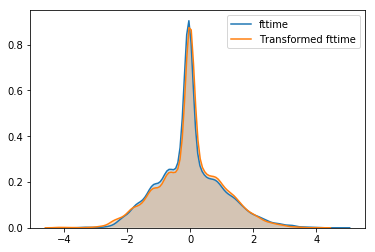

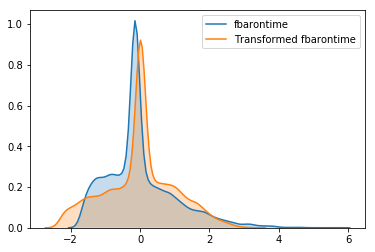

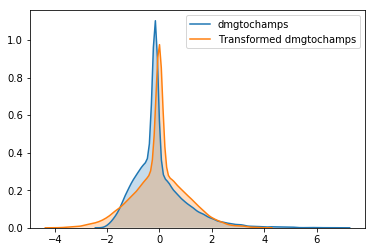

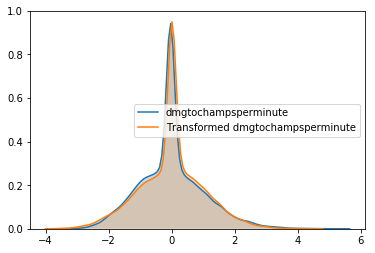

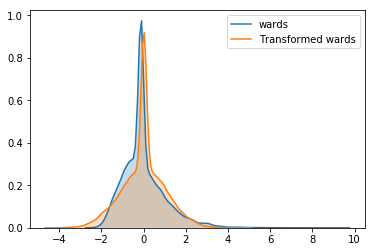

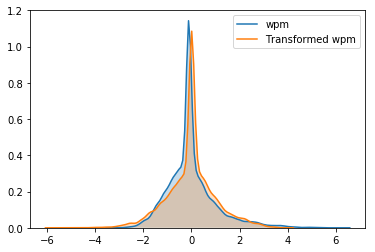

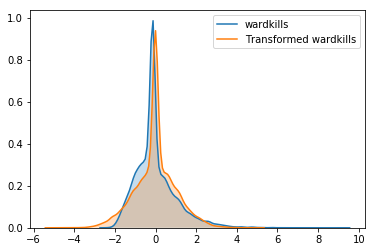

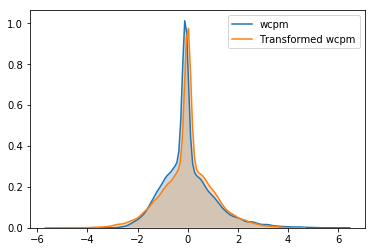

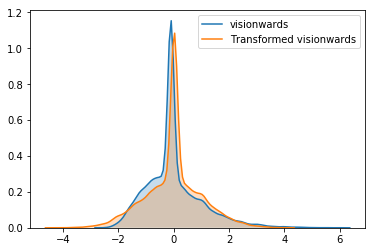

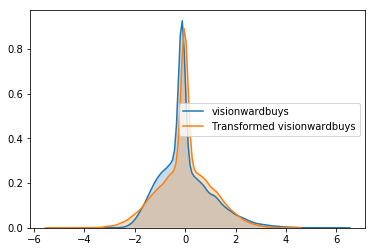

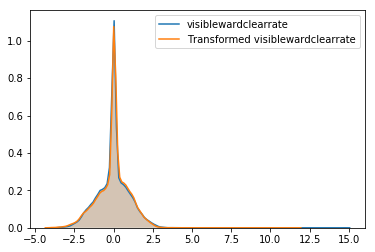

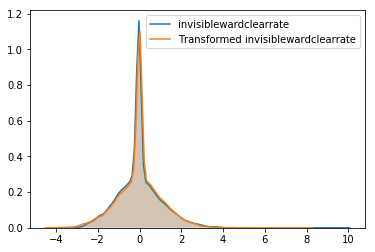

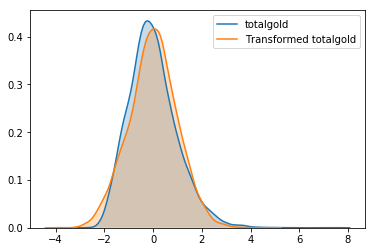

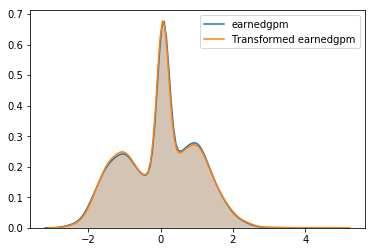

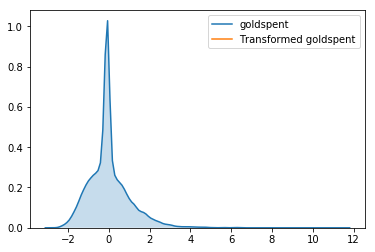

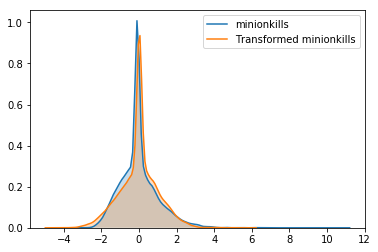

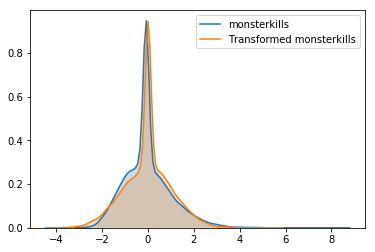

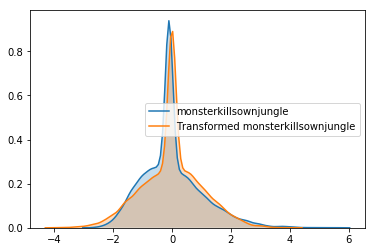

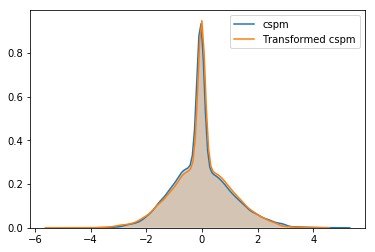

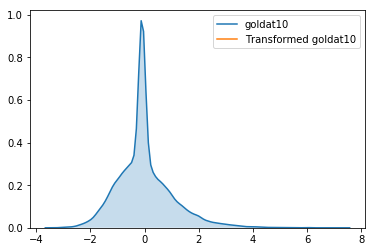

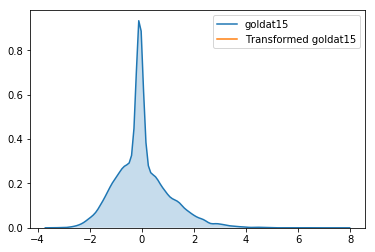

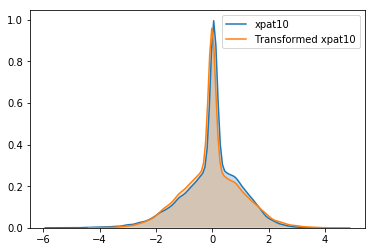

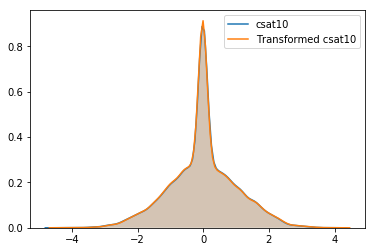

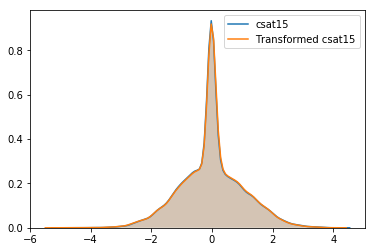

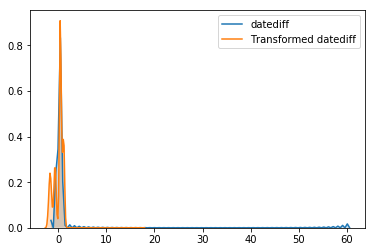

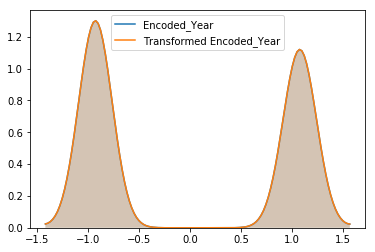

In [22]:
# Initialization
transformed_data_df, optimiser_dict = pd.DataFrame(), dict()

# Loop through the data and apply box cox transformation
for num_variable in numerical_variables:
    if all(preprocessed_data[num_variable] > 0):
        transformed_feature, optimiser = feature_transformer(preprocessed_data[num_variable], num_variable)
        if -5 <= optimiser <= 5:
            transformed_data_df[num_variable] = transformed_feature
            optimiser_dict[num_variable] = optimiser
        else:
            transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
            optimiser_dict[num_variable] = np.nan
    else:
        transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
    #transformed_data_df[num_variable], optimiser_dict[num_variable] = transformed_feature, optimiser if -5 <= optimiser <= 5 else preprocessing.scale(preprocessed_data[num_variable]), np.nan
    #if all(preprocessed_data[num_variable] > 0):
    #    transformed_data_df[num_variable], optimiser = feature_transformer(preprocessed_data[num_variable], num_variable)
    #    optimiser_dict[num_variable] = optimiser
    #else:
    #    transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
        
# Add team feature
transformed_data_df['team'] = list(preprocessed_data['team'])

Overview of variable:  split 


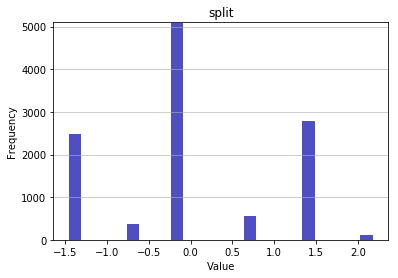

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.4750818038918914
Mean: 0.0
Standard deviation: 1.0
Median: -0.0904
Maximal value: 2.194337418616238


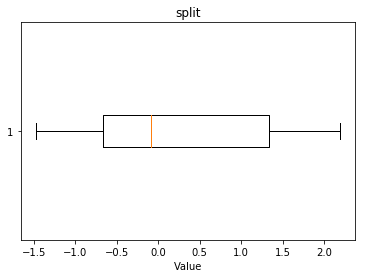

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


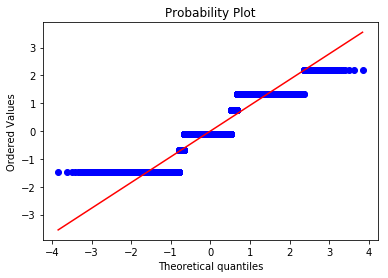

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.007
Kurtosis: -0.9541
Overview of variable:  patchno 


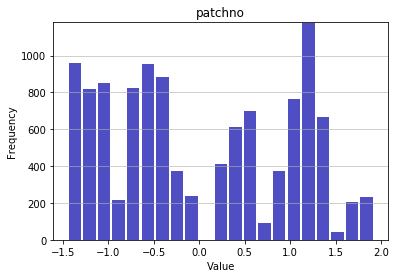

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.4473127848870553
Mean: 0.0
Standard deviation: 1.0
Median: -0.2964
Maximal value: 1.9230912234826274


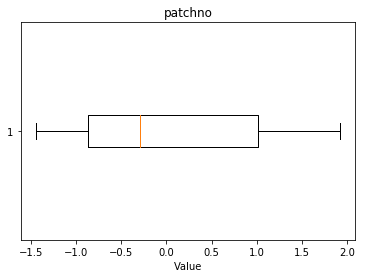

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


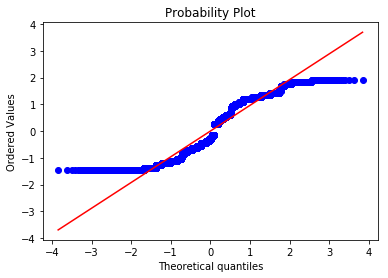

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1644
Kurtosis: -1.3673
Overview of variable:  gamelength 


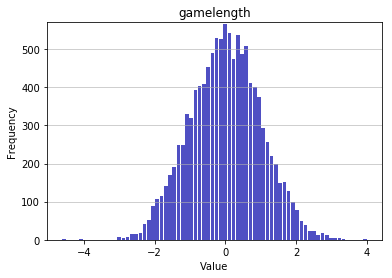

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.617357376680475
Mean: 0.0
Standard deviation: 1.0
Median: 0.0074
Maximal value: 3.9969507826692783


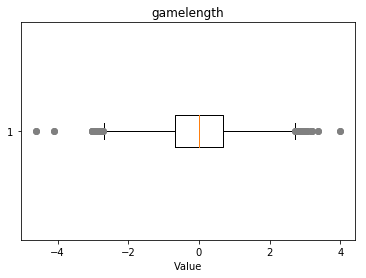

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.07, 3.18, 3.36, 4.0, 3.16, 3.19, -4.62, -3.03, -4.1, -3.02}


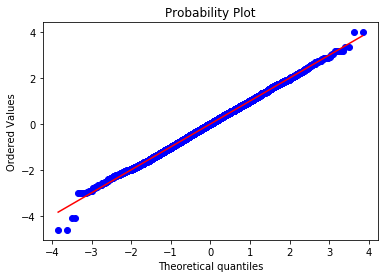

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0019
Kurtosis: -0.061
Overview of variable:  k 


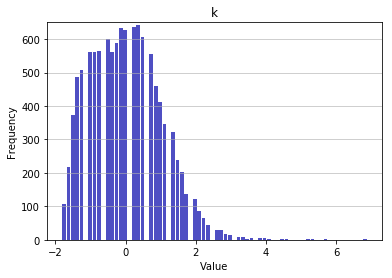

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8109224588036514
Mean: -0.0
Standard deviation: 1.0
Median: -0.1043
Maximal value: 6.877538706223135


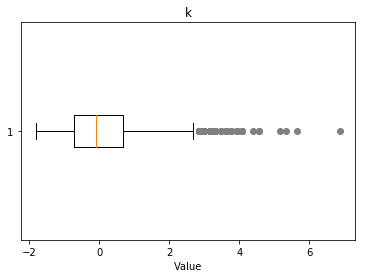

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.31, 3.77, 3.15, 4.08, 3.46, 3.93, 4.55, 3.62, 4.4, 5.17, 5.64, 5.33, 6.88}


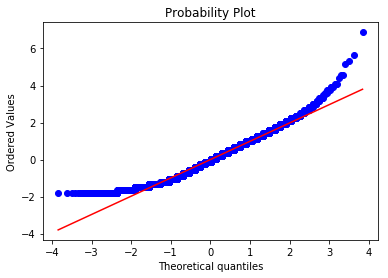

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4798
Kurtosis: 0.26
Overview of variable:  d 


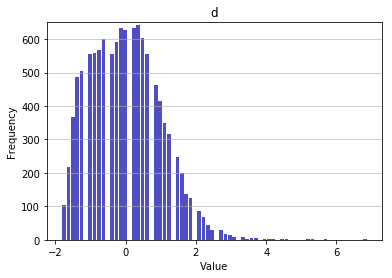

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.812032981424437
Mean: -0.0
Standard deviation: 1.0
Median: -0.107
Maximal value: 6.868240669331193


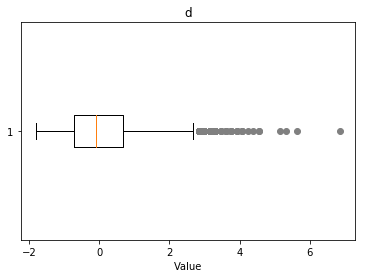

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.3, 3.77, 3.15, 4.23, 3.46, 3.92, 4.54, 4.08, 3.61, 4.39, 5.16, 5.32, 6.87, 5.63}


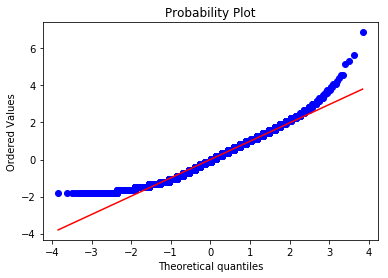

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4805
Kurtosis: 0.2618
Overview of variable:  a 


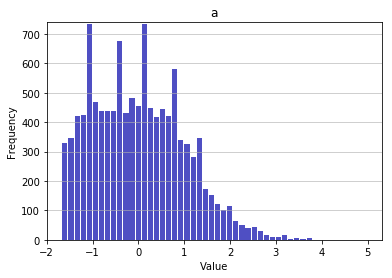

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.67020931769718
Mean: -0.0
Standard deviation: 1.0
Median: -0.0498
Maximal value: 4.991395926309217


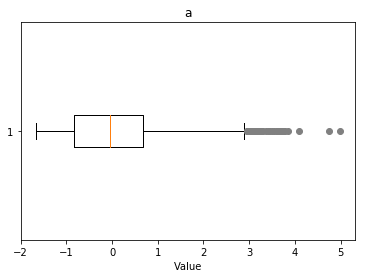

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.19, 3.13, 3.79, 3.61, 3.85, 3.67, 3.07, 3.43, 3.01, 3.25, 4.75, 3.73, 3.49, 3.37, 3.55, 3.31, 4.09, 4.99}


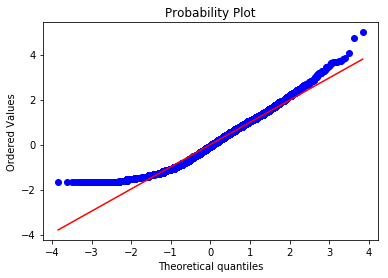

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4686
Kurtosis: -0.1761
Overview of variable:  teamkills 


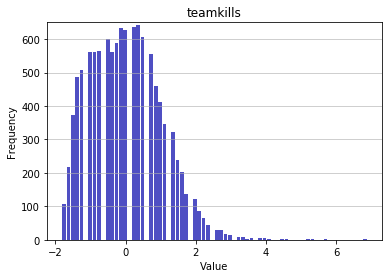

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8109224588036514
Mean: -0.0
Standard deviation: 1.0
Median: -0.1043
Maximal value: 6.877538706223135


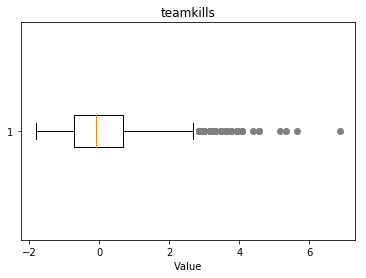

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.31, 3.77, 3.15, 4.08, 3.46, 3.93, 4.55, 3.62, 4.4, 5.17, 5.64, 5.33, 6.88}


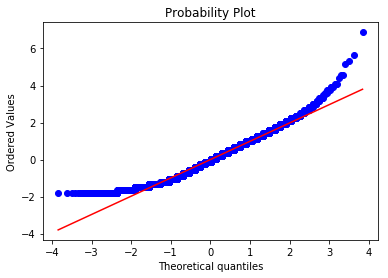

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4798
Kurtosis: 0.26
Overview of variable:  fbtime 


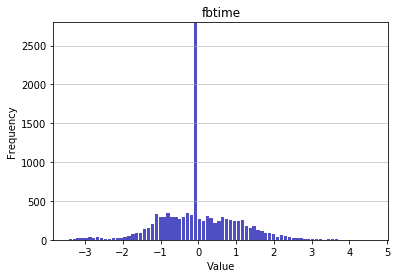

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.4386726291414047
Mean: 0.0
Standard deviation: 1.0
Median: -0.0498
Maximal value: 4.6325958896097665


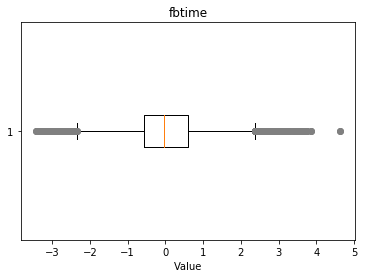

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.67, 3.85, 3.03, 3.57, 3.76, 3.43, 3.02, 3.52, 3.29, 3.11, 4.63, 3.01, -3.32, -3.07, -3.06, -3.15, -3.4, 3.26, -3.14, 3.6, -3.3, -3.13, -3.04, -3.05, -3.21, 3.27, -3.12, 3.18, -3.28, -3.44, -3.11, -3.35, -3.02, -3.27, 3.23, -3.26, -3.0, -3.08, -3.25, -3.41, -3.09, -3.01, -3.16, 3.39, -3.2}


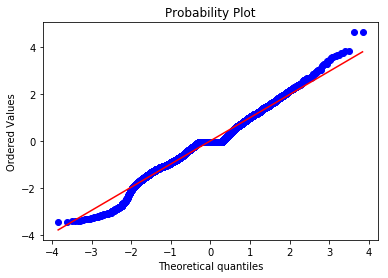

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0323
Kurtosis: 0.9727
Overview of variable:  kpm 


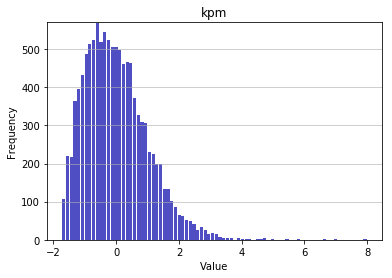

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.727539176282808
Mean: -0.0
Standard deviation: 1.0
Median: -0.1206
Maximal value: 7.989881255463964


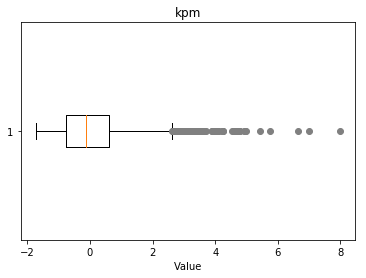

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.13, 3.4, 4.06, 4.71, 3.62, 3.18, 3.5, 3.16, 3.24, 3.21, 4.78, 5.42, 6.64, 3.17, 3.91, 3.09, 3.92, 3.58, 3.25, 3.0, 4.68, 4.6, 3.41, 5.76, 4.93, 4.99, 4.75, 4.24, 6.99, 7.99, 3.42, 3.61, 3.69, 3.43, 3.1, 3.02, 3.11, 3.19, 3.27, 3.55, 4.23, 3.88, 3.3, 3.04, 3.29, 3.05, 4.11, 4.96, 3.12, 4.64, 4.54, 4.61, 4.03, 3.01, 3.07, 3.06, 3.23, 3.15, 3.31, 3.33, 3.65, 3.98, 3.14, 4.26}


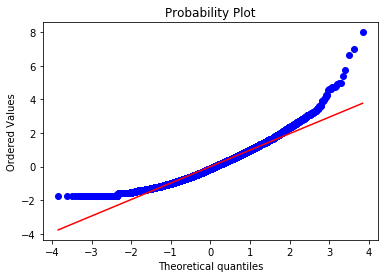

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8607
Kurtosis: 1.4836
Overview of variable:  ckpm 


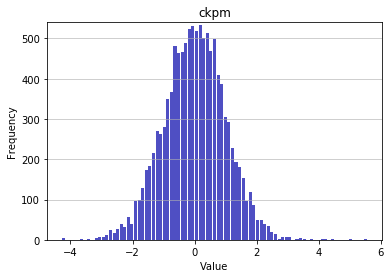

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.272193358411982
Mean: 0.0
Standard deviation: 1.0
Median: 0.0129
Maximal value: 5.550588536560753


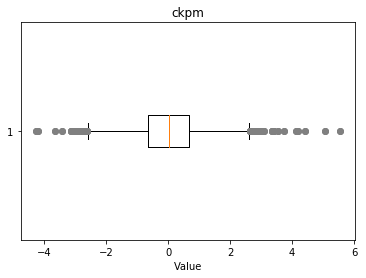

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.07, 3.03, 3.34, 3.36, 4.14, 3.06, 3.11, 3.73, 3.55, 5.55, 5.07, 3.42, -3.64, -3.15, 4.41, -3.1, -3.02, -3.44, 4.2, -4.27, -4.19, -3.09}


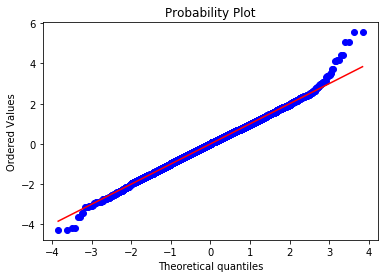

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0147
Kurtosis: 0.4804
Overview of variable:  fdtime 


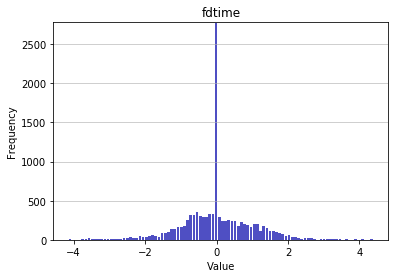

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.145195586713751
Mean: -0.0
Standard deviation: 1.0
Median: -0.0548
Maximal value: 4.388052959123732


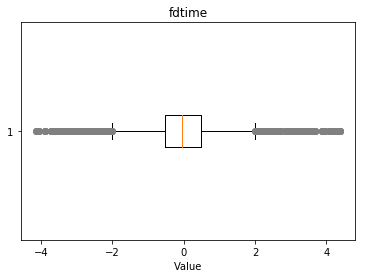

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.65, 3.0, 3.02, 3.14, 4.26, 3.67, 3.25, 3.04, 3.29, 3.57, 4.07, 3.41, -3.48, 3.33, 3.17, -3.89, 4.34, 4.1, -3.64, 3.34, -3.57, -3.4, -3.47, -3.43, -4.06, -4.11, -3.72, 3.03, 3.35, -3.88, -3.71, -3.54, -3.62, -3.29, -3.21, -3.05, -3.55, -3.07, 3.7, 3.87, -3.1, 3.13, -3.19, 4.2, 4.37, -3.36, -3.68, -3.17, 4.39, -3.28, -3.03, -3.02, 3.48, 3.64, 3.32, 3.15, -3.08, 3.89, -3.66, -3.58, 3.97, -3.5, -3.0, -4.15, -3.56}


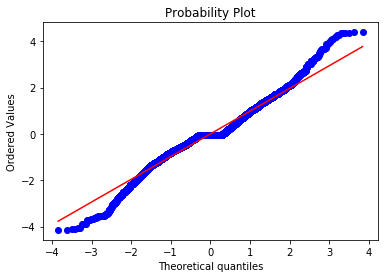

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0462
Kurtosis: 1.82
Overview of variable:  teamdragkills 


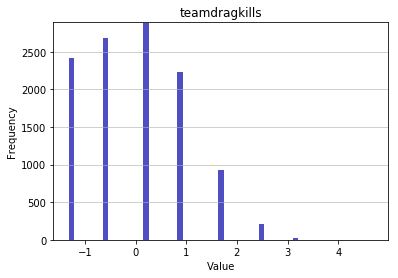

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.3289846644601493
Mean: 0.0
Standard deviation: 1.0
Median: 0.1774
Maximal value: 4.696645162161177


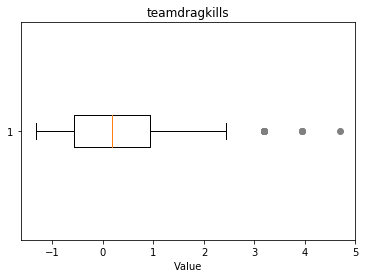

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.94, 3.19, 4.7}


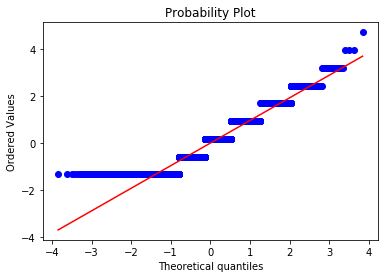

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3672
Kurtosis: -0.5324
Overview of variable:  elementals 


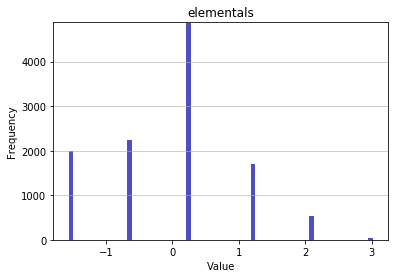

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5684634183232804
Mean: -0.0
Standard deviation: 1.0
Median: 0.2683
Maximal value: 3.023321482386678


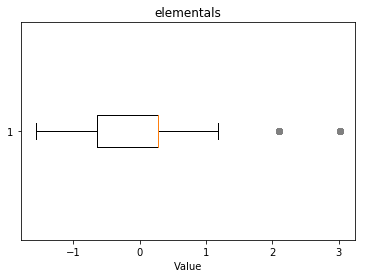

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.02}


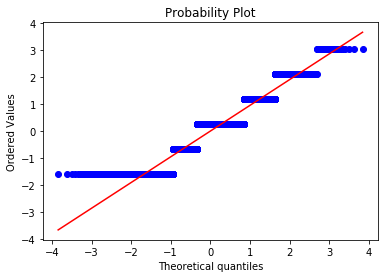

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0715
Kurtosis: -0.3654
Overview of variable:  firedrakes 


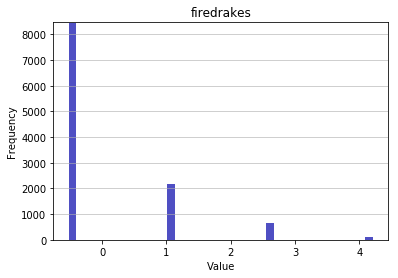

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5309273597065624
Mean: 0.0
Standard deviation: 1.0
Median: -0.5309
Maximal value: 4.221964409005316


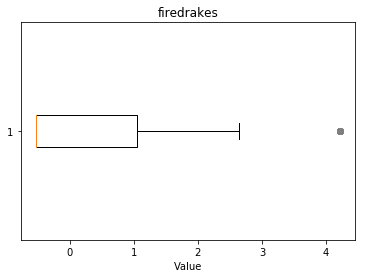

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.22}


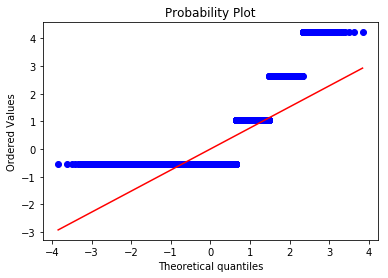

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9217
Kurtosis: 3.2533
Overview of variable:  waterdrakes 


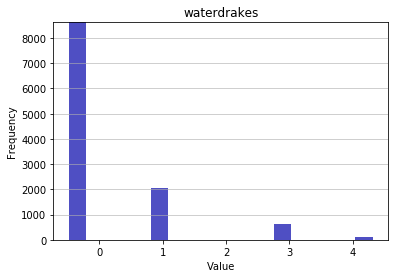

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5127492055902737
Mean: 0.0
Standard deviation: 1.0
Median: -0.5127
Maximal value: 4.34330410788524


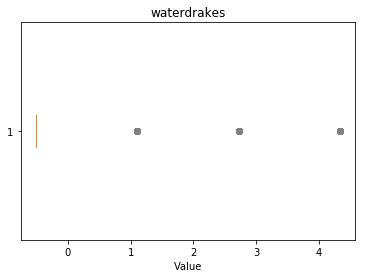

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.34}


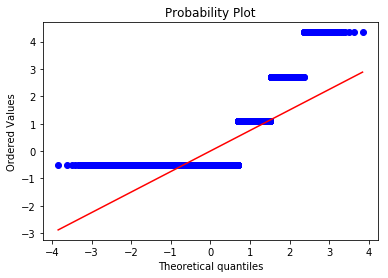

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 2.0051
Kurtosis: 3.6126
Overview of variable:  earthdrakes 


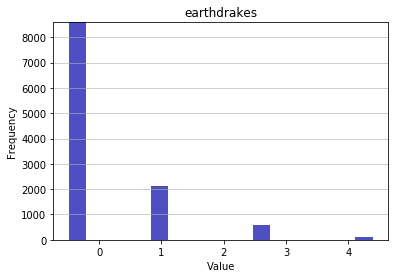

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5180421786630017
Mean: -0.0
Standard deviation: 1.0
Median: -0.518
Maximal value: 4.420992766904735


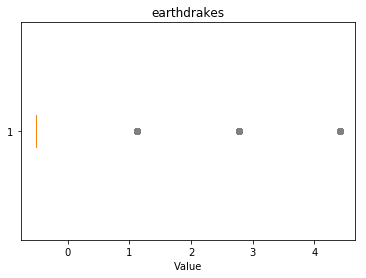

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.42}


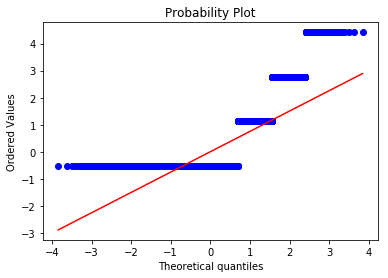

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9817
Kurtosis: 3.5657
Overview of variable:  airdrakes 


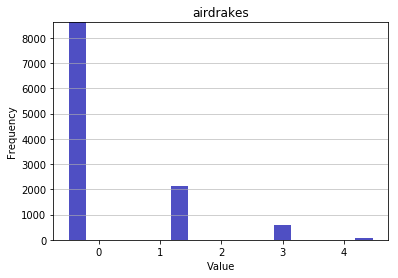

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.517344447500615
Mean: -0.0
Standard deviation: 1.0
Median: -0.5173
Maximal value: 4.499017576079412


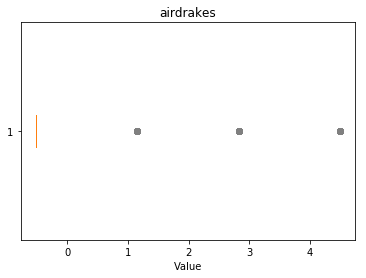

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.5}


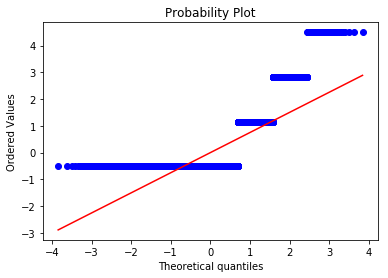

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.975
Kurtosis: 3.5349
Overview of variable:  elders 


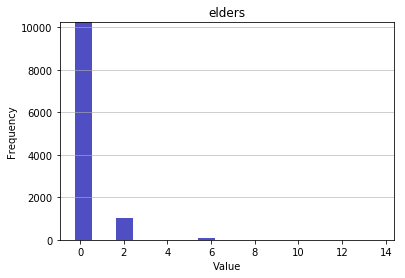

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.31686331331008705
Mean: 0.0
Standard deviation: 1.0
Median: -0.3169
Maximal value: 13.77007321519066


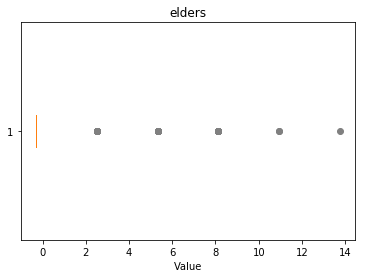

-------------------- 
Outlier detection:
 --------------------
List of outliers: {8.14, 10.95, 13.77, 5.32}


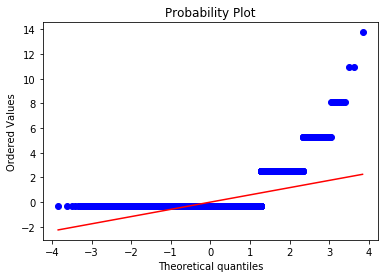

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 3.6179
Kurtosis: 16.9327
Overview of variable:  heraldtime 


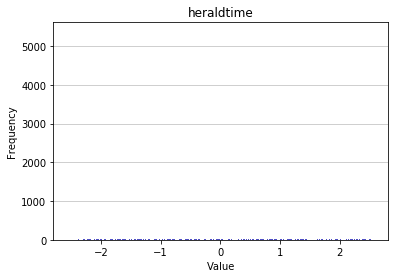

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.5407755604588327
Mean: -0.0
Standard deviation: 1.0
Median: 0.001
Maximal value: 2.5577738408645017


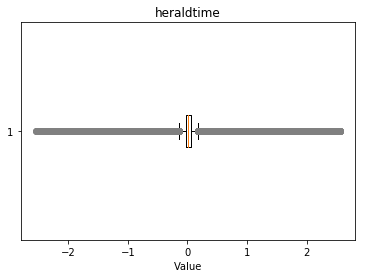

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


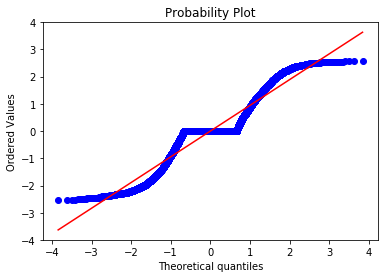

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0074
Kurtosis: 0.6434
Overview of variable:  fttime 


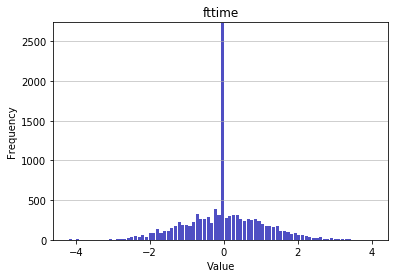

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.197837217400344
Mean: -0.0
Standard deviation: 1.0
Median: -0.011
Maximal value: 4.039179239435804


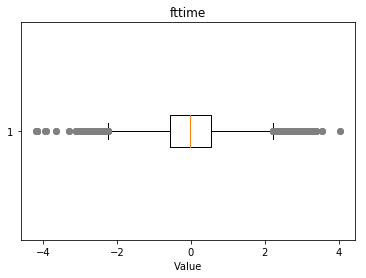

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.1, 3.26, 3.17, 3.2, 3.37, 3.39, 3.54, 4.04, 3.31, -4.18, -4.16, 3.07, -3.12, -3.06, -3.64, -3.91, -3.96, -3.3, -4.2, -3.1}


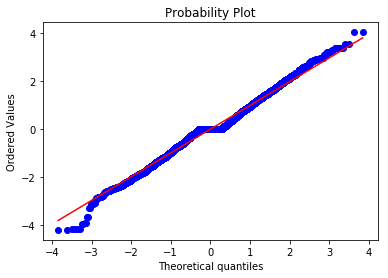

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0312
Kurtosis: 0.6601
Overview of variable:  teamtowerkills 


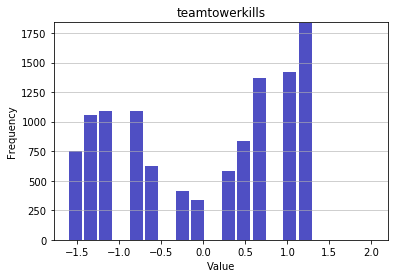

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.6124725613417985
Mean: -0.0
Standard deviation: 1.0
Median: 0.2111
Maximal value: 2.034585318314994


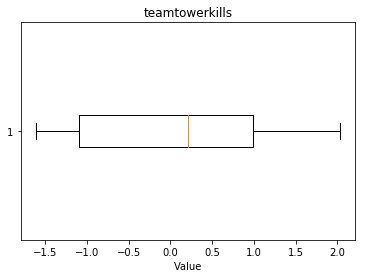

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


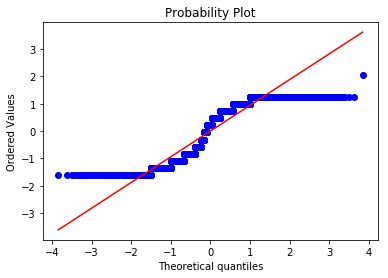

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2
Kurtosis: -1.5019
Overview of variable:  fbarontime 


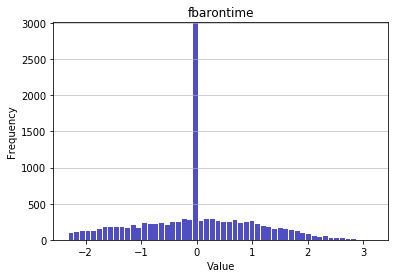

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.3122376310334194
Mean: 0.0
Standard deviation: 1.0
Median: 0.0175
Maximal value: 3.186697351390424


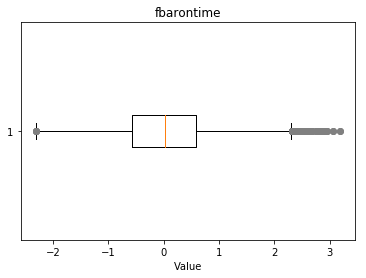

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.19, 3.06}


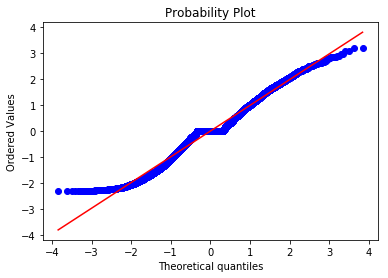

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0024
Kurtosis: -0.0478
Overview of variable:  teambaronkills 


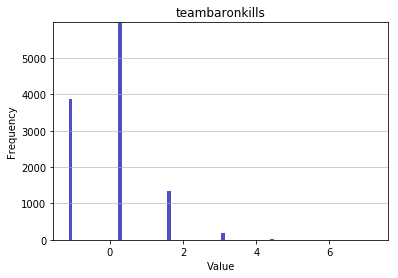

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.1381808578076618
Mean: -0.0
Standard deviation: 1.0
Median: 0.2512
Maximal value: 7.197825982035399


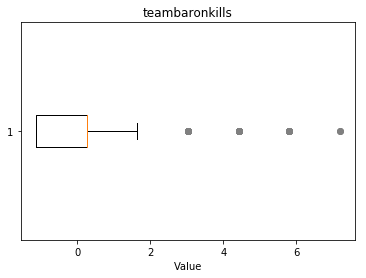

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.03, 4.42, 5.81, 7.2}


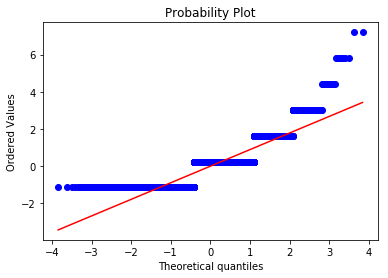

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8058
Kurtosis: 1.5792
Overview of variable:  dmgtochamps 


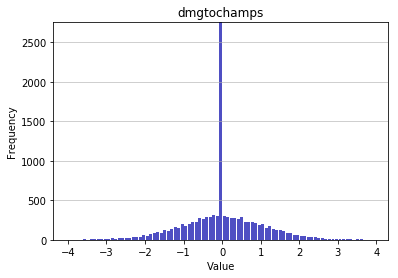

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9865121932400975
Mean: -0.0
Standard deviation: 1.0
Median: -0.0074
Maximal value: 3.922942775232007


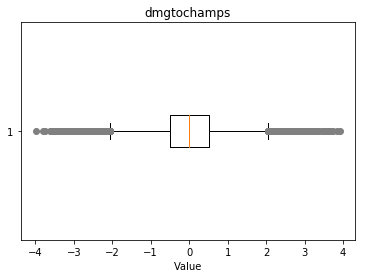

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.08, 3.12, 3.19, 3.24, 3.22, 3.18, 3.53, 3.1, 3.54, 3.0, 3.23, 3.25, -3.06, -3.23, -3.73, 3.01, 3.67, 3.17, 3.49, 3.26, 3.33, -3.4, -3.22, -3.26, -3.15, -3.37, 3.31, 3.92, 3.28, -3.11, 3.27, -3.45, -3.04, -3.38, 3.02, -3.55, 3.61, -3.21, -3.79, -3.3, -3.14, -3.0, -3.61, 3.74, 3.85, -3.32, 3.29, -3.53, 3.13, 3.5, 3.62, -3.33, -3.43, -3.08, -3.27, -3.6, -3.56, -3.2, -3.17, 3.07, 3.65, 3.39, 3.14, 3.06, -3.99, -3.5, -3.16, 3.57, 3.15, -3.09, 3.44, -3.28, -3.12}


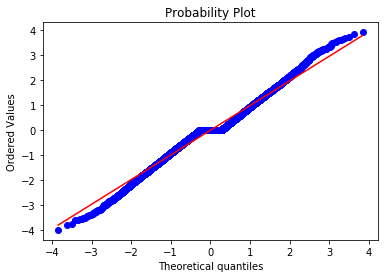

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0061
Kurtosis: 0.9815
Overview of variable:  dmgtochampsperminute 


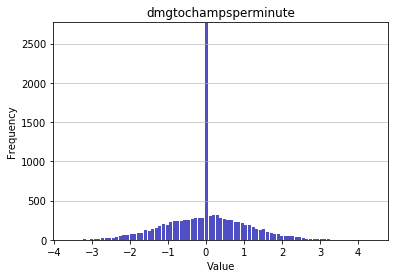

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.6191447728766177
Mean: 0.0
Standard deviation: 1.0
Median: 0.011
Maximal value: 4.401585494064076


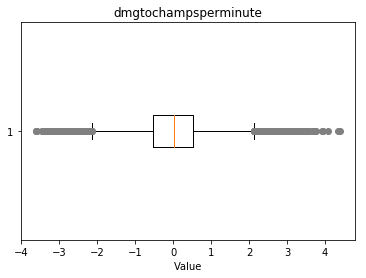

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.06, 3.09, 3.44, 3.43, 3.17, 4.09, 3.29, 3.51, 3.24, 3.59, 4.34, 3.08, 3.66, 3.42, 3.33, 3.26, -3.47, -3.32, -3.15, 3.01, 4.4, 3.52, 3.03, 3.77, 3.93, 3.11, 3.94, -3.45, -3.04, 3.02, -3.62, 3.21, 3.13, -3.19, -3.6, -3.36, 3.04, 3.2, -3.18, -3.61, 3.46, -3.03, 3.22, -3.17, 3.57, -3.42, 3.72, 3.15, -3.34, 3.73, -3.25, -3.24, -3.07}


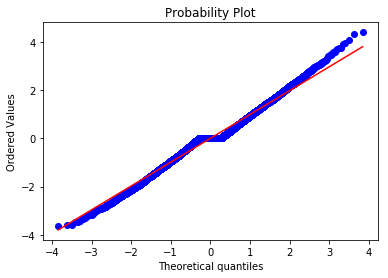

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0335
Kurtosis: 0.7738
Overview of variable:  wards 


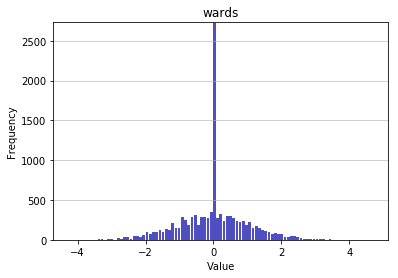

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.270919495232303
Mean: 0.0
Standard deviation: 1.0
Median: 0.0069
Maximal value: 4.709271400054347


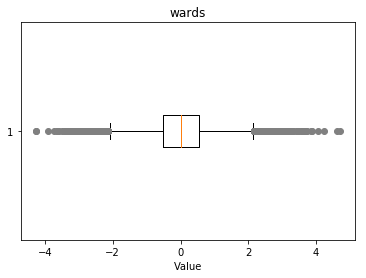

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.41, 3.55, 3.32, 3.18, 3.6, 3.22, 3.06, 3.13, 4.23, 4.62, 4.71, 3.08, 3.24, -3.65, 3.25, 3.84, 4.07, -3.57, 3.03, -3.05, 3.1, 3.69, 3.11, -3.12, 3.19, 3.12, -3.19, -3.27, 3.45, 3.88, 3.2, 3.46, 3.65, -3.42, 3.72, -3.34, -3.49, -3.91, -4.27, -3.73}


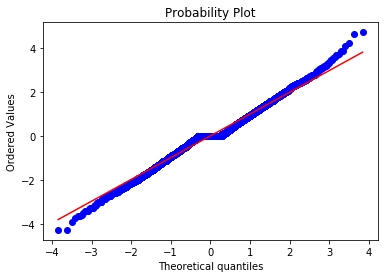

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0057
Kurtosis: 0.812
Overview of variable:  wpm 


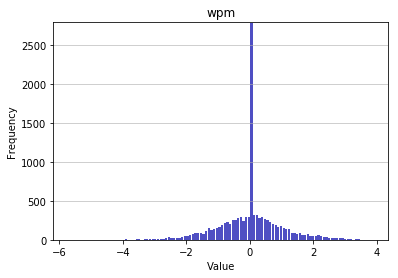

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.7157008595145395
Mean: -0.0
Standard deviation: 1.0
Median: 0.012
Maximal value: 3.8836776295528197


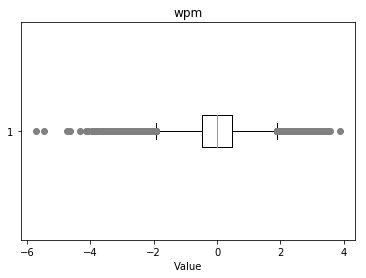

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.45, 3.43, 3.48, 3.07, 3.3, 3.09, 3.04, 3.35, 3.15, 3.56, 3.33, 3.0, 3.34, 3.41, 3.25, -3.64, -3.06, -3.47, -3.23, -3.58, -3.65, -3.22, -3.01, -3.9, -5.72, -4.05, -4.31, -4.11, -4.13, 3.02, -3.05, 3.28, 3.1, 3.19, 3.52, -3.37, -3.8, -3.55, -3.5, -3.21, -3.14, -3.35, 3.05, -3.1, -3.03, -3.6, 3.12, 3.13, 3.88, 3.37, -3.18, -3.27, -3.93, -3.17, -3.95, -3.63, -4.73, -3.52, 3.4, -3.26, -3.91, -3.09, -3.76, 3.06, 3.23, 3.14, 3.47, -3.34, -3.33, -5.47, -4.63, -3.16, -3.48}


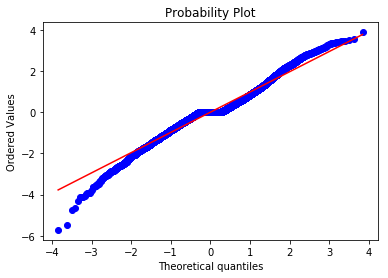

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0426
Kurtosis: 1.4855
Overview of variable:  wardkills 


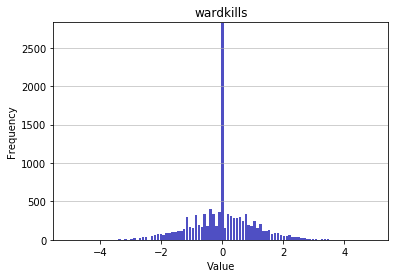

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.027671637284462
Mean: 0.0
Standard deviation: 1.0
Median: -0.0084
Maximal value: 4.9462682001029945


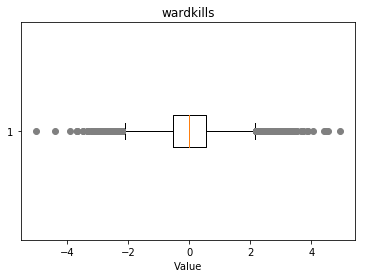

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.86, 3.06, 3.25, 3.37, 3.09, 3.16, 3.71, 3.04, 4.55, 4.5, 4.95, 3.5, -3.14, -3.89, 3.67, 3.01, 4.41, 3.27, 3.69, 3.43, 3.54, -3.68, 3.2, 3.3, 3.45, 3.88, 4.05, 3.39, -3.49, 3.32, 3.48, -5.03, -4.38, -3.31}


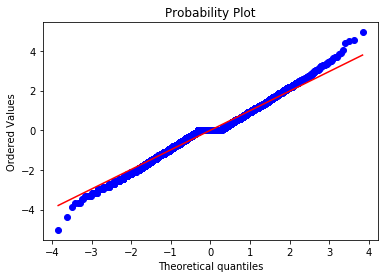

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0278
Kurtosis: 1.0017
Overview of variable:  wcpm 


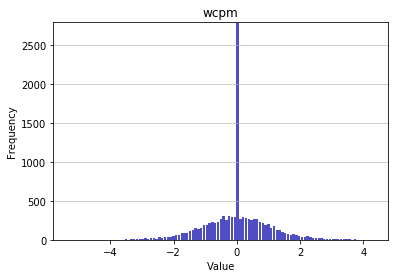

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.319531418060998
Mean: -0.0
Standard deviation: 1.0
Median: -0.0039
Maximal value: 4.309861248025451


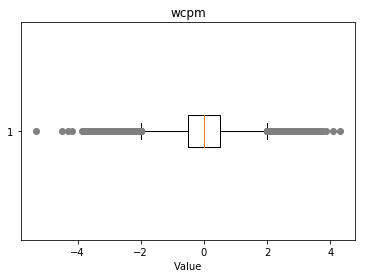

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.6, 4.31, 3.03, 3.09, 3.23, 3.66, 3.08, 3.58, 3.65, 3.37, 4.07, -3.32, -3.39, -3.82, -3.14, -3.07, 3.11, 3.86, 3.29, -3.53, -3.1, -3.03, -3.78, 3.04, -4.49, 3.15, 3.72, 3.22, 3.33, -3.31, -3.06, -3.56, 3.51, 3.01, 3.44, -3.13, -3.2, 3.19, 3.05, -3.52, -3.02, 3.73, -3.09, -3.34, -3.66, 3.34, 3.41, 3.16, -4.3, 3.52, -3.05, -3.55, -3.3, -3.37, 3.27, 3.13, 3.45, 3.7, -3.19, -3.69, 3.38, 3.31, -3.08, -3.33, -3.76, 3.06, 3.49, -3.15, 3.17, 3.42, 3.74, -3.65, 3.28, 3.35, 3.1, 3.46, -3.11, -3.86, -3.18, 3.14, 3.32, -3.75, -3.5, 3.57, 3.07, -5.32, -4.19, -3.23}


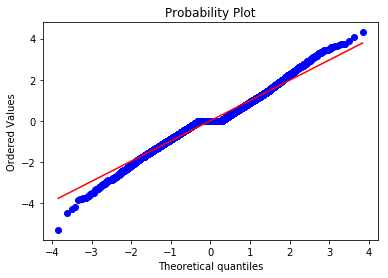

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0325
Kurtosis: 1.3529
Overview of variable:  visionwards 


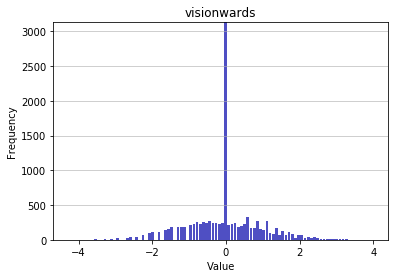

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.274337268187692
Mean: 0.0
Standard deviation: 1.0
Median: 0.0205
Maximal value: 3.9972413536158697


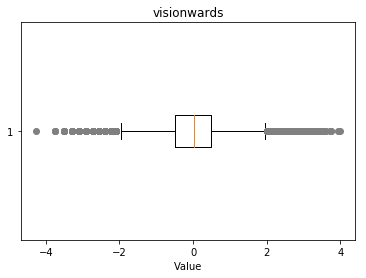

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.3, 3.26, 3.14, 3.06, 3.57, 3.01, 3.41, 3.93, 3.18, 3.1, 4.0, 3.75, 3.49, 3.6, 3.38, 3.71, 3.22, -3.74, -3.51, -3.09, -4.27, -3.29}


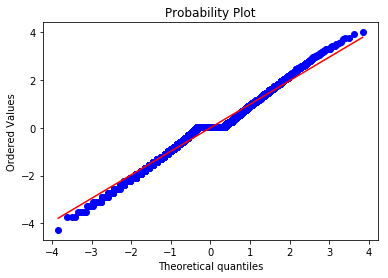

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0227
Kurtosis: 0.8845
Overview of variable:  visionwardbuys 


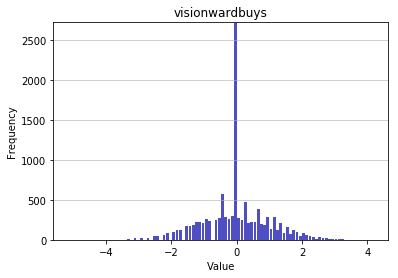

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.141569260646678
Mean: -0.0
Standard deviation: 1.0
Median: -0.0247
Maximal value: 4.177882793623663


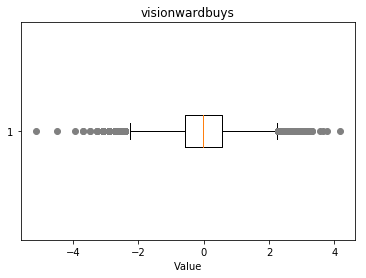

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.1, 3.0, 3.55, 3.28, 3.77, 3.24, 3.05, 4.18, 3.33, 3.15, 3.19, -3.09, -3.71, -3.49, -3.94, 3.64, -5.14, -4.48, -3.28}


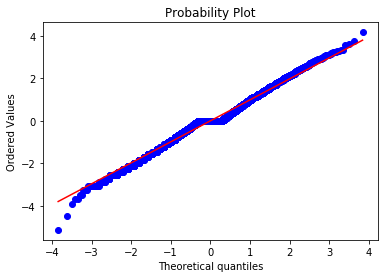

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.018
Kurtosis: 0.6225
Overview of variable:  visiblewardclearrate 


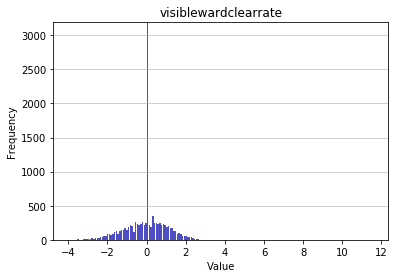

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9885874237549017
Mean: 0.0
Standard deviation: 1.0
Median: 0.0378
Maximal value: 11.574832454596057


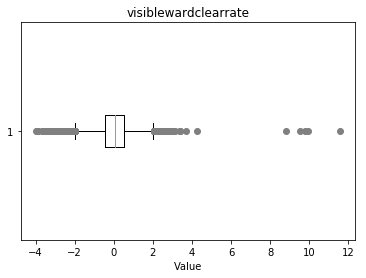

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.4, 3.68, 4.28, 3.1, 3.07, 8.8, 9.79, 9.93, 11.57, 9.51, -3.14, -3.06, -3.23, -3.9, -3.64, -3.47, -3.22, -3.89, -3.12, -3.21, -3.37, -3.29, -3.3, -3.38, -3.1, -3.03, -3.43, -3.93, -3.28, -3.59, -3.67, -3.09, -3.08, -3.49, -3.16, -3.24, -3.99, -3.92}


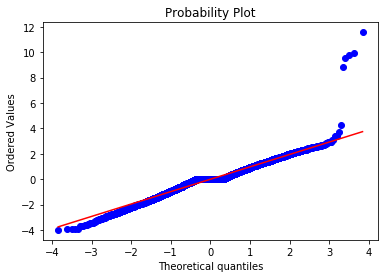

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1604
Kurtosis: 4.9278
Overview of variable:  invisiblewardclearrate 


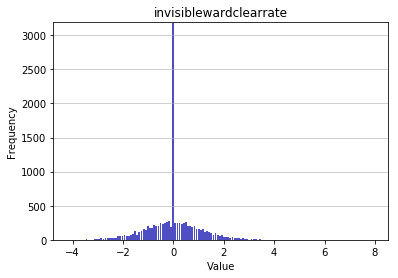

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.159738665885826
Mean: 0.0
Standard deviation: 1.0
Median: -0.0062
Maximal value: 7.932361373505084


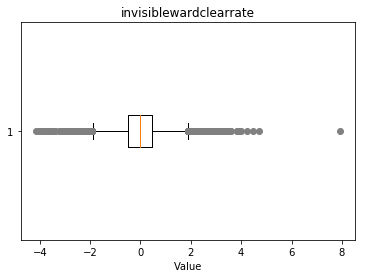

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.4, 3.91, 3.28, 4.69, 3.3, 3.06, 3.85, 3.88, 3.14, 3.2, 4.24, 7.93, 3.34, 3.33, -3.82, -3.07, -3.57, 3.16, 3.51, 4.0, 3.08, 3.59, 3.41, -4.05, 3.17, 3.44, 3.19, -3.13, -3.05, -3.71, -3.88, -3.38, -3.12, -3.04, 3.27, 3.24, 3.04, -3.02, -3.69, -3.44, 3.29, 4.47, 3.12, 3.54, -3.52, -3.93, 3.07, -3.09, -3.24, 3.22, -3.16, -3.41, 3.48, 3.39, -4.16, -3.5}


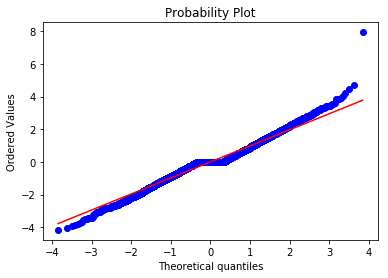

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0929
Kurtosis: 1.468
Overview of variable:  totalgold 


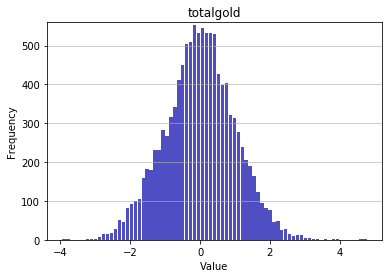

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9544564610786543
Mean: -0.0
Standard deviation: 1.0
Median: 0.013
Maximal value: 4.782278323447016


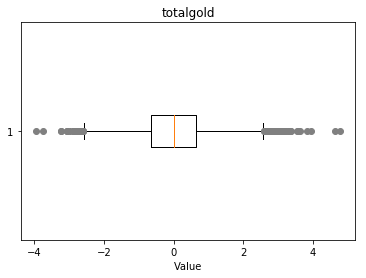

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.02, 3.22, 3.34, 3.96, 3.16, 3.29, 3.12, 3.07, 3.36, 3.11, 4.78, 3.83, 3.09, 3.58, 3.33, -3.22, -3.07, -3.05, -3.95, 3.54, 3.62, 4.63, -3.76}


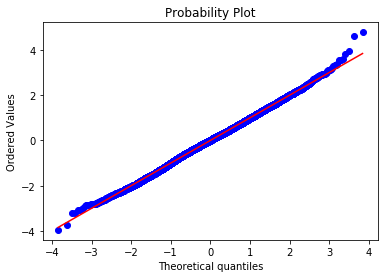

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.001
Kurtosis: 0.1029
Overview of variable:  earnedgpm 


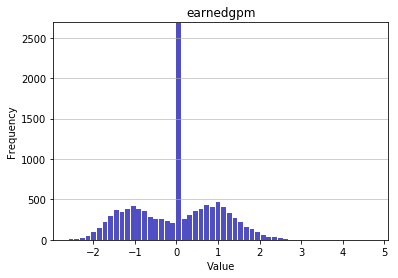

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.602344650806049
Mean: 0.0
Standard deviation: 1.0
Median: 0.0629
Maximal value: 4.736651613902764


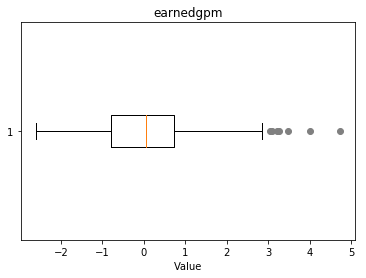

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.1, 3.26, 4.74, 3.05, 3.21, 4.02, 3.49}


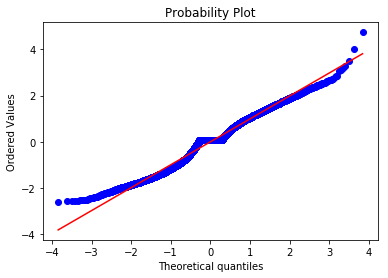

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0356
Kurtosis: -0.5004
Overview of variable:  goldspent 


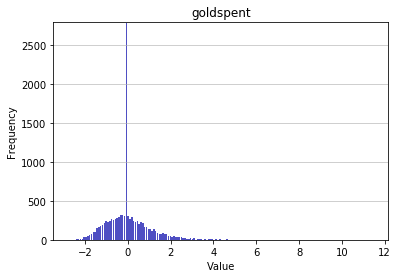

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.772095153907501
Mean: -0.0
Standard deviation: 1.0
Median: -0.0982
Maximal value: 11.459396651779594


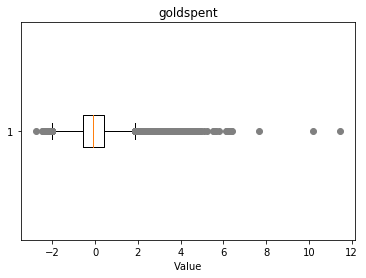

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.09, 3.12, 4.32, 3.08, 4.8, 4.66, 3.1, 4.02, 3.49, 3.65, 4.63, 5.57, 7.65, 3.0, 3.25, 3.75, 11.46, 4.93, 3.11, 3.61, 3.18, 3.04, 3.29, 4.47, 5.11, 5.22, 3.4, 3.9, 3.58, 3.76, 3.51, 3.26, 3.83, 4.15, 4.08, 4.33, 4.65, 5.65, 6.26, 6.33, 3.19, 3.69, 3.44, 3.94, 3.8, 3.62, 4.37, 4.3, 6.19, 3.48, 3.34, 3.41, 3.84, 4.91, 4.73, 4.34, 4.77, 5.52, 3.27, 3.77, 3.02, 3.88, 3.63, 3.45, 3.7, 3.95, 4.06, 4.38, 3.13, 4.7, 3.38, 4.56, 5.63, 4.13, 5.81, 6.13, 3.31, 3.06, 3.81, 3.24, 3.42, 3.17, 3.99, 4.1, 4.6, 4.49, 4.92, 6.17, 6.42, 3.03, 3.28, 10.17, 4.14, 4.21, 4.28, 3.64, 3.07, 3.89, 3.14, 3.39}


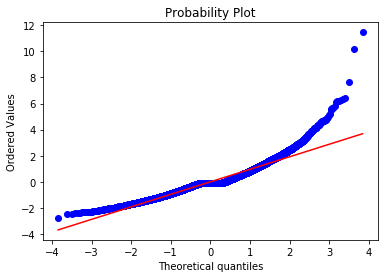

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.3211
Kurtosis: 5.6427
Overview of variable:  gspd 


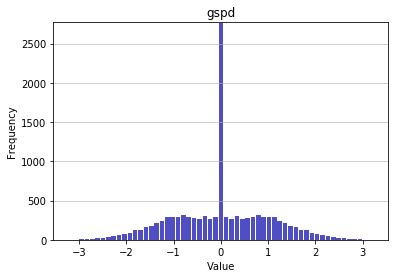

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.2272652179251247
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 3.2272652179251247


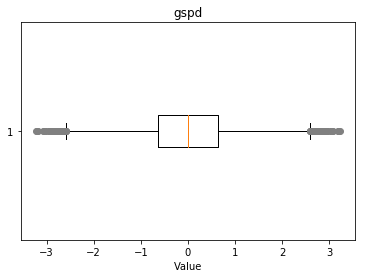

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.19, 3.08, 3.06, 3.18, 3.01, 3.23, -3.06, -3.08, -3.18, -3.01, -3.23, -3.19}


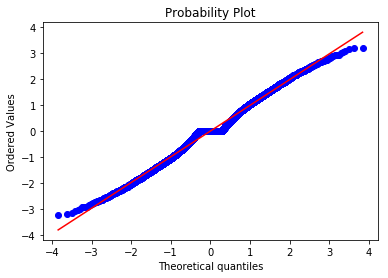

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -0.0102
Overview of variable:  minionkills 


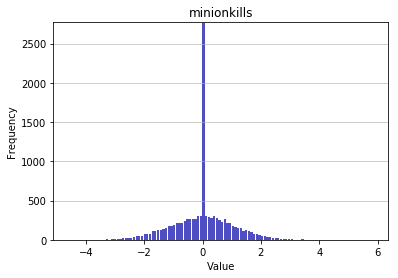

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.602078454971516
Mean: 0.0
Standard deviation: 1.0
Median: 0.0187
Maximal value: 5.853581293895439


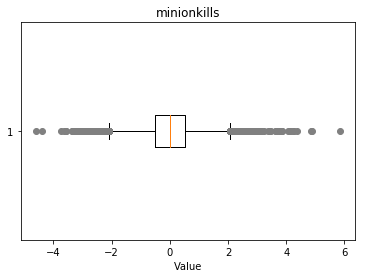

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.01, 3.37, 3.09, 3.44, 4.23, 4.12, 3.06, 3.69, 3.85, 3.79, 5.85, 3.76, -3.07, -3.23, -3.06, -3.56, -3.31, 3.0, 4.07, 4.25, 3.17, -3.73, 3.86, -3.62, -3.04, -3.2, -3.05, -3.55, -3.29, 3.02, 3.61, 3.11, -3.13, -3.12, 3.24, 3.45, -3.36, -3.03, -3.02, 3.04, 4.39, 4.87, 4.86, -4.4, -3.08, -4.6, -3.15, -3.37}


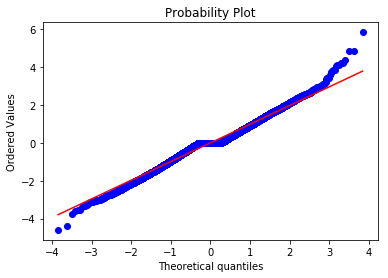

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0016
Kurtosis: 0.9882
Overview of variable:  monsterkills 


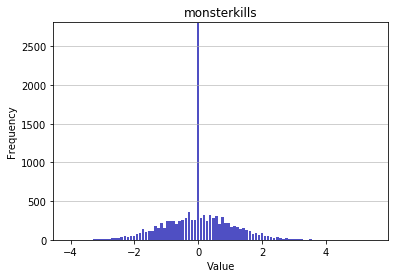

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.068830154001811
Mean: -0.0
Standard deviation: 1.0
Median: 0.0141
Maximal value: 5.479646780605285


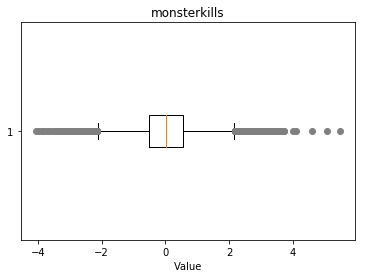

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.51, 3.25, 4.59, 3.72, 3.56, 5.48, 3.1, 3.65, 5.06, 3.42, 4.0, 3.5, -3.81, 3.66, 3.41, 3.26, 3.59, 4.08, 3.16, -3.48, 3.03, -3.04, -3.21, -3.13, -3.71, -3.3, 3.27, 3.35, -3.96, 3.18, 3.45, -3.86, -3.43, 3.04, 3.12, 3.37, 3.21, 3.7, 3.73, -3.66, -3.34, -3.0, -3.09, -4.07, -3.57}


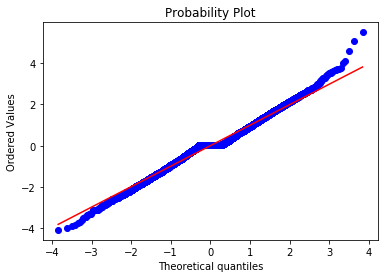

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0229
Kurtosis: 0.8561
Overview of variable:  monsterkillsownjungle 


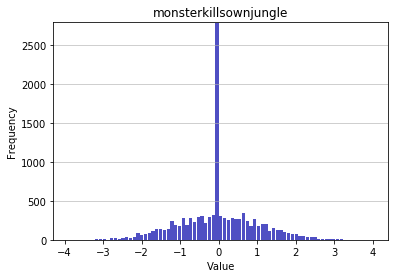

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.90382768690078
Mean: 0.0
Standard deviation: 1.0
Median: -0.002
Maximal value: 4.014611574247769


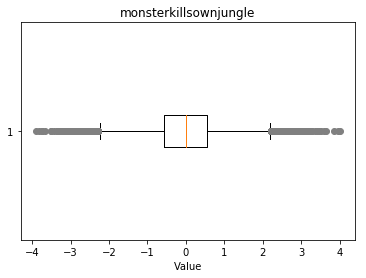

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.01, 3.46, 3.86, 3.14, 3.42, 3.95, 3.16, 3.18, 4.01, 3.07, 3.09, -3.82, -3.9, -3.22, 3.51, 3.66, 3.26, 3.35, -3.29, 3.6, 3.03, 3.05, -3.36, -3.02, -3.43, 3.12, 3.29, 3.22, -3.51, -3.08, -3.74, -3.66, -3.15}


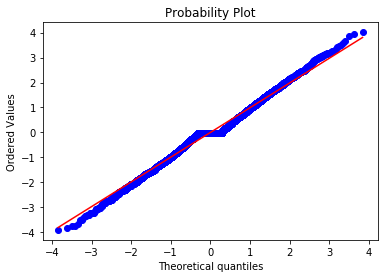

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0145
Kurtosis: 0.6138
Overview of variable:  monsterkillsenemyjungle 


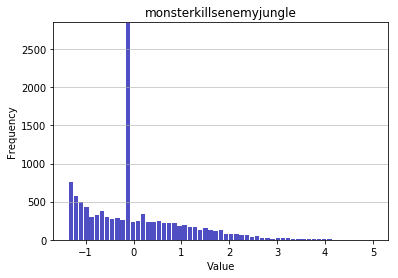

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.3620769276937628
Mean: -0.0
Standard deviation: 1.0
Median: -0.1655
Maximal value: 5.007681200797717


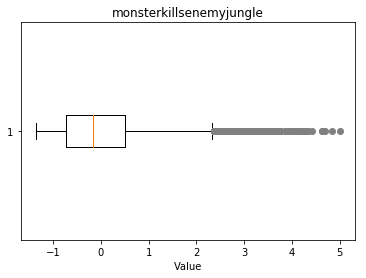

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.07, 3.99, 3.18, 3.74, 4.62, 4.27, 3.46, 3.35, 3.21, 4.02, 4.2, 5.01, 3.49, 3.25, 3.67, 3.0, 3.92, 3.42, 4.23, 4.41, 4.16, 4.34, 4.09, 4.83, 3.53, 3.28, 3.11, 3.78, 3.6, 3.85, 3.88, 3.71, 3.04, 4.69, 4.13, 4.06, 3.39, 3.14, 3.32, 3.64, 3.56}


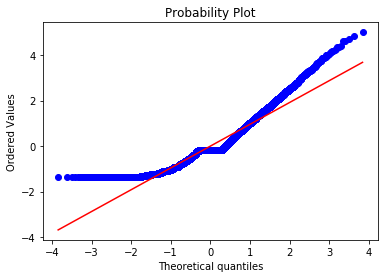

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0416
Kurtosis: 1.1694
Overview of variable:  cspm 


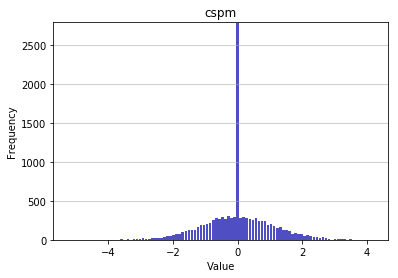

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.236743939282242
Mean: 0.0
Standard deviation: 1.0
Median: -0.0105
Maximal value: 4.190302233239771


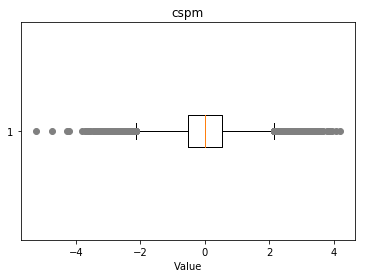

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.56, 4.19, 3.34, 3.03, 3.02, 3.08, 3.35, 4.06, 3.05, 3.21, 3.5, -3.06, -3.32, -3.4, 3.24, 3.26, 3.17, 3.09, 3.66, -4.72, -4.21, 3.78, 3.28, 3.86, -3.63, -3.05, -3.2, -3.55, -3.04, -3.46, -3.21, -3.37, -3.38, -3.71, 3.53, 3.32, 3.04, -3.02, -3.27, -3.11, -3.36, 3.13, 3.8, 3.62, 3.11, 3.38, 3.47, -3.42, -3.16, -3.08, -3.09, -3.01, -3.67, -3.58, 3.44, 3.94, -3.59, -5.24, -4.27, -3.79}


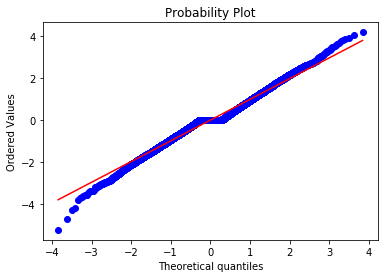

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.9419
Overview of variable:  goldat10 


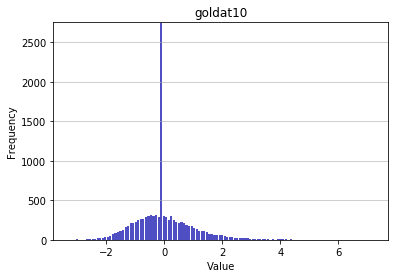

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.302654452292899
Mean: 0.0
Standard deviation: 1.0
Median: -0.0918
Maximal value: 7.206882570393811


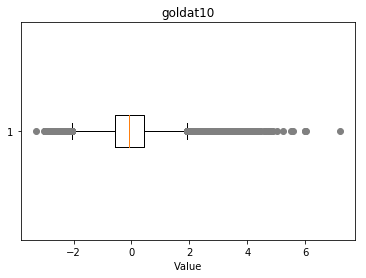

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.1, 3.2, 3.34, 4.59, 6.03, 3.24, 3.42, 3.53, 3.35, 3.01, 4.42, 5.24, 7.21, 3.5, 3.25, 3.0, 4.07, 4.82, 3.18, 3.36, 3.61, 3.93, 3.29, 3.04, 4.61, 4.36, 4.72, 3.72, 3.4, 3.47, 3.97, 3.22, 3.76, 3.58, 3.33, 3.51, 3.08, 4.4, 4.15, 4.26, 3.26, 5.58, 6.01, 3.94, 3.44, 3.05, 3.12, 3.3, 3.37, 3.55, 4.3, 3.23, 3.98, 3.16, 3.09, 3.84, 3.66, 3.91, 4.66, 4.34, 4.23, 5.98, 5.02, 5.52, 3.52, 3.27, 3.02, -3.3, 3.7, 3.38, 3.45, 3.88, 4.13, 4.31, 4.88, 3.81, 3.06, 3.56, -3.01, 3.17, 3.74, 3.49, 4.1, 4.49, 3.03, 3.28, 3.85, 3.78, 3.21, 4.03, 4.21, 4.78, 3.07, 3.39, 3.14, 3.57, -3.0}


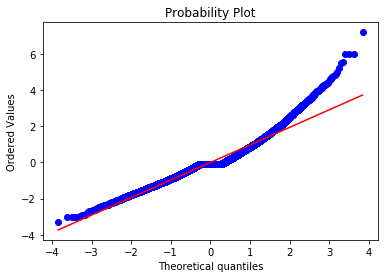

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9147
Kurtosis: 2.554
Overview of variable:  gdat10 


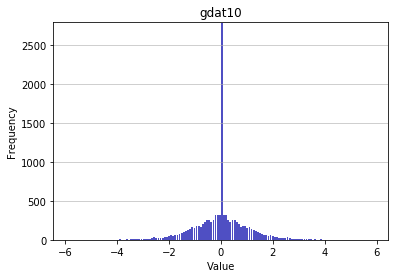

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.868882179985169
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 5.868882179985169


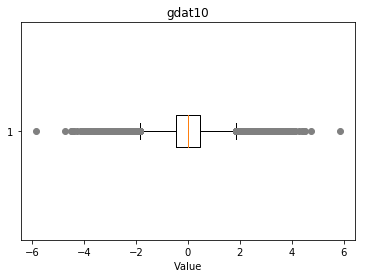

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.48, 3.14, 5.87, 4.11, 3.26, 3.13, 3.47, 3.39, 3.99, 3.32, 4.28, 3.5, -3.39, -3.32, -3.14, -3.07, 4.43, 3.25, -4.14, 3.36, -3.46, -3.96, -3.21, 3.43, 3.54, -3.35, 3.04, -3.6, -3.03, 4.47, 4.04, -4.74, 3.22, -3.24, -3.99, 3.9, 3.4, 3.33, 3.08, -3.06, -3.31, 4.01, 4.51, 3.19, -3.13, -3.2, -3.38, -3.88, 3.44, 3.62, 3.55, 3.8, 3.12, 3.37, 3.05, 3.3, -4.41, 3.73, -3.84, -3.16, -3.41, -3.09, -3.66, 3.09, 3.16, -3.73, 3.41, 3.84, 4.41, -3.48, 3.66, -3.55, -3.8, -3.12, -3.62, -3.37, -3.05, -3.3, 3.88, -3.19, -3.44, 3.2, 3.38, -4.01, -4.51, 3.06, -3.26, -3.33, -3.08, 3.31, 3.24, -3.9, -3.22, -3.4, 4.74, -4.11, -4.47, -4.04, 3.35, -3.54, -3.04, 3.6, 3.03, 3.46, 3.96, -3.36, 3.21, -3.43, 4.14, -4.43, 3.07, -3.5, -3.25, -5.87, -4.28, -3.47}


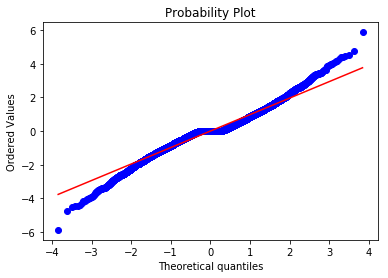

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 2.0931
Overview of variable:  goldat15 


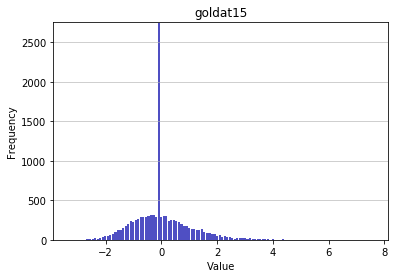

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.333941934063735
Mean: 0.0
Standard deviation: 1.0
Median: -0.0854
Maximal value: 7.601922460697474


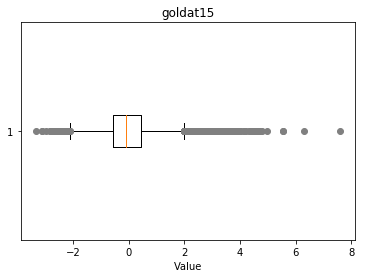

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.69, 4.43, 4.97, 4.04, 4.34, 4.22, 3.49, 3.58, 3.05, 3.31, 5.54, 7.6, 6.3, 3.5, 3.0, 3.36, 3.11, 3.68, 3.86, 3.18, 3.29, 3.04, 3.54, 4.72, 3.65, 3.72, 3.15, 3.97, 3.22, 3.76, 3.08, 3.26, 3.33, 4.58, 3.94, 3.19, 3.44, 3.37, 3.12, 3.55, 3.8, 4.55, 4.37, 4.44, 3.73, 3.48, 3.09, 3.16, 3.84, 3.59, 3.41, 4.41, 3.34, 3.52, 3.02, 3.13, 3.38, 3.63, 3.2, 4.81, 4.13, 3.06, 3.81, -3.33, 3.56, 3.42, 3.17, 3.67, 3.92, 4.67, 3.53, 3.1, 3.03, 3.28, 3.85, 3.96, 3.46, 3.21, -3.11, 4.39, 4.14, 4.64, 3.14, 3.07, 3.82, 3.32, -3.1}


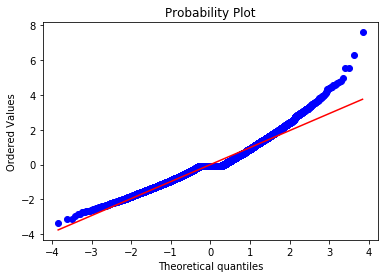

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7773
Kurtosis: 1.9893
Overview of variable:  gdat15 


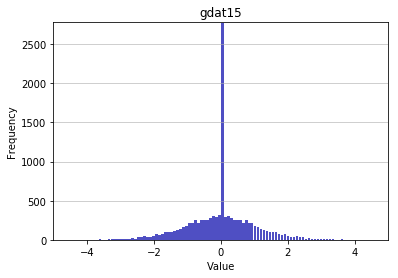

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.552034419567237
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.552034419567237


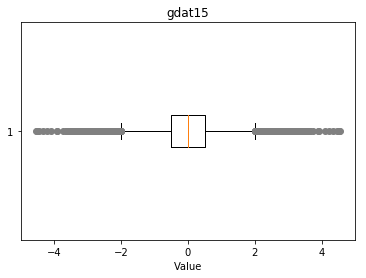

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.14, 4.47, 3.02, 3.01, 3.16, 3.6, 3.32, 3.31, 4.52, 4.2, 3.73, 3.59, -3.05, 3.34, -3.32, -3.31, -3.07, -3.06, 3.08, 3.92, -3.23, -3.47, 3.0, 3.66, 3.25, 3.52, 4.08, 4.33, -3.9, -3.65, -3.59, -4.2, -4.47, -4.55, 3.53, 3.27, -3.2, 3.43, 3.11, -3.13, -3.29, 3.36, 3.03, 3.19, 3.28, -3.25, 3.05, 3.21, -3.21, 3.2, -3.6, -3.02, -3.27, -3.43, -3.11, 3.13, 3.29, -3.36, -3.03, -3.19, -3.28, 4.55, -3.53, 3.9, 3.65, -3.52, -4.08, -4.33, 3.07, -3.01, -3.16, 3.06, -3.34, -3.08, -3.92, 3.23, 3.47, -3.0, -3.66, -4.52, -3.14, -3.73}


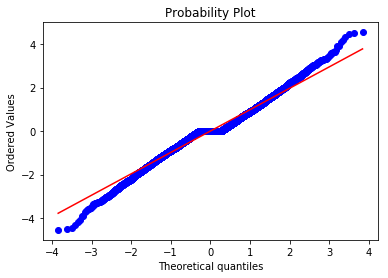

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.327
Overview of variable:  xpat10 


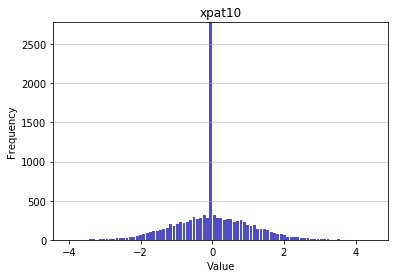

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.013036244028306
Mean: 0.0
Standard deviation: 1.0
Median: -0.0061
Maximal value: 4.495643553229995


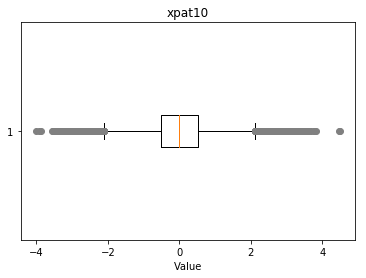

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.51, 3.81, 3.78, 3.2, 3.24, 3.28, 3.03, 3.35, 3.52, 3.04, 4.46, 3.09, 3.23, 3.67, -3.07, -3.23, -3.56, -3.06, 4.5, 3.42, 3.25, 3.0, 3.08, 3.5, 3.63, 3.1, -3.45, -3.29, 3.36, 3.18, -3.04, 3.11, -3.38, 3.02, 3.19, -3.3, 3.46, 3.37, -3.18, -3.53, -3.02, -3.11, -3.85, -3.28, -3.1, -3.27, 3.13, -3.93, 3.54, 3.06, -3.24, -3.41, -3.09, -3.5, -3.17, 3.07, 3.55, 3.58, 3.47, -4.01, -3.4}


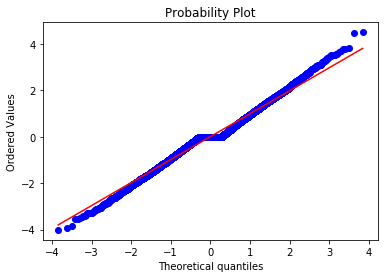

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0458
Kurtosis: 0.8394
Overview of variable:  xpdat10 


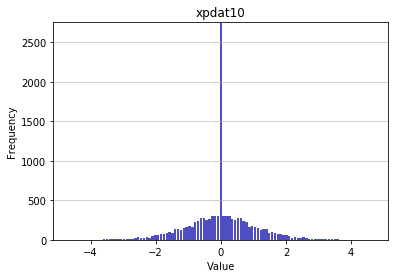

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.679789860511592
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.679789860511592


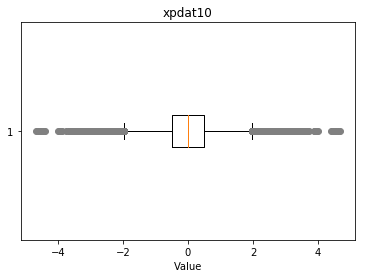

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.2, 3.41, 4.47, 3.92, 3.33, 3.31, 3.43, 3.0, 3.07, 3.66, 4.56, -3.07, -3.32, -3.57, -3.89, 4.68, -4.53, 3.11, -3.21, -3.46, 3.04, -3.28, -3.03, -3.35, 4.61, 3.47, -3.99, 3.65, -3.92, -3.24, -3.74, -3.67, -3.49, 3.01, 3.58, 3.51, 4.4, 3.44, -3.2, -3.45, -3.13, 3.12, 3.37, 3.55, 3.05, -3.02, -3.52, -3.27, 3.23, -3.66, -3.16, -3.41, -3.91, 3.16, -3.23, 3.91, 3.02, -3.55, -3.05, -3.12, -3.37, 3.52, 3.27, 3.45, -3.44, 3.13, -4.4, -3.51, -3.33, -3.01, -3.58, 3.24, -3.65, 3.74, 3.67, -3.47, 3.99, 3.49, -4.61, -4.47, 3.03, 3.28, -3.04, 3.35, 3.21, -3.11, -3.43, 3.46, 4.53, -4.68, 3.89, 3.32, 3.57, -3.0, -4.56, -3.31}


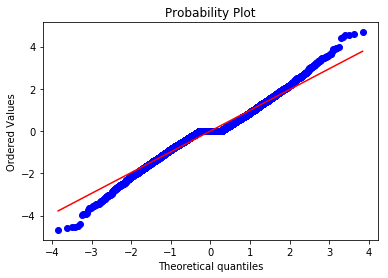

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.5716
Overview of variable:  csat10 


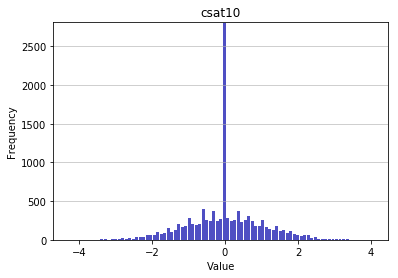

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.288229563583913
Mean: -0.0
Standard deviation: 1.0
Median: -0.0144
Maximal value: 4.061063236763666


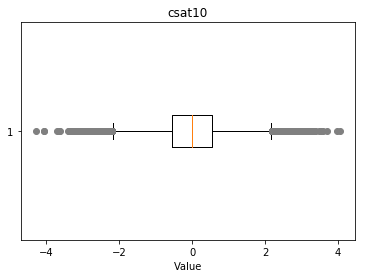

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.49, 3.06, 3.1, 3.28, 3.54, 3.36, 3.23, 3.97, 3.15, 3.02, 4.06, 3.58, -3.22, -3.06, -4.05, 3.19, -3.62, -3.3, -3.7, -3.38, 3.71, -3.18, -3.02, 3.32, -3.66, -3.26, -3.34, -3.42, -4.29, -3.1}


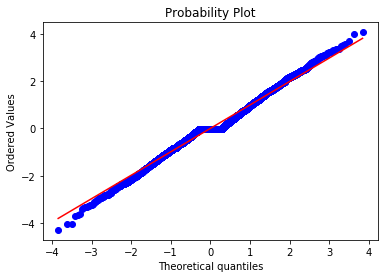

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.02
Kurtosis: 0.6582
Overview of variable:  csdat10 


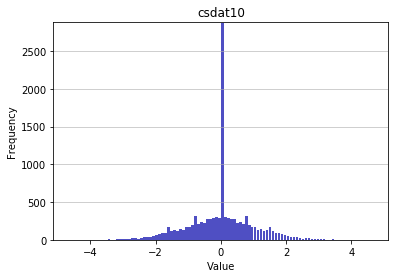

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.6678815517480965
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.6678815517480965


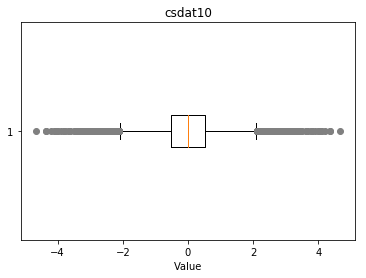

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.8, 3.07, 4.37, 3.2, 3.11, 3.67, 3.63, 3.03, 3.24, 3.28, 4.06, 3.5, -3.07, 3.16, 3.41, 3.33, 3.76, 4.67, -3.98, -3.89, 4.02, -4.06, -4.19, -4.11, -3.2, -3.63, -3.46, 3.46, -3.11, -3.03, -3.28, 4.19, 4.11, -4.67, -4.02, 3.98, -3.67, -3.24, -3.5, -3.16, -3.41, -3.33, -3.76, 3.89, -4.37, -3.8}


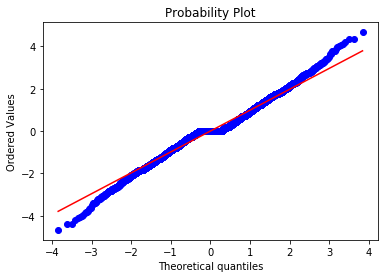

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.1448
Overview of variable:  csat15 


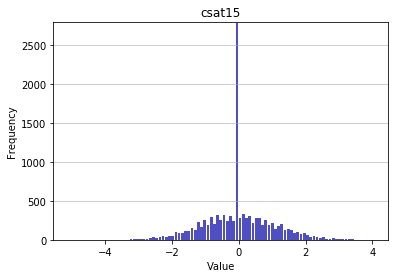

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.0966427649314925
Mean: 0.0
Standard deviation: 1.0
Median: -0.0118
Maximal value: 4.027429333128728


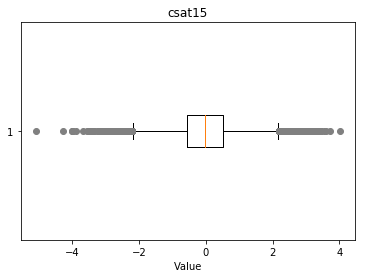

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.1, 3.02, 3.17, 3.72, 3.33, 3.41, 3.46, 3.12, 3.2, 3.36, 4.03, 3.25, -3.14, -3.89, -3.57, -3.48, -3.98, 3.28, -3.05, -3.54, -3.45, -3.37, 3.43, 3.38, -3.68, -3.11, -3.19, -3.02, 3.04, 3.54, 3.62, 3.3, -4.0, 3.15, -3.42, -3.25, -3.51, 3.07, -3.34, -5.1, -4.27, -3.17}


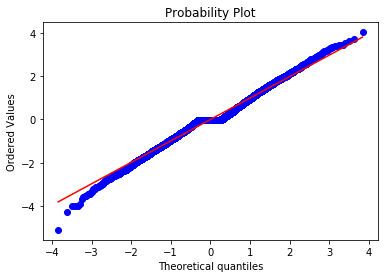

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.015
Kurtosis: 0.7441
Overview of variable:  csdat15 


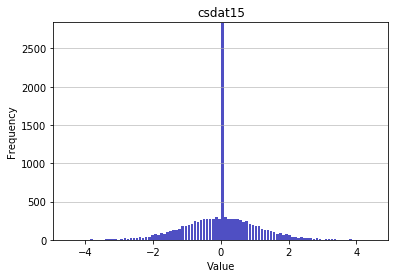

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.500038029924059
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 4.500038029924059


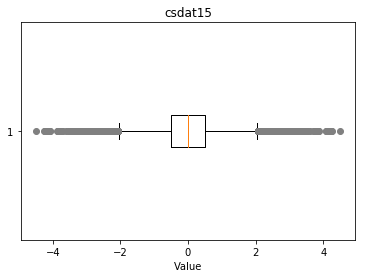

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.28, 3.1, 4.14, 3.81, 4.08, 3.13, 3.22, 3.87, 3.34, 3.19, 4.17, 3.84, -3.81, -3.22, 3.75, 3.16, 3.01, -3.4, -3.31, 3.49, -3.07, 4.26, 4.5, 4.23, -4.14, 3.61, -3.13, -3.87, -3.7, 3.52, 3.78, -3.55, -3.46, -3.37, -3.04, 3.7, -3.19, -3.1, -3.61, -3.52, -3.78, 3.55, 3.46, 3.25, 3.37, 3.04, -4.17, -4.26, -4.5, -4.23, 3.4, -3.34, -3.84, -3.75, -3.16, -3.01, 3.31, -3.49, 3.07, -3.25, -4.08, -3.28}


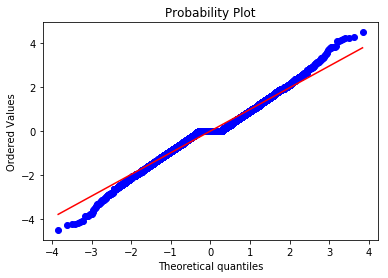

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.2432
Overview of variable:  datediff 


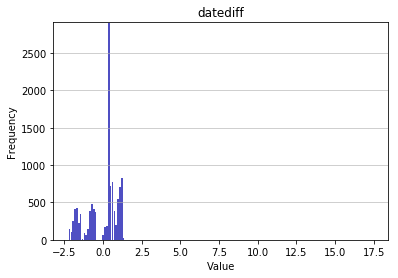

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.2339420944953976
Mean: -0.0
Standard deviation: 1.0
Median: 0.3685
Maximal value: 17.456576666833836


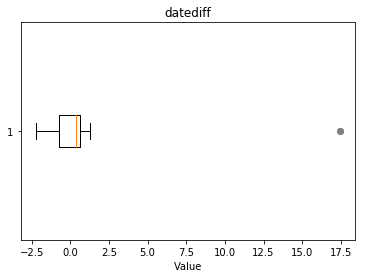

-------------------- 
Outlier detection:
 --------------------
List of outliers: {17.46}


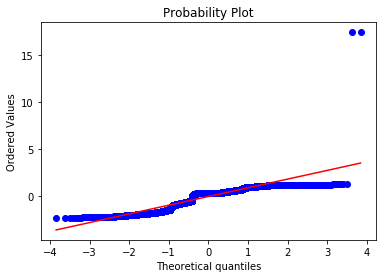

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.241
Kurtosis: 15.3847
Overview of variable:  Encoded_league 


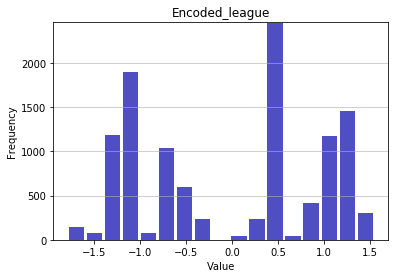

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.7888021250858253
Mean: -0.0
Standard deviation: 1.0
Median: 0.4355
Maximal value: 1.5476262927189042


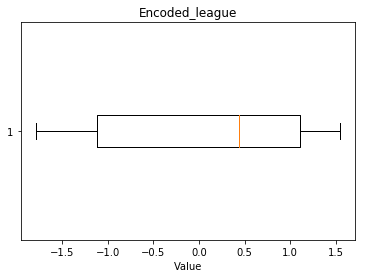

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


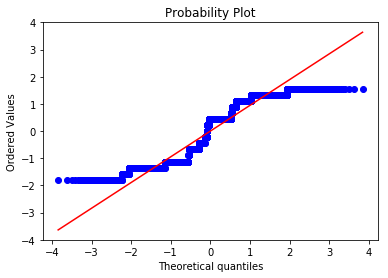

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0475
Kurtosis: -1.4696
Overview of variable:  Encoded_game 


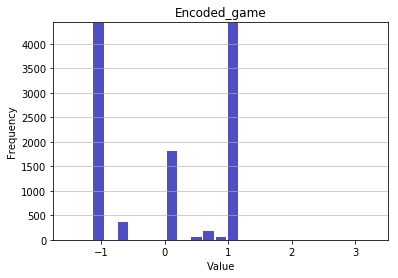

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5250475693342893
Mean: 0.0
Standard deviation: 1.0
Median: 0.082
Maximal value: 3.2960159373872084


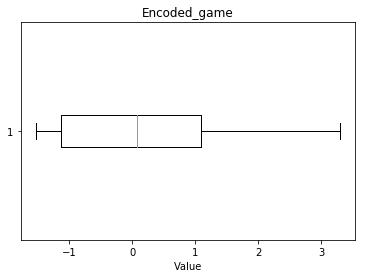

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.1, 3.3}


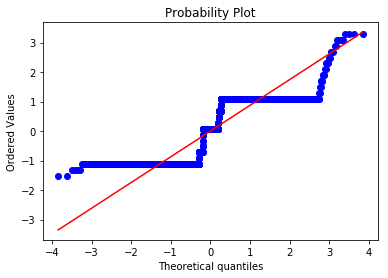

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0086
Kurtosis: -1.6875
Overview of variable:  Encoded_side 


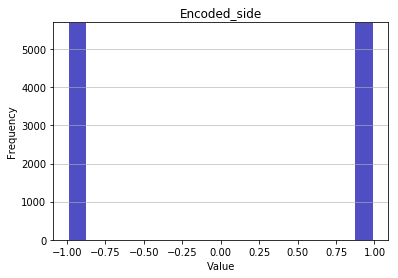

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.0
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 1.0


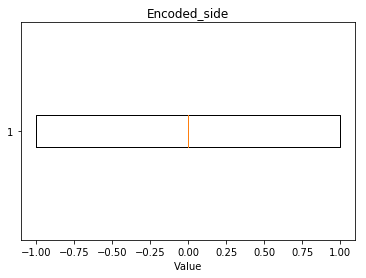

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


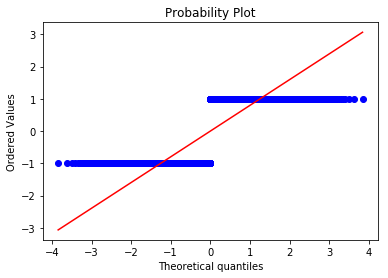

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_ban1 


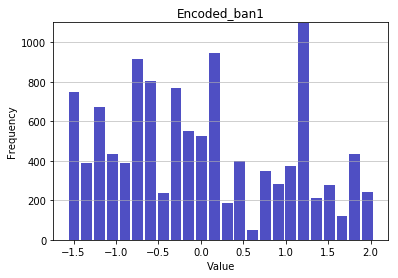

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5704360021591313
Mean: -0.0
Standard deviation: 1.0
Median: -0.0897
Maximal value: 2.038902788313494


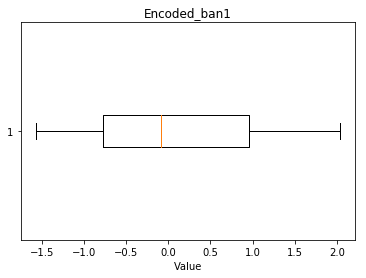

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


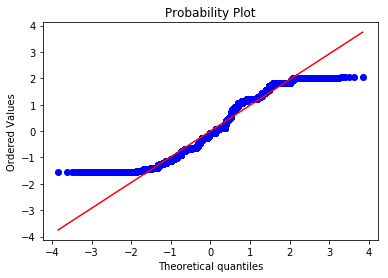

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2906
Kurtosis: -1.0243
Overview of variable:  Encoded_ban2 


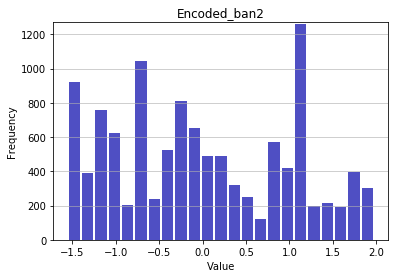

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5551772541254978
Mean: 0.0
Standard deviation: 1.0
Median: -0.1016
Maximal value: 1.974962286624107


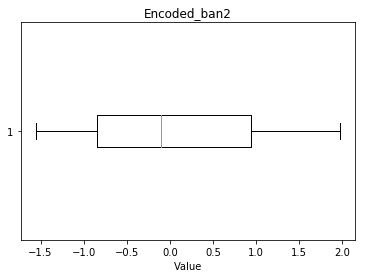

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


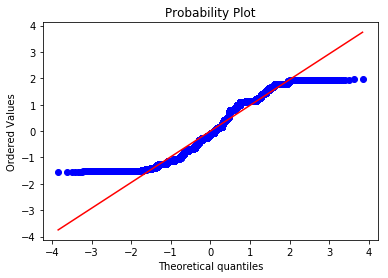

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2141
Kurtosis: -1.1235
Overview of variable:  Encoded_ban3 


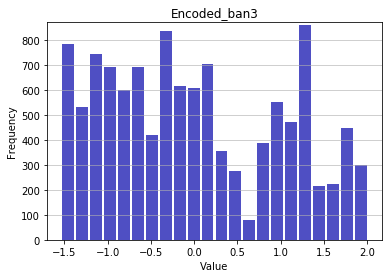

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5365567572212295
Mean: 0.0
Standard deviation: 1.0
Median: -0.1371
Maximal value: 2.0049437439822566


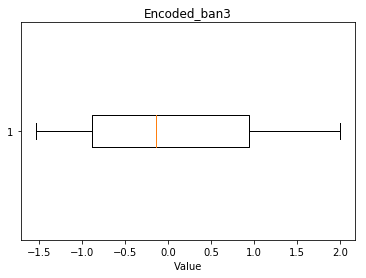

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


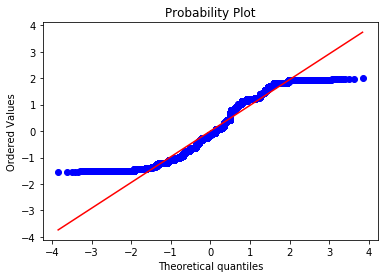

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2939
Kurtosis: -1.083
Overview of variable:  Encoded_ban4 


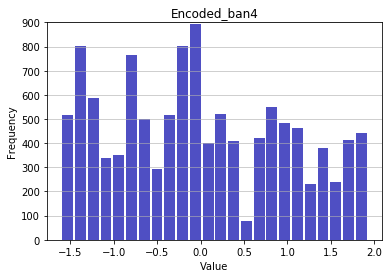

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.6038984919915675
Mean: -0.0
Standard deviation: 1.0
Median: -0.0763
Maximal value: 1.923571078069495


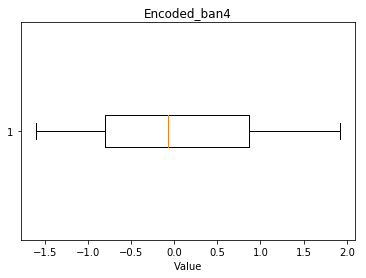

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


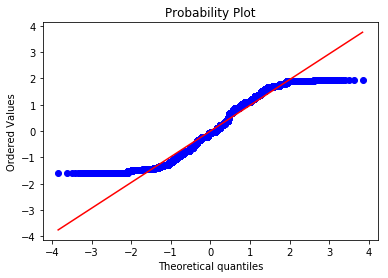

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2106
Kurtosis: -1.0529
Overview of variable:  Encoded_ban5 


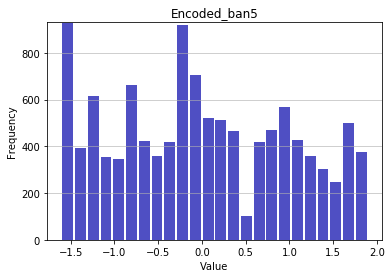

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.60612248861129
Mean: -0.0
Standard deviation: 1.0
Median: -0.0441
Maximal value: 1.8950450683249667


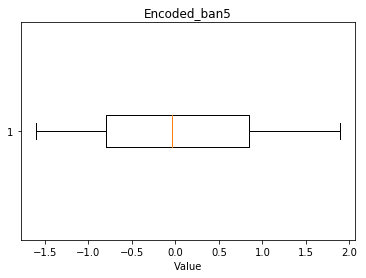

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


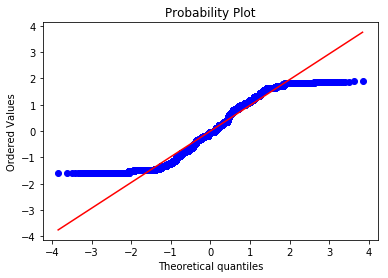

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1467
Kurtosis: -1.0723
Overview of variable:  Encoded_result 


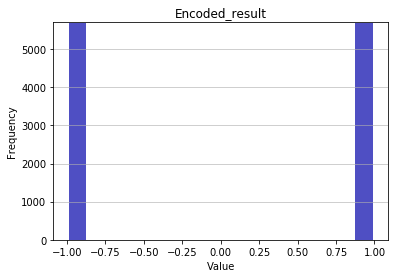

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.0
Mean: 0.0
Standard deviation: 1.0
Median: 0.0
Maximal value: 1.0


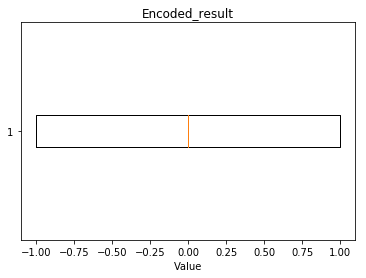

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


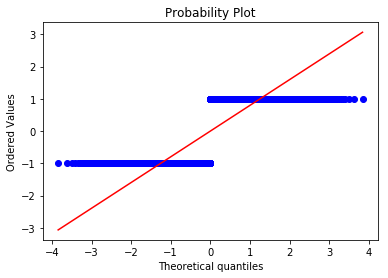

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_fb 


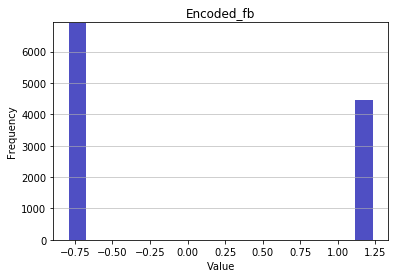

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8029728158289599
Mean: 0.0
Standard deviation: 1.0
Median: -0.803
Maximal value: 1.245372172366304


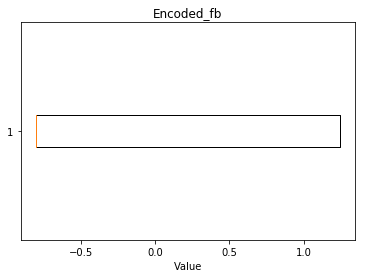

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


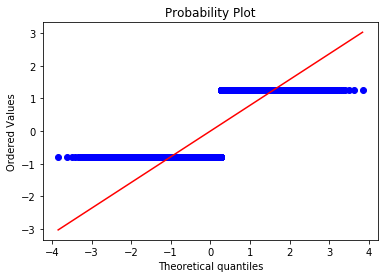

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4424
Kurtosis: -1.8043
Overview of variable:  Encoded_fbassist 


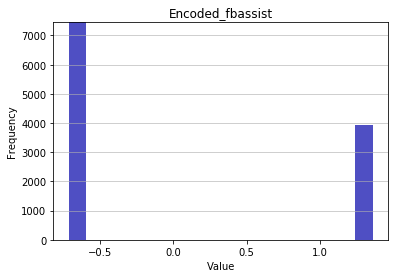

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7277914298044488
Mean: -0.0
Standard deviation: 1.0
Median: -0.7278
Maximal value: 1.3740200269583989


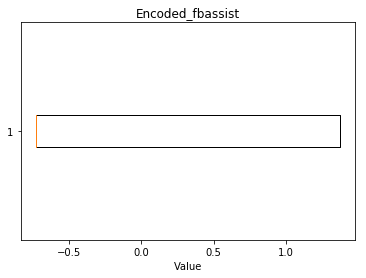

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


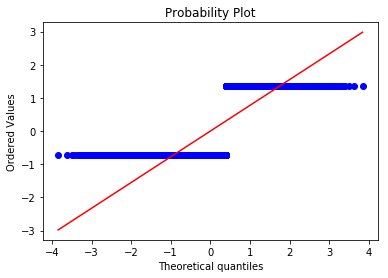

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6462
Kurtosis: -1.5824
Overview of variable:  Encoded_fbvictim 


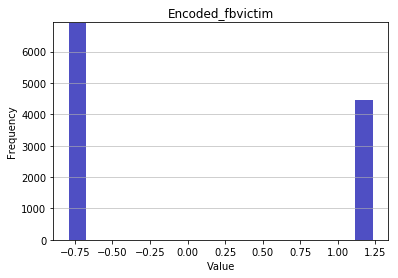

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8029728158289599
Mean: 0.0
Standard deviation: 1.0
Median: -0.803
Maximal value: 1.245372172366304


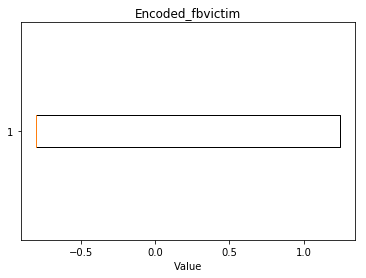

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


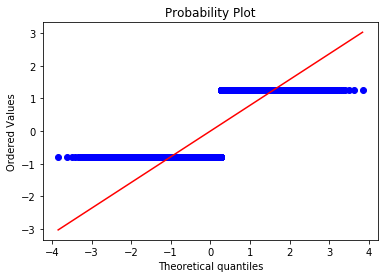

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4424
Kurtosis: -1.8043
Overview of variable:  Encoded_fd 


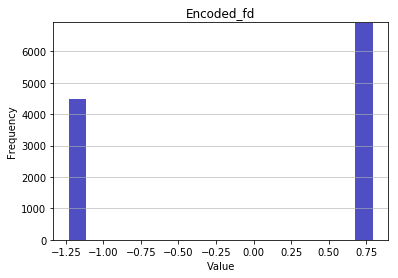

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2419382892421484
Mean: -0.0
Standard deviation: 1.0
Median: 0.8052
Maximal value: 0.8051929863682814


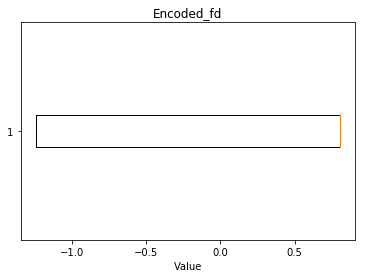

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


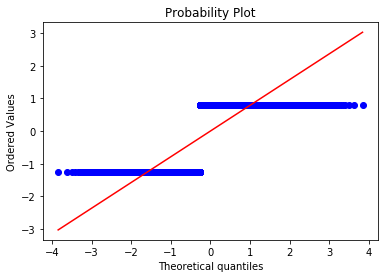

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4367
Kurtosis: -1.8093
Overview of variable:  Encoded_herald 


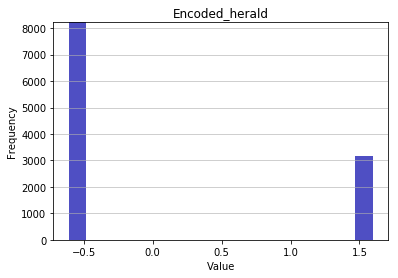

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.6216816962617036
Mean: -0.0
Standard deviation: 1.0
Median: -0.6217
Maximal value: 1.608540199933825


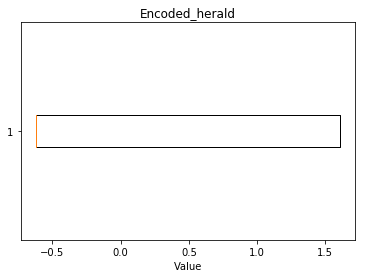

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


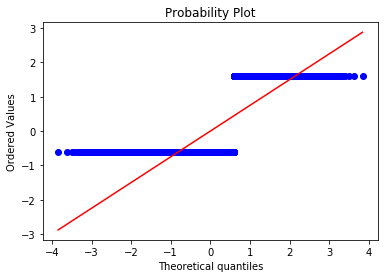

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9869
Kurtosis: -1.0261
Overview of variable:  Encoded_ft 


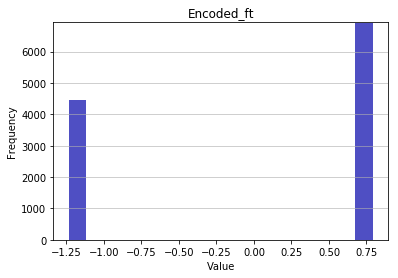

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2453721723663043
Mean: -0.0
Standard deviation: 1.0
Median: 0.803
Maximal value: 0.8029728158289599


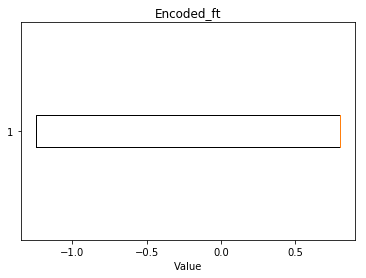

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


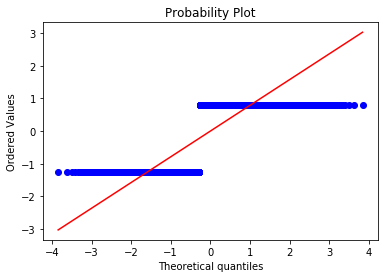

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4424
Kurtosis: -1.8043
Overview of variable:  Encoded_firstmidouter 


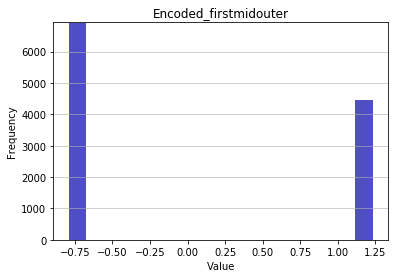

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8029728158289599
Mean: 0.0
Standard deviation: 1.0
Median: -0.803
Maximal value: 1.245372172366304


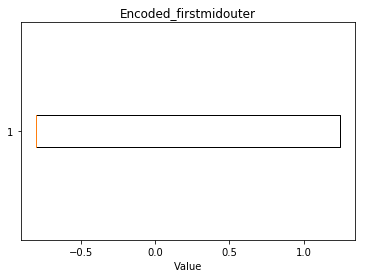

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


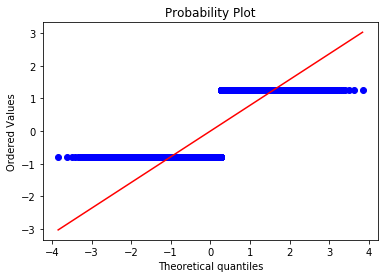

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4424
Kurtosis: -1.8043
Overview of variable:  Encoded_firsttothreetowers 


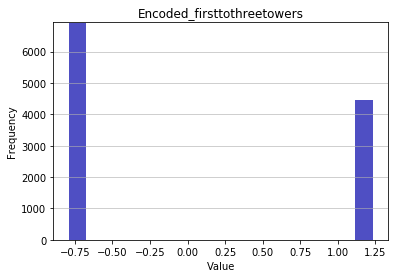

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8029728158289599
Mean: 0.0
Standard deviation: 1.0
Median: -0.803
Maximal value: 1.245372172366304


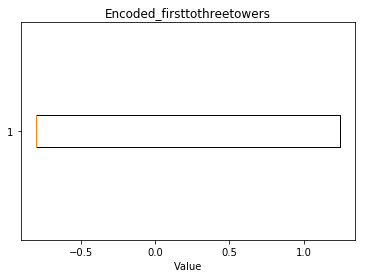

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


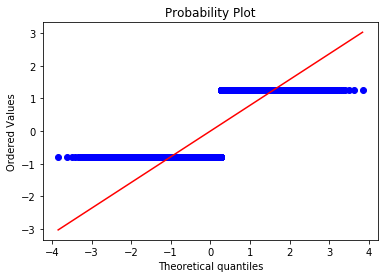

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4424
Kurtosis: -1.8043
Overview of variable:  Encoded_fbaron 


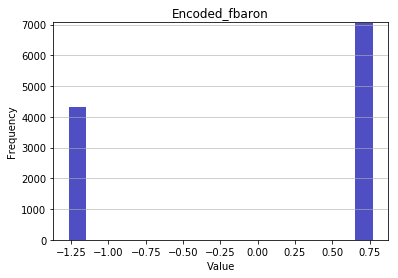

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2778565039032084
Mean: 0.0
Standard deviation: 1.0
Median: 0.7826
Maximal value: 0.7825604807312118


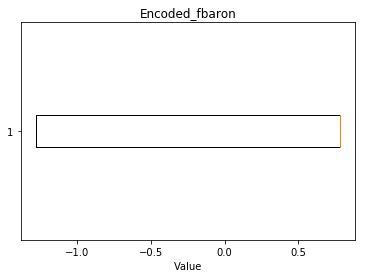

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


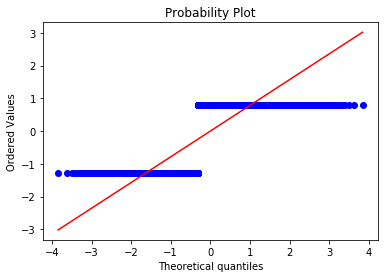

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4953
Kurtosis: -1.7547
Overview of variable:  Encoded_Year 


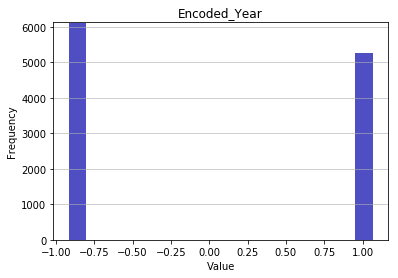

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.927960727050589
Mean: 0.0
Standard deviation: 1.0
Median: -0.928
Maximal value: 1.0776318120587491


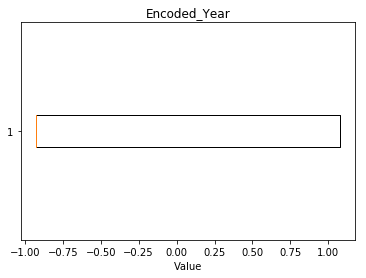

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


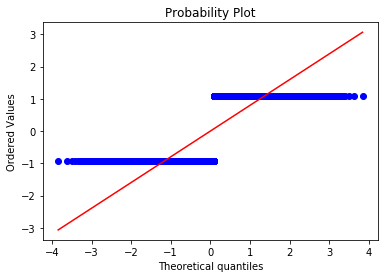

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1497
Kurtosis: -1.9776
Overview of variable:  Encoded_culture 


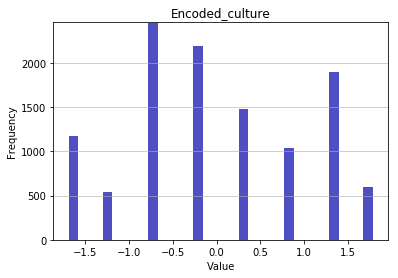

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.7012100195713147
Mean: 0.0
Standard deviation: 1.0
Median: -0.2027
Maximal value: 1.7953221226338028


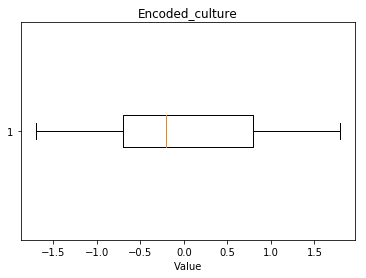

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


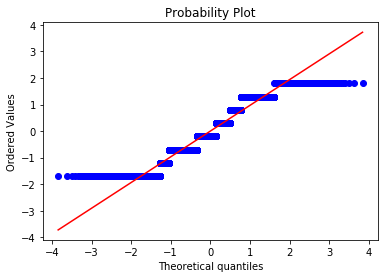

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0521
Kurtosis: -0.9303


<Figure size 432x288 with 0 Axes>

In [23]:
# Loop through all numerical variables and visualize data
for num_variable in numerical_variables:
    SummaryNumericVar(transformed_data_df[num_variable], num_variable)

### 2.3 Conclusion univariate analysis

In [24]:
# Check whether all features in the dataset are numeric
set(transformed_data_df.dtypes)

{dtype('float64'), dtype('O')}

In [25]:
# Short intermediate summary
print("The transformed dataset captures information from", len(transformed_data_df.columns), "features.")
print("In total, there are", len(transformed_data_df), "observations present in the dataframe, capturing the information from",
      int(len(transformed_data_df)/2), "games.")
print("\nThe following features are captured by the dataset:\n\n", list(transformed_data_df.columns))

The transformed dataset captures information from 74 features.
In total, there are 11390 observations present in the dataframe, capturing the information from 5695 games.

The following features are captured by the dataset:

 ['split', 'patchno', 'gamelength', 'k', 'd', 'a', 'teamkills', 'fbtime', 'kpm', 'ckpm', 'fdtime', 'teamdragkills', 'elementals', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'heraldtime', 'fttime', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'wards', 'wpm', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 'gdat10', 'goldat15', 'gdat15', 'xpat10', 'xpdat10', 'csat10', 'csdat10', 'csat15', 'csdat15', 'datediff', 'Encoded_league', 'Encoded_game', 'Encoded_side', 'Encoded_ban1', 'Encoded_ban2', 'Encod

---------------------------------------------------------------------------------------------------- 
Overview of variable:  result 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



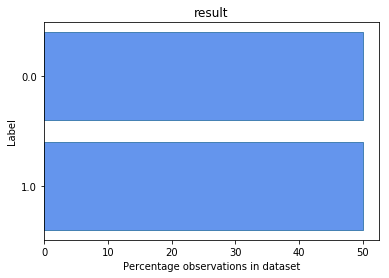

<Figure size 432x288 with 0 Axes>

In [26]:
# Refactoring encoding of target feature
transformed_data_df['result'] = [x if x > 0 else 0 for x in transformed_data_df['Encoded_result']]
transformed_data_df = transformed_data_df.drop(['Encoded_result'], axis = 1)

# Visualization properties target
SummaryCategoricalVar(transformed_data_df['result'], 'result')

In [27]:
# Save the transformed data
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + saved_filename + '.pickle', 'wb') as f:
    pickle.dump(transformed_data_df, f)

In [28]:
# Save the file containing the column name and matching box-cox
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + saved_filename + '_optimizers.pickle', 'wb') as f:
    pickle.dump(optimiser_dict, f)

## 3. Multivariate analysis
* Correlation plot (remove variables that are highly correlated)
* Boxplot/ scatterpot/ wrapped plot to visualize important relationships between variables
* t-test to assess difference between categories

### 3.1 Collinearity exploration

##### Investigate correlation between features

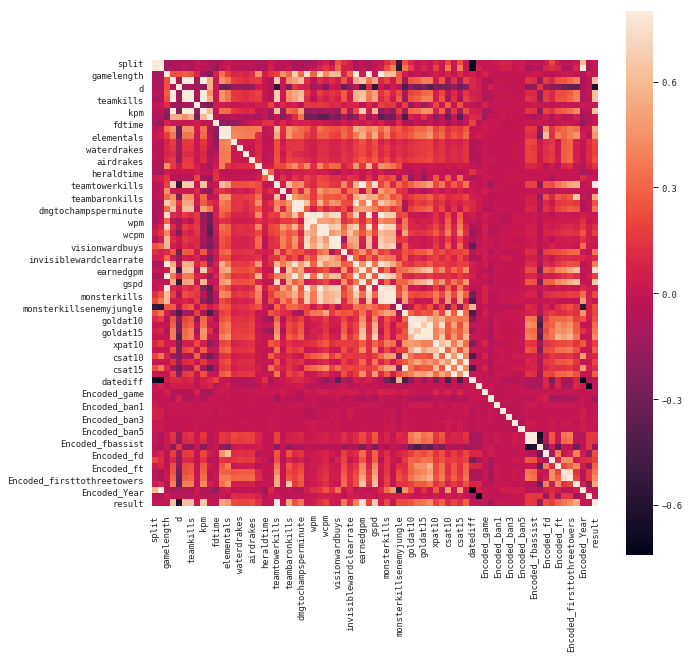

In [29]:
# Create corrplot
sns.set(context = "paper", font = "monospace")
corrmat = transformed_data_df.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corrmat, vmax = .8, square = True) 
plt.show()

In [30]:
# Print list with highest correlated features
corrmap_abs = transformed_data_df.corr().abs()
corrmap_abs_sorted = corrmap_abs.unstack().sort_values(kind = "quicksort", ascending = False)
corrmap_abs_sorted.iloc[(len(transformed_data_df.columns) + 3):(len(transformed_data_df.columns) + 1) + 20,]

a                 teamkills           0.931120
                  k                   0.931120
Encoded_Year      patchno             0.909340
patchno           Encoded_Year        0.909340
k                 kpm                 0.907408
teamkills         kpm                 0.907408
kpm               k                   0.907408
                  teamkills           0.907408
Encoded_fbassist  Encoded_fb          0.906371
Encoded_fb        Encoded_fbassist    0.906371
wcpm              wardkills           0.902560
wardkills         wcpm                0.902560
csat10            csat15              0.886441
csat15            csat10              0.886441
totalgold         gamelength          0.883547
gamelength        totalgold           0.883547
earnedgpm         gspd                0.881747
gspd              earnedgpm           0.881747
dtype: float64

In [31]:
# Short intermediate summary
print("The percentage of correlations (autocorrelations excluded) higher than 0.5 in absolute value: ",
      str(sum([x for x in list(corrmap_abs_sorted) if x >= 0.5])/len(corrmap_abs_sorted)*100))

The percentage of correlations (autocorrelations excluded) higher than 0.5 in absolute value:  5.961718866166266


##### Calculate variance inflation factor
This is purely out of interest, although we expect penelized regression methods to be able to cope with collinearity between the features.

In [32]:
# Extract dataset containing only the numeric features
transformed_data_numeric_df = transformed_data_df.copy()
transformed_data_numeric_df = transformed_data_numeric_df.drop(labels = ['team'], axis=1)

In [33]:
# Calculate the variance inflation factor for the different features
X = add_constant(transformed_data_numeric_df)
vif_columns = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)

In [34]:
# Print the top 20 features with the highest VIF
vif_columns_sorted = vif_columns.sort_values(kind = "quicksort", ascending = False)
vif_columns_sorted[:20]

earthdrakes                    inf
airdrakes                      inf
k                              inf
waterdrakes                    inf
firedrakes                     inf
teamkills                      inf
Encoded_fbvictim               inf
elementals                     inf
Encoded_fb                     inf
wards                   603.737600
wardkills               520.135175
minionkills             316.609728
dmgtochamps             278.485971
wcpm                    245.284348
wpm                     180.809656
dmgtochampsperminute    131.808864
totalgold                88.906939
cspm                     79.031015
gamelength               73.205159
kpm                      46.508311
dtype: float64

### 3.2 Some visualizations

In [35]:
data_preparation.columns

Index(['gameid', 'league', 'split', 'game', 'patchno', 'side', 'ban1', 'ban2',
       'ban3', 'ban4', 'ban5', 'gamelength', 'result', 'k', 'd', 'a',
       'teamkills', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'ckpm',
       'fd', 'fdtime', 'teamdragkills', 'elementals', 'firedrakes',
       'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'herald',
       'heraldtime', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers',
       'teamtowerkills', 'fbaron', 'fbarontime', 'teambaronkills',
       'dmgtochamps', 'dmgtochampsperminute', 'wards', 'wpm', 'wardshare',
       'wardkills', 'wcpm', 'visionwards', 'visionwardbuys',
       'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold',
       'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills',
       'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10',
       'gdat10', 'goldat15', 'gdat15', 'xpat10', 'xpdat10', 'csat10',
       'csdat10', 'csat15', 'csdat15', 'Year', 'team', 'culture', 'd

NameError: name 'dog' is not defined

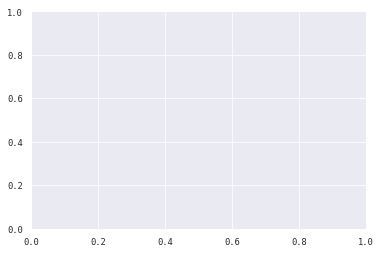

In [36]:
fig, ax = plt.subplots()
ax.plot(data_preparation.league, dog, label="dog")
ax.plot(data_preparation.league, cat, label="cat")
ax.legend()

In [ ]:
# Visualize a summarization of the accuracy metrics for the different ML methods
fig, ax = plt.subplots()
ax.plot(list(data_preparation.index), model_summary_table.sensitivity, '--', label="sensitivity", color='lightskyblue')
ax.plot(list(data_preparation.index), model_summary_table.specificity, '--', label="specificity", color='lightblue')
ax.plot(list(model_summary_table.index), model_summary_table.accuracy, label="accuracy", color='royalblue')
plt.title("Sensitivity, specificity and accuracy regularization models")
ax.legend(loc ="best", fontsize = 8)